In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import collections
import os

import logging
import pickle
from tqdm import tqdm

logger = logging.getLogger(__name__)

In [3]:
import networkx as nx
seed = 20160  # seed random number generators for reproducibility

In [28]:
G= nx.erdos_renyi_graph(50,0.5,seed)

In [41]:
neighbors = []
for line in nx.generate_adjlist(G):
    neighbors.append(list(map(int,str(line).split(" "))))

In [4]:
#sub-gaussian 
class Environment:
    def __init__(self, config):
        self.T = config['T']
        self.M = config['M']
        self.c = config['c']

        self.mu = config['mu']
        self.sigma = config['sigma']
        self.h = config['h']
        #self.mu_opt_M = np.sort(self.mu)[-self.M:]
        self.K = config['K']
        logger.info(f"Created environment with M = {self.M}, mu = {self.mu},h= {self.h}, T = {self.T}, K = {self.K}")

    def __str__(self):
        return f"M{self.M}-K{self.K}-mu{str(self.mu)}"

    def update(self, t):
        pass

    def draw(self, arms, sensing=False):
        counts = collections.Counter(arms)
        rewards = np.zeros((self.M,))
        for player in range(self.M):
            #rewards[player] = np.random.normal(self.mu[player,arms[player]], self.sigma[player, arms[player]])
            if np.random.rand() <= self.mu[player,arms[player]]:
                rewards[player]=1
            else:
                rewards[player]=0
            #rewards[player] = np.random.binomial(1, self.mu[player,arms[player]], 1)
        graph = nx.erdos_renyi_graph(self.M,self.c,seed)


        return rewards, graph

In [5]:

class LocalMAB:
    def __init__(self, num_agents, num_arms):
        self.num_arms = num_arms
        #self.true_reward_means = true_reward_means
        self.q_local = np.zeros(num_arms)  # Estimated action values
        self.q_network = np.zeros(num_arms)  # Estimated action values
        self.q_var = np.zeros(num_arms)
        self.counts_local = np.zeros(num_arms)  # Counts of each action taken
        self.counts_network = np.zeros(num_arms)  # Counts of each action taken
        self.total_reward = 0
        self.c1 = 4
        self.c2 = 0
        self.epsilon = 0.1  # Exploration rate
        self.P = np.zeros(num_agents)
        self.P1 = np.zeros(num_agents)
        self.ucb = 0
        self.M = num_agents
        self.comm_reward = {}
        self.comm_counts = {}
        self.comm_reward_network = {}
        self.comm_counts_network = {}
        self.tmp = {}
        self.exp_reward = 0
        self.exp_reward_list = []
        self.regret = 0
        self.regret_list = []


    def choose_action(self, t, flag, c1):
        if flag:  # Corrected condition
            # Explore with probability epsilon
            return np.random.choice(self.num_arms)
        else:
            # Exploit the current estimates
            #self.counts_local[i]
            self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]
            self.ucb = [(self.q_network[i]+ self.q_var[i]) for i in range(len(self.q_network))]
            return np.argmax(self.ucb)

    def update(self, chosen_action, reward, exp_reward):
        # Update action values using sample-average method
        self.counts_local[chosen_action] += 1
        self.q_local[chosen_action] = (reward + self.q_local[chosen_action]*(self.counts_local[chosen_action]-1)) / self.counts_local[chosen_action]  # Corrected action counts
        self.total_reward += reward
        self.exp_reward += exp_reward
        self.exp_reward_list.append(self.exp_reward)
    
    def update_global(self, chosen_action, reward):
        # Update action values using sample-average method
        #self.counts_local[chosen_action] += 1
        a = 0
        for i in range(self.num_arms):  # Corrected loop
            for j in range(self.M):
                if self.P[j] >0:
                    a = max(self.comm_counts[j][i], a)  # Corrected assignment
            self.counts_network[i] = max(a, self.counts_local[i])
        #self.q_local[chosen_action] += (reward - self.q_local[chosen_action]) / self.counts_local[chosen_action]  # Corrected action counts
        for i in range(config['M']):
            d = (1 - np.sum(bandit[i].P1))/config['M']
            for k in range(config['K']):
                bandit[i].q_network[k] = sum([(bandit[i].P1[j] * bandit[i].comm_reward_network[j][k] + d*bandit[i].comm_reward[j][k]) for j in range(config['M'])])


In [6]:
#Simulation
config = {}
config['T'] = 2000
config['L'] = 50
config['M'] = 5
config['c'] = 1
config['K'] = 2
config['c1'] = 0.5
config['h'] = 0.1
config['scale'] = 0.2
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
mu = config['mu']
#mu = np.array(sorted(mu, reverse=True))
print(mu)
#bandit = MultiArmedBandit(num_arms, true_reward_means)
T = config['T']
num_agents =config['M']
L = config['L']
para = 0.6
tau = 1
#P = np.zeros((num_agents, num_arms))
environment = Environment(config)
bandit = []
num_arms = config['K']
print(num_arms)
for player in range(config['M']):
    bandit.append(LocalMAB(num_agents, config['K']))

#burn-in period  
for t in range(L):
    arms = []
    for player in range(config['M']):
        chosen_action = t % config['K'] 
        arms.append(chosen_action)
    reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
    neighbors = []
    for line in nx.generate_adjlist(G):
        neighbors.append(list(map(int,str(line).split(" "))))
    for i in range(len(neighbors)):
        tmp = np.zeros(len(neighbors))
        neighbors[i].append(i)
        for j in range(len(neighbors)):
            if j in neighbors[i]:
                tmp[j] = 1
                neighbors[j].append(i)
                bandit[i].comm_reward[j] = bandit[j].q_local
                bandit[i].comm_counts[j] = bandit[j].counts_local
                bandit[i].tmp[j] = t
            else:
                tmp[j] = 0
        if t > 0:
            bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
        else:
            bandit[i].P = tmp 
        for j in range(len(neighbors)):
            if bandit[i].P[j] > 0:
                bandit[i].P1[j] = 1/config['M']
            else:
                bandit[i].P1[j] = 0
    for i in range(config['M']):
        bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
        bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
        bandit[i].regret_list.append(bandit[i].regret)
for k in range(config['K']):
    for i in range(config['M']):
        bandit[i].q_network[k] = sum([(bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in range(config['M'])])
        
i = 0
print("Estimated action values:", bandit[i].q_network)
print("Total reward:", bandit[i].total_reward)
print("maintained matrix:", bandit[i].P)


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]
2
Estimated action values: [0.168 0.12 ]
Total reward: 7.0
maintained matrix: [1.0, 1.0, 1.0, 1.0, 1.0]


In [7]:
#learning period 
r = 0
for t in range(L, T):
    arms = []
    for i in range(config['M']):
        flag = False
        for k in range(config['K']):
            if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                flag = True
        chosen_action = bandit[i].choose_action(t, flag,config['c1'])
        arms.append(chosen_action)
        if chosen_action == 0:
            r+=1
    reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
    neighbors = []
    for line in nx.generate_adjlist(G):
        neighbors.append(list(map(int,str(line).split(" "))))
    for i in range(len(neighbors)):
        tmp = np.zeros(len(neighbors))
        neighbors[i].append(i)
        for j in range(len(neighbors)):
            if j in neighbors[i]:
                tmp[j] = 1
                neighbors[j].append(i)
                bandit[i].comm_reward[j] = bandit[j].q_local
                bandit[i].comm_counts[j] = bandit[j].counts_local
                bandit[i].comm_reward_network[j] = bandit[j].q_network
                bandit[i].comm_counts_network[j] = bandit[j].counts_network
                bandit[i].tmp[j] = t
            else:
                tmp[j] = 0
        if t > 0:
            bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
        else:
            bandit[i].P = tmp 
        for j in range(len(neighbors)):
            if bandit[i].P[j] > 0:
                bandit[i].P1[j] = (config['M'])/((config['M'])**2)
            else:
                bandit[i].P1[j] = 0
    for i in range(config['M']):
        bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
        bandit[i].update_global(arms[i], reward[i])
        bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
        bandit[i].regret_list.append(bandit[i].regret)



/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_36333/3478419876.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


In [9]:
i = 0
print("Estimated action values:", bandit[i].q_network, bandit[i].q_local)
#print("Total reward:", bandit[i].exp_reward_list)
print("maintained matrix:", bandit[i].P1)
print(mu)

Estimated action values: [0.152 0.12 ] [0.08770161 0.0922619 ]
maintained matrix: [0.2 0.2 0.2 0.2 0.2]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]


In [8]:
#Gossip 
import warnings

warnings.filterwarnings("ignore")


def stickyarms(n, K):       # Initializing the set maintained by the agents
    arms = np.zeros((np.int(np.ceil(K/n)+2), n))
    for p in range(n):
        for q in range(np.int(np.ceil(K/n)+2)):
            if (np.mod(p*np.ceil(K/n),K)+q+1 > K):
                arms[q,p] = np.mod(np.mod(p*np.ceil(K/n),K)+q+1-K,K)
            else:
                arms[q,p] = np.mod(p*np.ceil(K/n),K)+q+1
    arms=arms-1
    return arms.astype(np.int64)
# Structure of the set maintained by the agents:
# Columns denote the agents, where each agent has ceil(K/n)+2 arms, thus ceil(K/n)+2 rows.
# The first ceil(K/n) arms maintained by every agent constitute its sticky set,
# which remains fixed at all times.
# The ceil(K/n)+1 th arm is U and ceil(K/n)+2 th arm is L.
# U is updated by choosing the most played arm among U and L in a phase.
# L is the least played arm in previous phase, which will be replaced by the recommendation pulled by the agent
# at the end of a phase.


def ucb(mu, alpha, regret, ucb_score, mu_bar, T, idx, s):   # Subroutine which plays UCB for the chosen arm
    T[idx]=T[idx]+1         # Number of times the arm being played incremented by 1
    if np.random.rand() <= mu[idx]:     # When a reward of 1 is received after playing the arm
        mu_bar[idx]=(((T[idx]-1)*mu_bar[idx])+1)/T[idx]
    else:            # When a reward of 0 is received after playing the arm
        mu_bar[idx]=((T[idx]-1)*mu_bar[idx])/T[idx]
    regret=regret+(mu[-1]-mu[idx])     # Regret incurred 
    ucb_score=mu_bar+np.sqrt(alpha*np.log(s+1)/T);  # Updating UCB score for next time step
    return regret, ucb_score, mu_bar, T

#Note: this getarm function routine takes the adjacency matrix of the graph as input
#and works only for the case when the neighbors of the agent are chosen equally likely.
#For a general gossip matrix P, this getarm function has to be modified
#to pick the agent sampled from P(.,ag) from where ag pulls a recommendation 
def getarm(arms, neighbor, ag, delta_T):
    nb=np.nonzero(neighbor[:,ag])[0] # neighbors of agent ag
    rec_ag=nb[np.random.randint(np.size(nb))] # picking the neighbor whose best arm recommendation will be pulled by ag  
    rec_id=arms[np.argmax(delta_T[arms[:,rec_ag],rec_ag]),rec_ag]  #  estimated best arm of the neighbor picked by ag
    return rec_id        

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


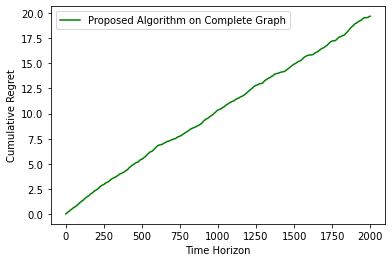

In [9]:
config = {}
config['T'] = 2000
config['L'] = 15
config['M'] = 5
config['c'] = 1
config['K'] = 2
config['c1'] = 20
config['h'] = 0.1
config['scale'] = 0.5
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])


n = config['M']         # number of agents
K = config['K']        # number of arms
m = 5         # number of phases
alpha = 4      # UCB parameter
itr=1         # Number of runs over the same instance for generating confidence plots
mu=config['mu']
t = config['T']            # length of time horizon, parametrized by m
rs=np.zeros((t,itr))  # regret for separate single agent playing the same MAB instance over all itr runs
rpa_comp=np.zeros((t,itr))  # regret per agent for complete graph over all itr runs

# adjacency matrix of complete graph
neighbor_comp=np.ones((n,n),int)    
np.fill_diagonal(neighbor_comp, 0)
regret = 0

for l in range(itr):
    j=1     # to keep track of which phase we are in
    ucb_score_single=np.Inf*np.ones(K)  # ucb score of a separate single agent playing the same MAB instance
    T_single=np.zeros(K)    # number of times an arm is played by the separate single agent playing the same MAB instance
    mu_bar_single=np.zeros(K)   # average mean reward of the arms estimated by the separate single agent playing the same MAB instance
    regret_single=np.zeros(t)   # regret incurred by the separate single agent playing the same MAB instance
    mu_bar_comp=np.zeros((K,n)) # average mean reward of the arms estimated by the agents connected by a complete graph
    T_comp=np.zeros((K,n))  # number of times an arm is played by the agents connected by a complete graph
    T_prev_comp=np.zeros((K,n)) # number of times an arm is played by the agents connected by a complete graph till the previous phase
    ucb_score_comp=np.Inf*np.ones((K,n))    # UCB scores of arms for agents connected by a complete graph 
    regret_comp=np.zeros((t,n)) # Regret incurred by agents connected by a complete graph
    arms_comp = stickyarms(n, K)    # Initializing the set maintained by agents connected by a complete graph
        
    for s in range(t):
        # UCB played by the separate single agent playing the same MAB instance
        idx_single=np.argmax(ucb_score_single)  # Selecting the arm with highest UCB score 
        #regret_single[s], ucb_score_single, mu_bar_single, T_single=ucb(mu, alpha, ucb_score_single, mu_bar_single, T_single, idx_single, s+1)
        # playing UCB with the arm chosen above
        
        # Multi-Agent UCB on complete graph
        for ag in range(n):
            idx_comp=arms_comp[np.argmax(ucb_score_comp[arms_comp[:,ag],ag]),ag] # Selecting the arm with highest UCB score among the set of arms maintained
            regret_comp[s,ag], ucb_score_comp[:, ag], mu_bar_comp[:, ag], T_comp[:, ag]=ucb(mu[ag,:], alpha, regret_comp[s-1,ag], ucb_score_comp[:,ag], mu_bar_comp[:,ag], T_comp[:,ag], idx_comp, s+1)
            # playing UCB with the arm chosen above

        # Pulling recommendation at the end of the phase          
        if s==(j**3)-1:
            delta_T_comp=T_comp-T_prev_comp  #  to keep track of how many times an arm is played in previous phase
            for ag in range(n):
                # Checking which arm out of U and L is played the least number of times and swapping them
                if (delta_T_comp[arms_comp[int(np.ceil(K/n)),ag],ag]<delta_T_comp[arms_comp[int(np.ceil(K/n)+1),ag],ag]):
                    tmp=arms_comp[int(np.ceil(K/n)),ag]
                    arms_comp[int(np.ceil(K/n)),ag]=arms_comp[int(np.ceil(K/n)+1),ag]
                    arms_comp[int(np.ceil(K/n)+1),ag]=tmp
                rec_id_comp=getarm(arms_comp,neighbor_comp,ag,delta_T_comp) # Recommendation received after pulling from one of the neighbors 
                if (np.size(np.where(arms_comp[:,ag]==rec_id_comp))==0):    # Checking whether the received recommendation is in the set of the arms maintained by ag or not
                    arms_comp[int(np.ceil(K/n))+1,ag]=rec_id_comp # if not present, replace it with L
            T_prev_comp=np.copy(T_comp) # Stores the number of times an arm was played till the previous phase by all agents
            j=j+1   # updating the phase
    
    #rs[:,l]=np.copy(regret_single)
    rpa_comp[:,l]=np.mean(regret_comp,axis=1)   # per agent regret for lth run

# computing mean and confidences for the regret incurred over time t over itr runs
#rs_avg=np.mean(rs,axis=1)   
#rs_lower=np.percentile(rs,2.5,axis=1)
#rs_upper=np.percentile(rs,97.5,axis=1)
rpa_comp_avg=np.mean(rpa_comp,axis=1)
rpa_comp_lower=np.percentile(rpa_comp,2.5,axis=1)
rpa_comp_upper=np.percentile(rpa_comp,97.5,axis=1)

x=np.arange(t)

# Plotting
#plt.plot(x,rs_avg,label='No Communication',color='b')
#plt.fill_between(x,rs_lower,rs_upper,color='b')
plt.plot(x,rpa_comp_avg,label='Proposed Algorithm on Complete Graph',color='g')
#plt.fill_between(x,rpa_comp_lower,rpa_comp_upper,color='g')
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

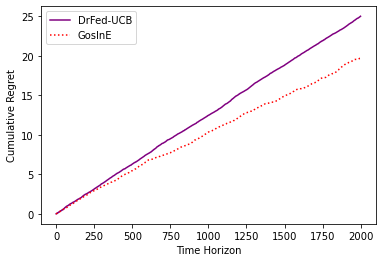

In [10]:
regret_t = [np.mean([bandit[i].regret_list[j] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
x=np.arange(t)

# Plotting
plt.plot(x,regret_t,label='DrFed-UCB',color='purple')
plt.plot(x,rpa_comp_avg,label='GosInE',linestyle=":",color='red')
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

Mean of mu is [0.125 0.15 ]
The second largest eigen value is 0.7500000000000006


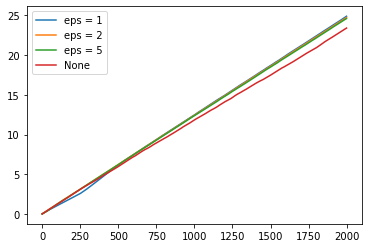

In [11]:
import numpy as np
import matplotlib.pyplot as plt

#------------ adjustable parameters ----------------
# setting-1


NumAgent = config['M']
NumArms = config['K'] 
Mu = config['mu'] 
NumTimeSlot = config['T']
epsilon = 10/np.log2(NumTimeSlot)
adj_list = []
for i in range(NumAgent):
    for j in range(NumAgent):
        if i != j:
            adj_list.append([i,j])
Graph = np.array(adj_list)


# # setting-2
# NumAgent = 5
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.5, 0.3,0.4,0.1,0.3,0.4,0.5, 0.2,0.9],[0.1, 0.2, 0.3,0.4,0.6,0.3,0.4,0.2, 0.2,0.9]]) 
# NumTimeSlot = 50000

# Graph = np.array([[1,2],[0,1],[0,2],[0,3],[0,4],[1,3],[1,4]])

# # setting-3
# NumAgent = 10
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.2, 0.3,0.4,0.5,0.6, 0.7, 0.1,0.4,0.96], [0.1, 0., 0.5,0.4,0.6,0.6, 0.1, 0.1,0.4,0.61], [0.1, 0.2, 0.,0.4,0.6,0.6, 0.8, 0.1,0.4,0.16],
# [0.1, 0.6, 0.,0.4,0.6,0.6, 0.2, 0.1,0.4,0.69], [0.1, 0.7, 0.1,0.4,0.6,0.6, 0.6, 0.1,0.4,0.99], [0.1, 0., 0.3,0.4,0.6,0.6, 0.2, 0.1,0.4,0.9],
# [0.1, 0.5, 0.,0.4,0.6,0.6, 0.3, 0.1,0.4,0.6]]) 
# NumTimeSlot = 10**5
# epsilon = 10/np.log2(NumTimeSlot)
# Graph = np.array([[1,2],[0,1],[0,2],[0,8],[0,9],[6,2],[3,2],[6,3],[5,6],[5,4],[5,7]])
#---------------------------------------------------
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def Cond(gt,n_min_k,t):
    cond_est = np.sqrt(gt/n_min_k)
    cond_gossip = np.sqrt(NumArms)/t**2 + 8*np.sqrt(NumArms) * np.log(t) / (n_min_k) + np.sqrt(gt/n_min_k)
    return 3*cond_gossip + cond_est

def CondC(n_ikt,t,lambda2,N,epsilon):
    # beta0 = 6/(np.log(1/lambda2)*(1-lambda2**(1/3))) * lambda2**(n_ikt/6)
    # return (1+beta0-2/N)*np.sqrt(2*N/n_ikt*np.log(t)) + lambda2**t
    if epsilon is None:
        return np.sqrt(2*N/n_ikt*np.log(t)) + lambda2**t
    else:
        # return np.sqrt((8*(N**2)*(np.log(NumTimeSlot)*np.log(2*n_ikt))**2/(epsilon**2)/n_ikt+N)*2/n_ikt*np.log(t)) + 2/(N*t**6)
        # return np.sqrt(  2*N * ((128*N * (np.log(NumTimeSlot) * np.log(n_ikt))**2 )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(NumTimeSlot) ) + lambda2**t
        return np.sqrt(  2*N * ((128/4/4*N * (np.log(NumTimeSlot)**2 * np.log(n_ikt) * np.log(t)) )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(t) ) + lambda2**t



def add_privacy_noise(X_sum_ik,x_bin_ik,epsilon,t): # Wrong one
    lbd = np.log2(NumTimeSlot)/epsilon
    idx = t+1
    bin_t = bin(idx)[2:]
    # bin_xlen = bin(len(x_bin_ik))[2:]
    X_sum = X_sum_ik
    if len(bin_t) > len(x_bin_ik):
        x_bin_ik = np.zeros(len(bin_t))
        x_bin_ik[0] = np.random.laplace(scale = lbd)
        return x_bin_ik[0] + X_sum, x_bin_ik
    else:
        for i in range(len(bin_t)):
            if bin_t[i] == '1' and x_bin_ik[i] != 0:
                X_sum += x_bin_ik[i]
            elif bin_t[i] == '1' and x_bin_ik[i] == 0:
                X_sum += np.random.laplace(scale = lbd)
            elif bin_t[i] == '0':
                x_bin_ik[i] = 0
        return X_sum, x_bin_ik



Mu_mean = np.mean(Mu,0)
print(f'Mean of mu is {Mu_mean}')
mu_max = np.max(Mu_mean)
W = np.zeros((NumAgent,NumAgent))
for i in Graph:
    ei = one_hot(i[0], NumAgent)
    ej = one_hot(i[1], NumAgent)
    W += np.eye(NumAgent) - 0.5*(ei-ej)*np.transpose([ei-ej])

W = W/len(Graph)
eigVal, _ = np.linalg.eig(W)
lambda2 = np.sort(eigVal)[-2]
print(f'The second largest eigen value is {lambda2}')


regret_rec = []
regret_rec_min = []
regret_rec_max = []
repeat_mark = 3
# for epsilon in [1/np.log2(NumTimeSlot), 2/np.log2(NumTimeSlot), 5/np.log2(NumTimeSlot), None]:
for epsilon in [1, 2, 5, None]:
# for epsilon in [5,None]:
    regret_rec_tmp = []
    np.random.seed(repeat_mark)
    for trial in range(25):
        #print(f'epsilon {epsilon}, trial {trial}')
        RandObservation = 1*np.random.randn(NumAgent,NumArms,NumTimeSlot)
        theta = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # gt = 4*np.log(np.linspace(0,NumTimeSlot,NumTimeSlot)+1)
        n_min_k = np.ones(NumArms)
        n_ik = np.ones((NumAgent,NumArms))
        I = np.zeros(NumArms)
        # tilde_X = np.zeros((NumAgent,NumArms))
        tilde_X = Mu + 1*np.random.randn(NumAgent,NumArms)
        X_sum_clean = tilde_X.copy()
        theta[:,:,0] = tilde_X.copy()
        # theta_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_rec = np.zeros((NumAgent,NumArms))  # for privacy noise
        # X_rec = [([0] * NumArms) for i in range(NumAgent)]
        # X_rec = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        X_rec_bin = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        # mse_rec = []
        if epsilon is not None:
            for i in range(NumAgent):
                for j in range(NumArms):
                    # X_rec[i][j].append(tilde_X[i,j]) 
                    X_rec_bin[i][j].append(tilde_X[i,j]+ np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon)) 
        

        regret = np.zeros((NumAgent,NumTimeSlot))
        regret_sum = np.zeros((NumAgent,NumTimeSlot))
        
        for t in range(1,NumTimeSlot):
            Edge = Graph[np.random.choice(range(len(Graph)),1,True)][0]
            # theta_vec_rec = theta_vec.copy()
            for i in range(NumAgent):
                k_sel_break = []
                for k in range(NumArms):
                    # I[k] = theta[i,k,t-1] + Cond(gt[t],n_min_k[k],t)
                    I[k] = theta[i,k,t-1] + CondC(n_ik[i,k],t,lambda2,NumAgent,epsilon)
                    if n_ik[i,k] < np.max(n_ik[:,k]) - NumAgent**2: # and np.random.uniform(size = 1)[0] > 1-1/NumAgent:
                        k_sel_break += [k]  
                # print(I)
                if k_sel_break:
                    k_sel = np.random.choice(k_sel_break,1,True)[0]
                else:
                    k_sel = np.argmax(I)
                # k_sel = np.argmax(I)
                regret[i,t] =  mu_max - Mu[i,k_sel]
                # regret[i,t] =  (k_sel!=4)
                regret_sum[i,t] = regret_sum[i,t-1] + regret[i,t]
                tilde_X_pre = tilde_X.copy()
                # X_vec_pre = X_vec.copy()
                # X_rec[i][k_sel].append(Mu[i,k_sel] + RandObservation[i,k_sel,t])  # record observations of agent-i arm-k
                # tilde_X[i,k_sel] = add_privacy_noise(X_rec[i][k_sel],epsilon)   # with differential privacy
                X_sum_clean[i,k_sel] += Mu[i,k_sel] + RandObservation[i,k_sel,t]
                if epsilon is None:
                    tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  # no privacy
                else:
                    # if np.log2(n_ik[i,k_sel] + 1) == np.round(np.log2(n_ik[i,k_sel] + 1)):    # with privacy
                    # X_rec_bin[i][k_sel] = 
                    tmpx,X_rec_bin[i][k_sel] = add_privacy_noise(X_sum_clean[i,k_sel], X_rec_bin[i][k_sel],epsilon,t)   # with differential privacy, clean, bin record, eps, t
                    tilde_X[i,k_sel] = tmpx/n_ik[i,k_sel]
                    # if np.log2(t) == np.round(np.log2(t)):    # with privacy
                    #     # tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = 1/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     # for j in range(NumArms):
                    #     #     tilde_X[i,j] += np.random.laplace(scale = 0.5* np.log2(NumTimeSlot)/epsilon/n_ik[i,j]) 
                    # else:
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  

                
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:] * n_ik[i,k_sel]
                # X_vec[i,k_sel,t] = Mu[i,k_sel] + RandObservation[i,k_sel,t]
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:]/(n_ik[i,k_sel]+1)
                n_ik[i,k_sel] += 1
                if i in Edge: # gossip update
                    theta[i,:,t] = (theta[Edge[0],:,t-1] + theta[Edge[1],:,t-1])/2 + tilde_X[i,:] - tilde_X_pre[i,:]
                    # theta_vec[i,:,:] = (theta_vec_rec[Edge[0],:,:] + theta_vec_rec[Edge[1],:,:])/2 + X_vec[i,:,:] - X_vec_pre[i,:,:]
                else:
                    theta[i,:,t] = theta[i,:,t-1] + tilde_X[i,:] - tilde_X_pre[i,:]
                    # theta_vec[i,:,:] = theta_vec_rec[i,:,:] + X_vec[i,:,:] - X_vec_pre[i,:,:]
            n_min_k = np.min(n_ik,0)
            # mse_rec += [np.sum(theta_vec**2)*np.min(n_min_k)]
            # print(theta[:,:,t])
        regret_rec_tmp += [np.mean(regret_sum,0)]
    regret_rec_tmp = np.array(regret_rec_tmp)
    regret_rec += [np.mean(regret_rec_tmp,0)]
    regret_rec_min += [np.min(regret_rec_tmp,0)]
    regret_rec_max += [np.max(regret_rec_tmp,0)]
# print(f'Mean of mu is {Mu_mean}')
# print(np.sum(theta_vec<0))
# plt.subplot(121)
plot_data = np.transpose(np.array(regret_rec))
plot_min = np.transpose(np.array(regret_rec_min))
plot_max = np.transpose(np.array(regret_rec_max))
x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data)
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.legend(['eps = 1','eps = 2','eps = 5','None'])
#for i in range(4):
    #plt.fill_between(x_axis,plot_min[:,i],plot_max[:,i],color='blue',alpha=0.25)
# plt.plot(np.transpose(np.array(regret_rec_min)))
# plt.plot(np.transpose(np.array(regret_rec_max)))
# plt.legend(['eps = 1','eps = 2','eps = 5','None'])
# plt.title('')
# plt.show()
# plt.subplot(122)
# plt.semilogy(np.mean(regret_sum,0))
# plt.savefig(f'result_10_{repeat_mark}.pdf')
# plt.show()
np.save(f"result_10_{repeat_mark}.npy",regret_rec)
np.save(f"result_10_min{repeat_mark}.npy",regret_rec_min)
np.save(f"result_10_max{repeat_mark}.npy",regret_rec_max)


In [12]:
!pip install svgpathtools
from svgpath2mpl import parse_path

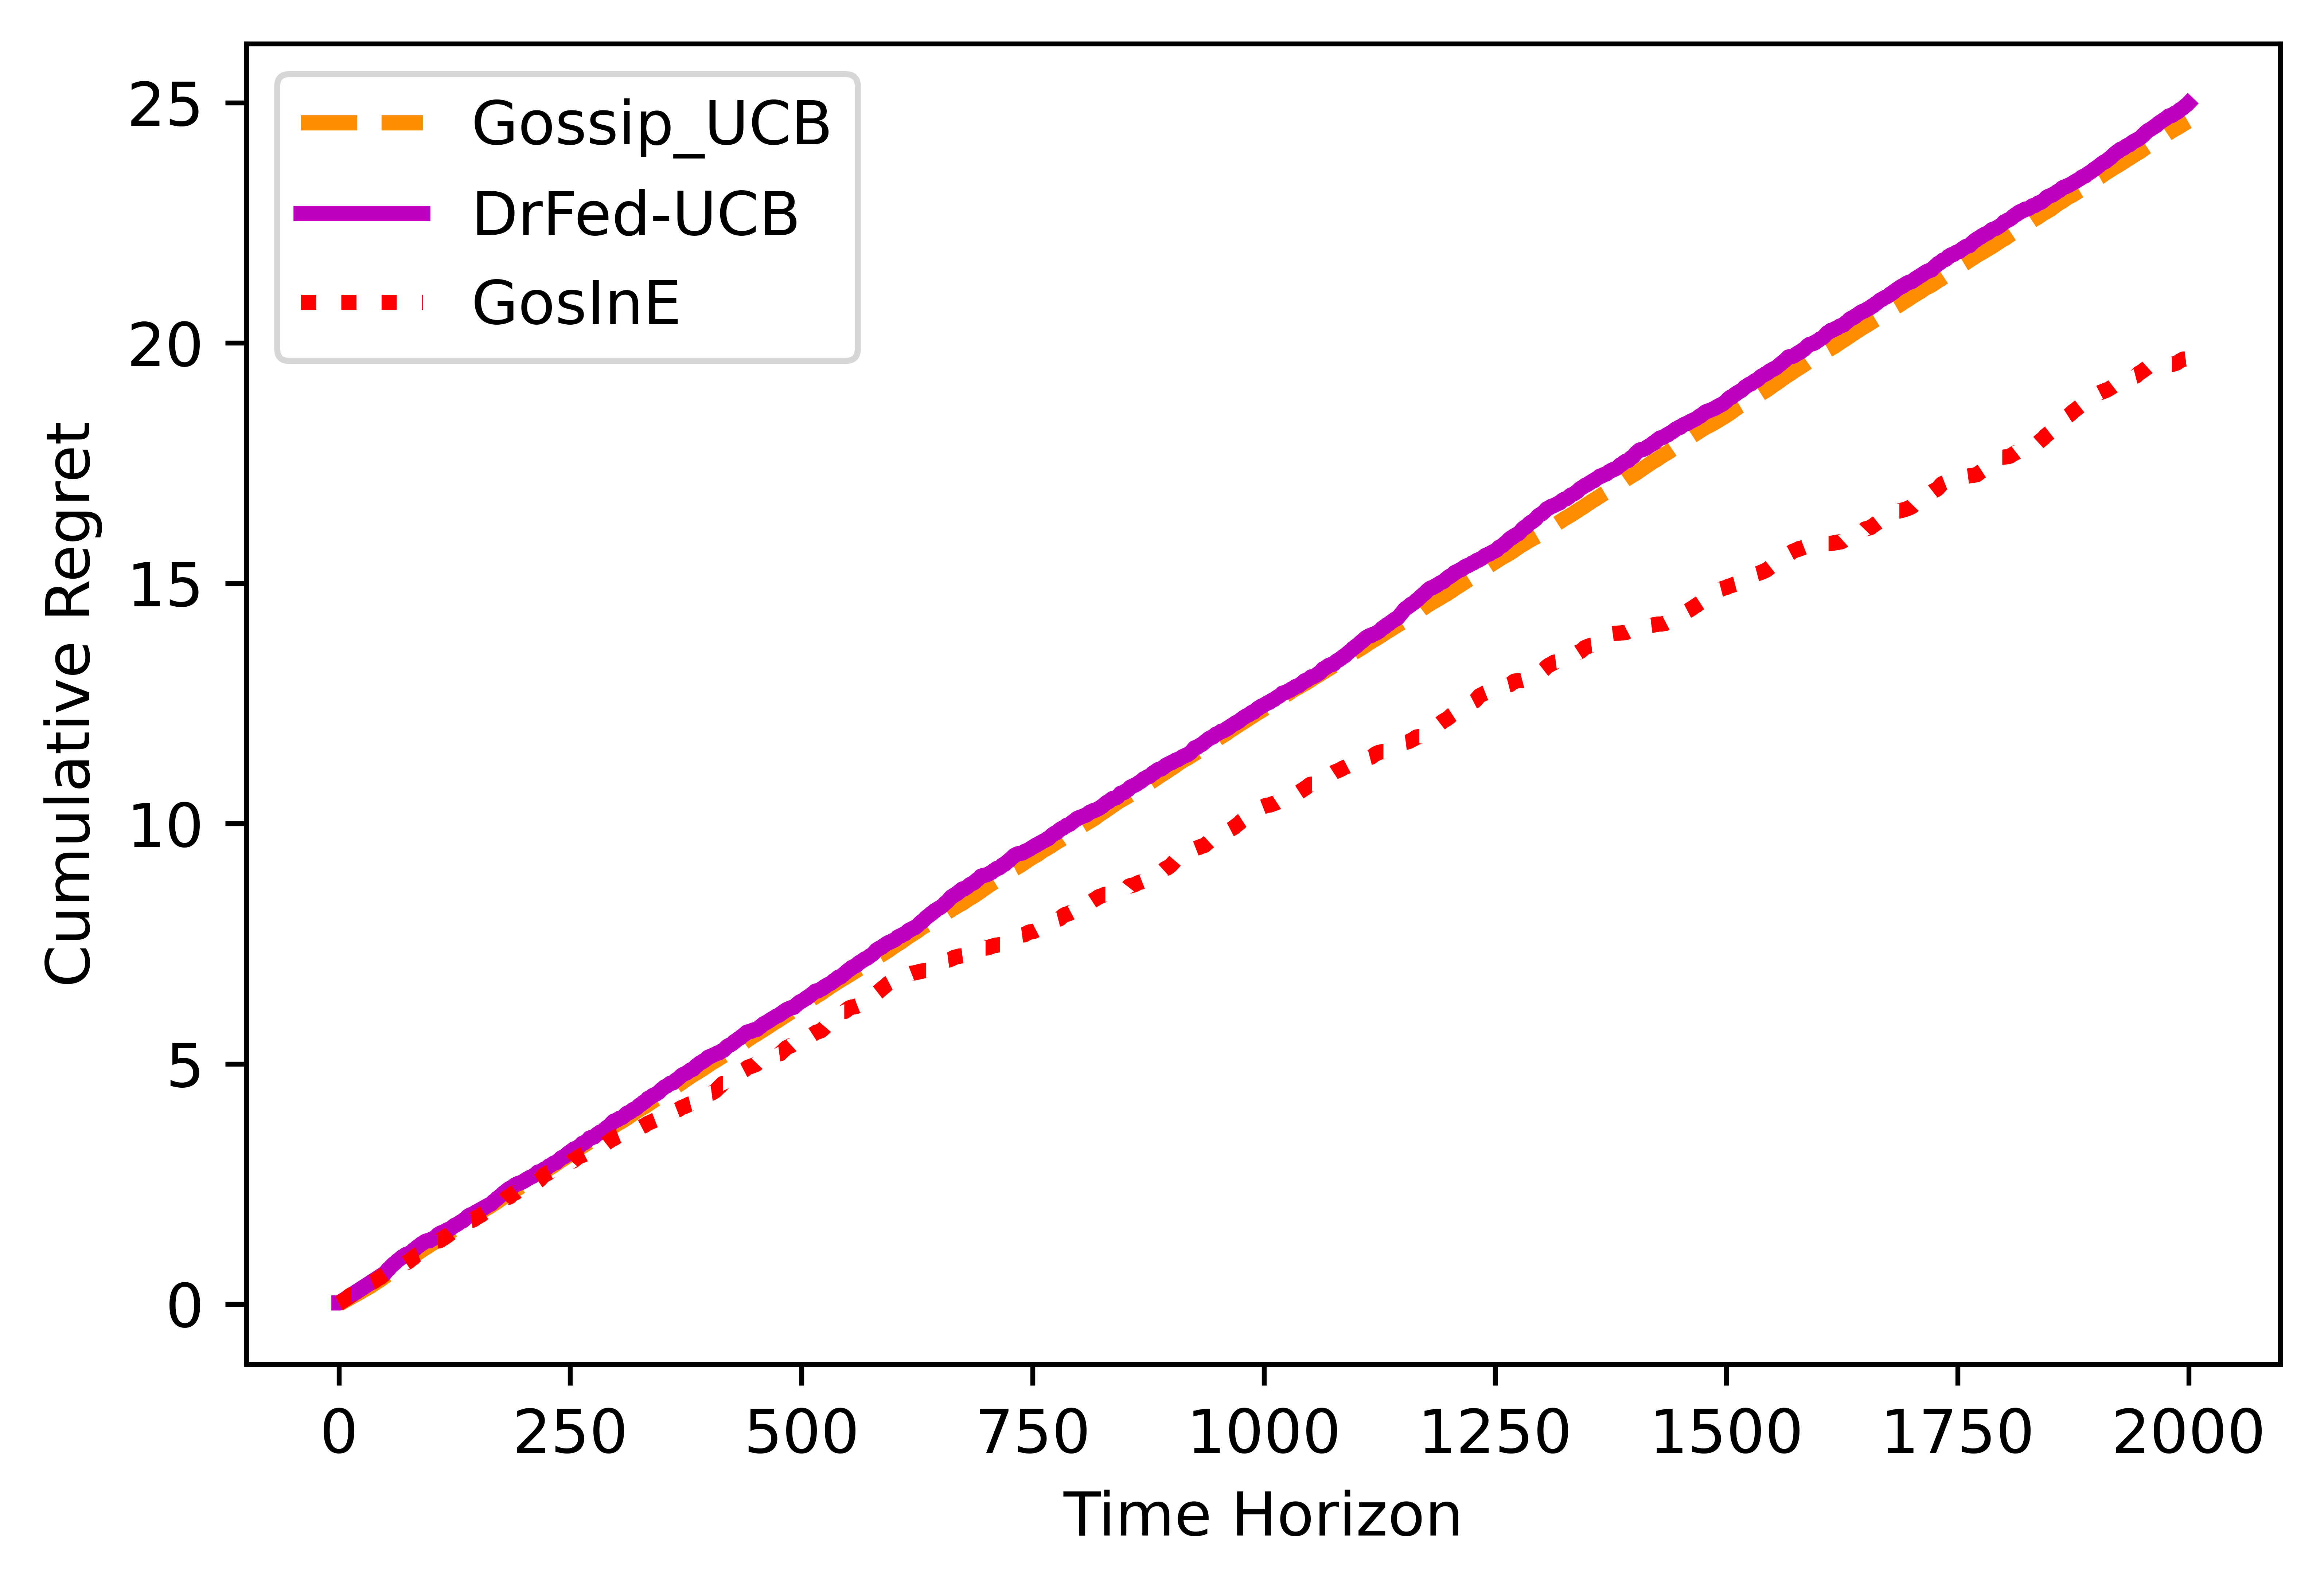

<Figure size 432x288 with 0 Axes>

In [13]:
#Visualization  
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

from numpy.random import randint


markers = ['\\alpha', '\\beta', '\gamma', '\sigma','\infty', \
            '\spadesuit', '\heartsuit', '\diamondsuit', '\clubsuit', \
            '\\bigodot', '\\bigotimes', '\\bigoplus', '\imath', '\\bowtie', \
            '\\bigtriangleup', '\\bigtriangledown', '\oslash' \
           '\ast', '\\times', '\circ', '\\bullet', '\star', '+', \
            '\Theta', '\Xi', '\Phi', \
            '\$', '\#', '\%', '\S']

def getRandomMarker():
    return "$"+markers[randint(0,len(markers),1)]+"$"

def getMarker(i):
    # Use modulus in order not to have the index exceeding the lenght of the list (markers)
    return "$"+markers[i % len(markers)]+"$"

plot_data = np.transpose(np.array(regret_rec))
plot_min = np.transpose(np.array(regret_rec_min))
plot_max = np.transpose(np.array(regret_rec_max))
x_axis = np.arange(len(plot_data))
plt.figure(dpi=1200)

plt.plot(x_axis,plot_data[:,2], label='Gossip_UCB',color='darkorange',linewidth = '2.5',linestyle = "--")
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1','eps = 2','eps = 5','None'])
#for i in range(4):
    #plt.fill_between(x_axis,plot_min[:,i],plot_max[:,i],color='blue',alpha=0.25)
# plt.plot(np.transpose(np.array(regret_rec_min)))
# plt.plot(np.transpose(np.array(regret_rec_max)))
# plt.legend(['eps = 1','eps = 2','eps = 5','None'])
# plt.title('')
# plt.show()
# plt.subplot(122)
# plt.semilogy(np.mean(regret_sum,0))
# plt.savefig(f'result_10_{repeat_mark}.pdf')
# plt.show()
np.save(f"result_10_{repeat_mark}.npy",regret_rec)
np.save(f"result_10_min{repeat_mark}.npy",regret_rec_min)
np.save(f"result_10_max{repeat_mark}.npy",regret_rec_max)

plt.plot(x,regret_t,label='DrFed-UCB',color='m', linewidth = '2.5')
plt.plot(x,rpa_comp_avg,label='GosInE',linestyle=":",color='red', linewidth = '2.5')
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.show()
plt.savefig('comp.png', dpi=300)

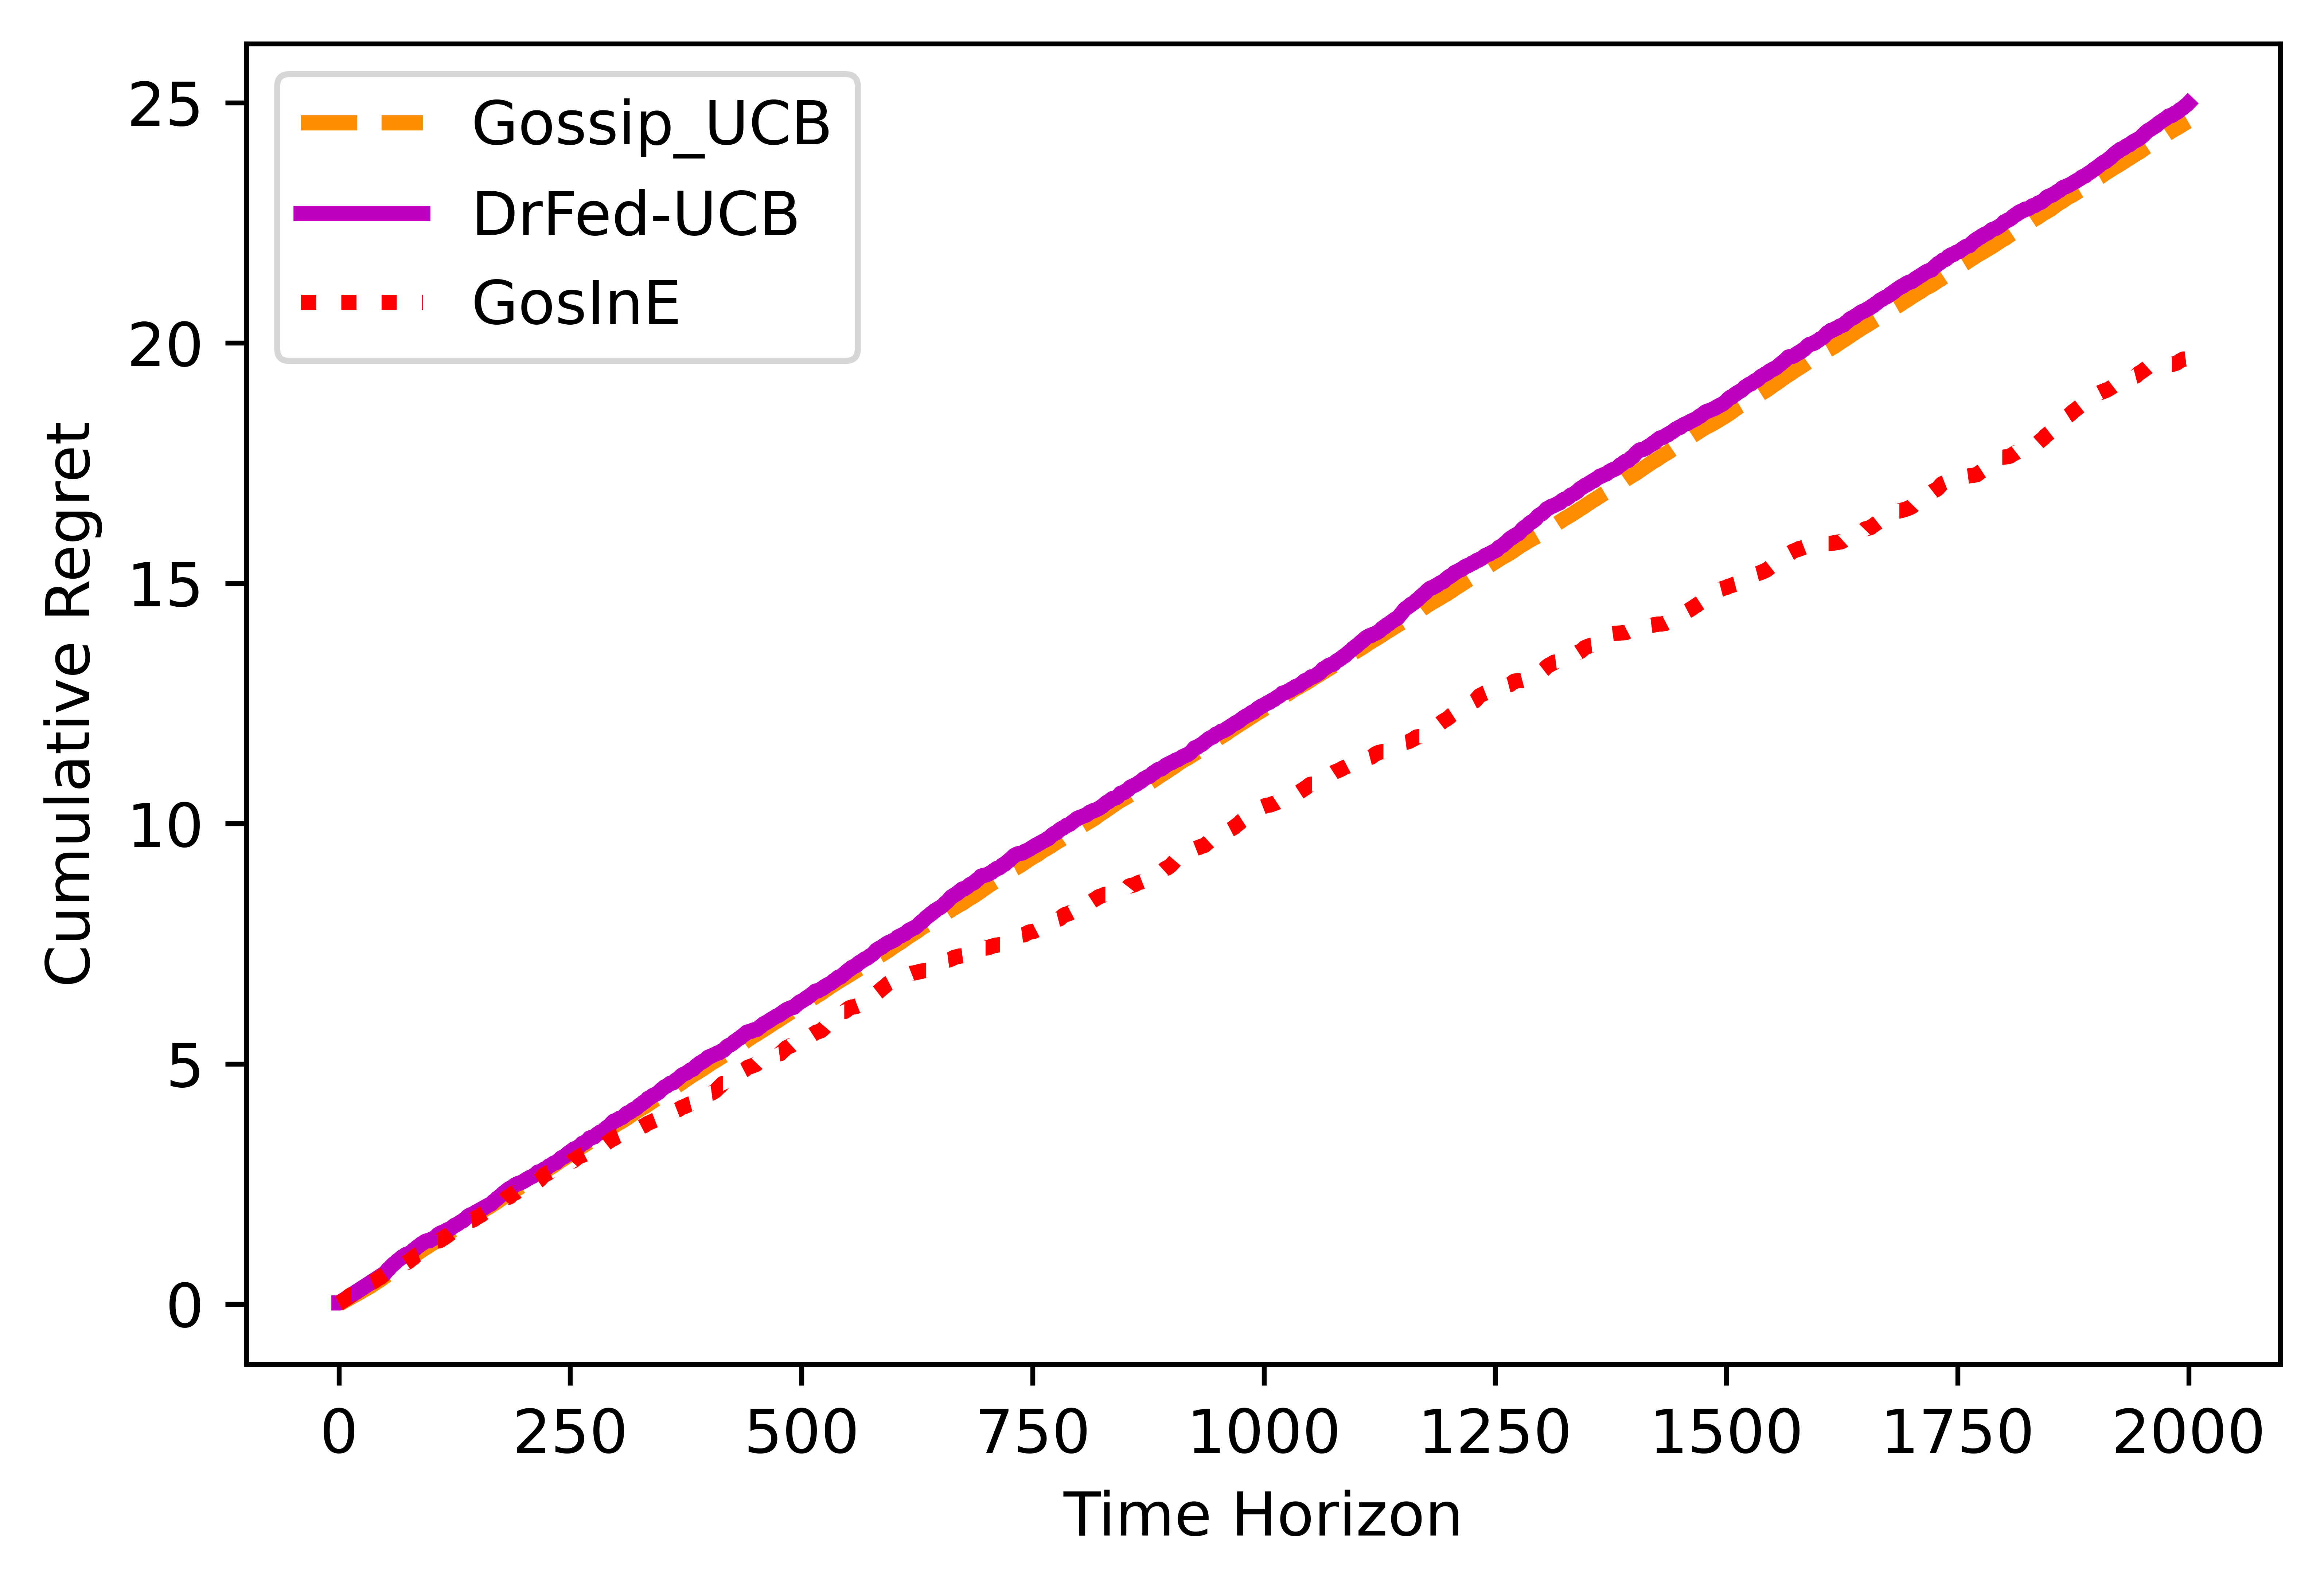

<Figure size 432x288 with 0 Axes>

In [14]:
#Visualization of communication cost  
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

from numpy.random import randint


markers = ['\\alpha', '\\beta', '\gamma', '\sigma','\infty', \
            '\spadesuit', '\heartsuit', '\diamondsuit', '\clubsuit', \
            '\\bigodot', '\\bigotimes', '\\bigoplus', '\imath', '\\bowtie', \
            '\\bigtriangleup', '\\bigtriangledown', '\oslash' \
           '\ast', '\\times', '\circ', '\\bullet', '\star', '+', \
            '\Theta', '\Xi', '\Phi', \
            '\$', '\#', '\%', '\S']

def getRandomMarker():
    return "$"+markers[randint(0,len(markers),1)]+"$"

def getMarker(i):
    # Use modulus in order not to have the index exceeding the lenght of the list (markers)
    return "$"+markers[i % len(markers)]+"$"

plot_data = np.transpose(np.array(regret_rec))
plot_min = np.transpose(np.array(regret_rec_min))
plot_max = np.transpose(np.array(regret_rec_max))
x_axis = np.arange(len(plot_data))
plt.figure(dpi=1200)

plt.plot(x_axis,plot_data[:,2], label='Gossip_UCB',color='darkorange',linewidth = '2.5',linestyle = "--")
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1','eps = 2','eps = 5','None'])
#for i in range(4):
    #plt.fill_between(x_axis,plot_min[:,i],plot_max[:,i],color='blue',alpha=0.25)
# plt.plot(np.transpose(np.array(regret_rec_min)))
# plt.plot(np.transpose(np.array(regret_rec_max)))
# plt.legend(['eps = 1','eps = 2','eps = 5','None'])
# plt.title('')
# plt.show()
# plt.subplot(122)
# plt.semilogy(np.mean(regret_sum,0))
# plt.savefig(f'result_10_{repeat_mark}.pdf')
# plt.show()
np.save(f"result_10_{repeat_mark}.npy",regret_rec)
np.save(f"result_10_min{repeat_mark}.npy",regret_rec_min)
np.save(f"result_10_max{repeat_mark}.npy",regret_rec_max)

plt.plot(x,regret_t,label='DrFed-UCB',color='m', linewidth = '2.5')
plt.plot(x,rpa_comp_avg,label='GosInE',linestyle=":",color='red', linewidth = '2.5')
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.show()
plt.savefig('comp.png', dpi=300)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#------------ adjustable parameters ----------------
# setting-1
#Simulation
config = {}
config['T'] = 2000
config['L'] = 50
config['M'] = 5
config['c'] = 1
config['K'] = 2
config['c1'] = 0.5
config['h'] = 0.1
config['scale'] = 0.2
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
config['sigma'] = config['scale']*np.ones((config['M'], config['K']))

NumAgent = config['M']
NumArms = config['K'] 
Mu = config['mu'] 
c = config['c']
NumTimeSlot = config['T']
epsilon = 10/np.log2(NumTimeSlot)
adj_list = []
for i in range(NumAgent):
    for j in range(NumAgent):
        if i != j:
            adj_list.append([i,j])
Graph = np.array(adj_list)


# # setting-2
# NumAgent = 5
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.5, 0.3,0.4,0.1,0.3,0.4,0.5, 0.2,0.9],[0.1, 0.2, 0.3,0.4,0.6,0.3,0.4,0.2, 0.2,0.9]]) 
# NumTimeSlot = 50000

# Graph = np.array([[1,2],[0,1],[0,2],[0,3],[0,4],[1,3],[1,4]])

# # setting-3
# NumAgent = 10
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.2, 0.3,0.4,0.5,0.6, 0.7, 0.1,0.4,0.96], [0.1, 0., 0.5,0.4,0.6,0.6, 0.1, 0.1,0.4,0.61], [0.1, 0.2, 0.,0.4,0.6,0.6, 0.8, 0.1,0.4,0.16],
# [0.1, 0.6, 0.,0.4,0.6,0.6, 0.2, 0.1,0.4,0.69], [0.1, 0.7, 0.1,0.4,0.6,0.6, 0.6, 0.1,0.4,0.99], [0.1, 0., 0.3,0.4,0.6,0.6, 0.2, 0.1,0.4,0.9],
# [0.1, 0.5, 0.,0.4,0.6,0.6, 0.3, 0.1,0.4,0.6]]) 
# NumTimeSlot = 10**5
# epsilon = 10/np.log2(NumTimeSlot)
# Graph = np.array([[1,2],[0,1],[0,2],[0,8],[0,9],[6,2],[3,2],[6,3],[5,6],[5,4],[5,7]])
#---------------------------------------------------
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def Cond(gt,n_min_k,t):
    cond_est = np.sqrt(gt/n_min_k)
    cond_gossip = np.sqrt(NumArms)/t**2 + 8*np.sqrt(NumArms) * np.log(t) / (n_min_k) + np.sqrt(gt/n_min_k)
    return 3*cond_gossip + cond_est

def CondC(n_ikt,t,lambda2,N,epsilon):
    # beta0 = 6/(np.log(1/lambda2)*(1-lambda2**(1/3))) * lambda2**(n_ikt/6)
    # return (1+beta0-2/N)*np.sqrt(2*N/n_ikt*np.log(t)) + lambda2**t
    if epsilon is None:
        return np.sqrt(2*N/n_ikt*np.log(t)) + lambda2**t
    else:
        # return np.sqrt((8*(N**2)*(np.log(NumTimeSlot)*np.log(2*n_ikt))**2/(epsilon**2)/n_ikt+N)*2/n_ikt*np.log(t)) + 2/(N*t**6)
        # return np.sqrt(  2*N * ((128*N * (np.log(NumTimeSlot) * np.log(n_ikt))**2 )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(NumTimeSlot) ) + lambda2**t
        return np.sqrt(  2*N * ((128/4/4*N * (np.log(NumTimeSlot)**2 * np.log(n_ikt) * np.log(t)) )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(t) ) + lambda2**t



def add_privacy_noise(X_sum_ik,x_bin_ik,epsilon,t): # Wrong one
    lbd = np.log2(NumTimeSlot)/epsilon
    idx = t+1
    bin_t = bin(idx)[2:]
    # bin_xlen = bin(len(x_bin_ik))[2:]
    X_sum = X_sum_ik
    if len(bin_t) > len(x_bin_ik):
        x_bin_ik = np.zeros(len(bin_t))
        x_bin_ik[0] = np.random.laplace(scale = lbd)
        return x_bin_ik[0] + X_sum, x_bin_ik
    else:
        for i in range(len(bin_t)):
            if bin_t[i] == '1' and x_bin_ik[i] != 0:
                X_sum += x_bin_ik[i]
            elif bin_t[i] == '1' and x_bin_ik[i] == 0:
                X_sum += np.random.laplace(scale = lbd)
            elif bin_t[i] == '0':
                x_bin_ik[i] = 0
        return X_sum, x_bin_ik



Mu_mean = np.mean(Mu,0)
print(f'Mean of mu is {Mu_mean}')
mu_max = np.max(Mu_mean)
W = np.zeros((NumAgent,NumAgent))
for i in Graph:
    ei = one_hot(i[0], NumAgent)
    ej = one_hot(i[1], NumAgent)
    W += np.eye(NumAgent) - 0.5*(ei-ej)*np.transpose([ei-ej])

W = W/len(Graph)
eigVal, _ = np.linalg.eig(W)
lambda2 = np.sort(eigVal)[-2]
print(f'The second largest eigen value is {lambda2}')
itr = 50    


regret_rec = []
regret_rec_var = []
regret_rec_lw = []
regret_rec_upp = []
repeat_mark = 3
# for epsilon in [1/np.log2(NumTimeSlot), 2/np.log2(NumTimeSlot), 5/np.log2(NumTimeSlot), None]:
for epsilon in [None]:
# for epsilon in [5,None]:
    regret_rec_tmp = []
    np.random.seed(repeat_mark)
    for trial in range(itr):
        #print(f'epsilon {epsilon}, trial {trial}')
        RandObservation = np.zeros((NumAgent,NumArms,NumTimeSlot))
        for i in range(NumAgent):
            for k in range(NumArms):
                RandObservation[i,k,:] = np.random.binomial(1,Mu[i,k],NumTimeSlot)
        theta = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # gt = 4*np.log(np.linspace(0,NumTimeSlot,NumTimeSlot)+1)
        n_min_k = np.ones(NumArms)
        n_ik = np.ones((NumAgent,NumArms))
        I = np.zeros((NumAgent,NumArms))
        # tilde_X = np.zeros((NumAgent,NumArms))
        for i in range(NumAgent):
            for k in range(NumArms):
                tilde_X[i,k] = np.random.binomial(1,Mu[i,k],1)
        X_sum_clean = tilde_X.copy()
        theta[:,:,0] = tilde_X.copy()
        # theta_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_rec = np.zeros((NumAgent,NumArms))  # for privacy noise
        # X_rec = [([0] * NumArms) for i in range(NumAgent)]
        # X_rec = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        X_rec_bin = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        # mse_rec = []
        if epsilon is not None:
            for i in range(NumAgent):
                for j in range(NumArms):
                    # X_rec[i][j].append(tilde_X[i,j]) 
                    X_rec_bin[i][j].append(tilde_X[i,j]+ np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon)) 
        

        regret = np.zeros((NumAgent,NumTimeSlot))
        regret_sum = np.zeros((NumAgent,NumTimeSlot))
        
        for t in range(1,NumTimeSlot):
            G = nx.erdos_renyi_graph(NumAgent,c,seed)
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            adj_pair = []
            for i in range(NumAgent):
                for j in range(NumAgent):
                    if i != j and j in neighbors[i]:
                        adj_pair.append([i,j])
            Graph = np.array(adj_pair)
            mu_max = np.max(Mu_mean)
            W = np.zeros((NumAgent,NumAgent))
            for i in Graph:
                ei = one_hot(i[0], NumAgent)
                ej = one_hot(i[1], NumAgent)
                W += np.eye(NumAgent) - 0.5*(ei-ej)*np.transpose([ei-ej])

            W = W/len(Graph)
            eigVal, _ = np.linalg.eig(W)
            lambda2 = np.sort(eigVal)[-2]
            #print(f'The second largest eigen value is {lambda2}')

            Edge = Graph[np.random.choice(range(len(Graph)),1,True)][0]
            #print(Edge)
            # theta_vec_rec = theta_vec.copy()
            for i in range(NumAgent):
                k_sel_break = []
                for k in range(NumArms):
                    # I[k] = theta[i,k,t-1] + Cond(gt[t],n_min_k[k],t)
                    I[i,k] = theta[i,k,t-1] + CondC(n_ik[i,k],t,lambda2,NumAgent,epsilon)
                    if n_ik[i,k] < np.max(n_ik[:,k]) - NumAgent**2: # and np.random.uniform(size = 1)[0] > 1-1/NumAgent:
                        k_sel_break += [k]  
                # print(I)
                if k_sel_break:
                    k_sel = np.random.choice(k_sel_break,1,True)[0]
                else:
                    k_sel = np.argmax(I[i,:])
                # k_sel = np.argmax(I)
                regret[i,t] =  mu_max - Mu[i,k_sel]
                # regret[i,t] =  (k_sel!=4)
                regret_sum[i,t] = regret_sum[i,t-1] + regret[i,t]
                tilde_X_pre = tilde_X.copy()
                # X_vec_pre = X_vec.copy()
                # X_rec[i][k_sel].append(Mu[i,k_sel] + RandObservation[i,k_sel,t])  # record observations of agent-i arm-k
                # tilde_X[i,k_sel] = add_privacy_noise(X_rec[i][k_sel],epsilon)   # with differential privacy
                X_sum_clean[i,k_sel] += RandObservation[i,k_sel,t]
                if epsilon is None:
                    tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  # no privacy
                else:
                    # if np.log2(n_ik[i,k_sel] + 1) == np.round(np.log2(n_ik[i,k_sel] + 1)):    # with privacy
                    # X_rec_bin[i][k_sel] = 
                    tmpx,X_rec_bin[i][k_sel] = add_privacy_noise(X_sum_clean[i,k_sel], X_rec_bin[i][k_sel],epsilon,t)   # with differential privacy, clean, bin record, eps, t
                    tilde_X[i,k_sel] = tmpx/n_ik[i,k_sel]
                    # if np.log2(t) == np.round(np.log2(t)):    # with privacy
                    #     # tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = 1/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     # for j in range(NumArms):
                    #     #     tilde_X[i,j] += np.random.laplace(scale = 0.5* np.log2(NumTimeSlot)/epsilon/n_ik[i,j]) 
                    # else:
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  

                
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:] * n_ik[i,k_sel]
                # X_vec[i,k_sel,t] = Mu[i,k_sel] + RandObservation[i,k_sel,t]
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:]/(n_ik[i,k_sel]+1)
                n_ik[i,k_sel] += 1
                if i in Edge: # gossip update
                    theta[i,:,t] = (theta[Edge[0],:,t-1] + theta[Edge[1],:,t-1])/2 + tilde_X[i,:] - tilde_X_pre[i,:]
                    # theta_vec[i,:,:] = (theta_vec_rec[Edge[0],:,:] + theta_vec_rec[Edge[1],:,:])/2 + X_vec[i,:,:] - X_vec_pre[i,:,:]
                else:
                    theta[i,:,t] = theta[i,:,t-1] + tilde_X[i,:] - tilde_X_pre[i,:]
                    # theta_vec[i,:,:] = theta_vec_rec[i,:,:] + X_vec[i,:,:] - X_vec_pre[i,:,:]
            n_min_k = np.min(n_ik,0)
            # mse_rec += [np.sum(theta_vec**2)*np.min(n_min_k)]
            # print(theta[:,:,t])
        regret_rec_tmp += [np.mean(regret_sum,0)]
    regret_rec_tmp = np.array(regret_rec_tmp)
    regret_rec.append(np.mean(regret_rec_tmp,0))
    
    regret_rec_upp.append(np.mean(regret_rec_tmp,0) +  1.96*np.sqrt(np.var(regret_rec_tmp,0))/np.sqrt(itr))
    regret_rec_lw.append(np.mean(regret_rec_tmp,0) - 1.96*np.sqrt(np.var(regret_rec_tmp,0))/np.sqrt(itr))
    
    regret_rec_min += [np.min(regret_rec_tmp,0)]
    regret_rec_max += [np.max(regret_rec_tmp,0)]
# print(f'Mean of mu is {Mu_mean}')
# print(np.sum(theta_vec<0))
# plt.subplot(121)


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Mean of mu is [0.125 0.15 ]
The second largest eigen value is 0.7500000000000006


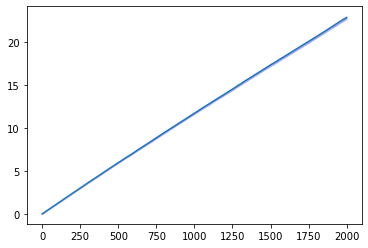

In [16]:
plot_data_s = np.transpose(np.array(regret_rec))
plot_min_s = np.transpose(np.array(regret_rec_lw))
plot_max_s = np.transpose(np.array(regret_rec_upp))
x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data_s)
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1'])
#for i in range(4):
plt.fill_between(x_axis,plot_min_s[:,0],plot_max_s[:,0],color='blue',alpha=0.25)
# plt.plot(np.transpose(np.array(regret_rec_min)))
# plt.plot(np.transpose(np.array(regret_rec_max)))
# plt.legend(['eps = 1','eps = 2','eps = 5','None'])
# plt.title('')
# plt.show()
# plt.subplot(122)
# plt.semilogy(np.mean(regret_sum,0))
# plt.savefig(f'result_10_{repeat_mark}.pdf')
# plt.show()
np.save(f"result_10_{repeat_mark}.npy",regret_rec)
np.save(f"result_10_min{repeat_mark}.npy",regret_rec_min)
np.save(f"result_10_max{repeat_mark}.npy",regret_rec_max)


In [17]:
#time varying graphs

import numpy as np
import matplotlib.pyplot as plt
import time
now = time.time()

#------------ adjustable parameters ----------------
# setting-1
#Simulation
config = {}
config['T'] = 2000
config['L'] = 50
config['M'] = 5
config['c'] = 1
config['K'] = 2
config['c1'] = 0.5
config['h'] = 0.1
config['scale'] = 0.2
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
config['sigma'] = config['scale']*np.ones((config['M'], config['K']))

NumAgent = config['M']
NumArms = config['K'] 
Mu = config['mu'] 
c = config['c']
NumTimeSlot = config['T']
epsilon = 10/np.log2(NumTimeSlot)
adj_list = []
for i in range(NumAgent):
    for j in range(NumAgent):
        if i != j:
            adj_list.append([i,j])
Graph = np.array(adj_list)


# # setting-2
# NumAgent = 5
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.5, 0.3,0.4,0.1,0.3,0.4,0.5, 0.2,0.9],[0.1, 0.2, 0.3,0.4,0.6,0.3,0.4,0.2, 0.2,0.9]]) 
# NumTimeSlot = 50000

# Graph = np.array([[1,2],[0,1],[0,2],[0,3],[0,4],[1,3],[1,4]])

# # setting-3
# NumAgent = 10
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.2, 0.3,0.4,0.5,0.6, 0.7, 0.1,0.4,0.96], [0.1, 0., 0.5,0.4,0.6,0.6, 0.1, 0.1,0.4,0.61], [0.1, 0.2, 0.,0.4,0.6,0.6, 0.8, 0.1,0.4,0.16],
# [0.1, 0.6, 0.,0.4,0.6,0.6, 0.2, 0.1,0.4,0.69], [0.1, 0.7, 0.1,0.4,0.6,0.6, 0.6, 0.1,0.4,0.99], [0.1, 0., 0.3,0.4,0.6,0.6, 0.2, 0.1,0.4,0.9],
# [0.1, 0.5, 0.,0.4,0.6,0.6, 0.3, 0.1,0.4,0.6]]) 
# NumTimeSlot = 10**5
# epsilon = 10/np.log2(NumTimeSlot)
# Graph = np.array([[1,2],[0,1],[0,2],[0,8],[0,9],[6,2],[3,2],[6,3],[5,6],[5,4],[5,7]])
#---------------------------------------------------
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def Cond(gt,n_min_k,t):
    cond_est = np.sqrt(gt/n_min_k)
    cond_gossip = np.sqrt(NumArms)/t**2 + 8*np.sqrt(NumArms) * np.log(t) / (n_min_k) + np.sqrt(gt/n_min_k)
    return 3*cond_gossip + cond_est

def CondC(n_ikt,t,lambda2,N,epsilon):
    # beta0 = 6/(np.log(1/lambda2)*(1-lambda2**(1/3))) * lambda2**(n_ikt/6)
    # return (1+beta0-2/N)*np.sqrt(2*N/n_ikt*np.log(t)) + lambda2**t
    if epsilon is None:
        return (1+0.01)*np.sqrt(3*np.log(t)/(N*n_ikt)) + 1/(2*t)
    else:
        # return np.sqrt((8*(N**2)*(np.log(NumTimeSlot)*np.log(2*n_ikt))**2/(epsilon**2)/n_ikt+N)*2/n_ikt*np.log(t)) + 2/(N*t**6)
        # return np.sqrt(  2*N * ((128*N * (np.log(NumTimeSlot) * np.log(n_ikt))**2 )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(NumTimeSlot) ) + lambda2**t
        return np.sqrt(  2*N * ((128/4/4*N * (np.log(NumTimeSlot)**2 * np.log(n_ikt) * np.log(t)) )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(t) ) + lambda2**t



def add_privacy_noise(X_sum_ik,x_bin_ik,epsilon,t): # Wrong one
    lbd = np.log2(NumTimeSlot)/epsilon
    idx = t+1
    bin_t = bin(idx)[2:]
    # bin_xlen = bin(len(x_bin_ik))[2:]
    X_sum = X_sum_ik
    if len(bin_t) > len(x_bin_ik):
        x_bin_ik = np.zeros(len(bin_t))
        x_bin_ik[0] = np.random.laplace(scale = lbd)
        return x_bin_ik[0] + X_sum, x_bin_ik
    else:
        for i in range(len(bin_t)):
            if bin_t[i] == '1' and x_bin_ik[i] != 0:
                X_sum += x_bin_ik[i]
            elif bin_t[i] == '1' and x_bin_ik[i] == 0:
                X_sum += np.random.laplace(scale = lbd)
            elif bin_t[i] == '0':
                x_bin_ik[i] = 0
        return X_sum, x_bin_ik



Mu_mean = np.mean(Mu,0)
print(f'Mean of mu is {Mu_mean}')
mu_max = np.max(Mu_mean)
W = np.zeros((NumAgent,NumAgent))
for i in Graph:
    ei = one_hot(i[0], NumAgent)
    ej = one_hot(i[1], NumAgent)
    W += np.eye(NumAgent) - 0.5*(ei-ej)*np.transpose([ei-ej])

W = W/len(Graph)
eigVal, _ = np.linalg.eig(W)
lambda2 = np.sort(eigVal)[-2]
print(f'The second largest eigen value is {lambda2}')
itr = 50    


regret_rec = []
regret_rec_var = []
regret_rec_lw = []
regret_rec_upp = []
repeat_mark = 3
# for epsilon in [1/np.log2(NumTimeSlot), 2/np.log2(NumTimeSlot), 5/np.log2(NumTimeSlot), None]:
for epsilon in [None]:
# for epsilon in [5,None]:
    regret_rec_tmp = []
    np.random.seed(repeat_mark)
    for trial in range(itr):
        #print(f'epsilon {epsilon}, trial {trial}')
        RandObservation = np.zeros((NumAgent,NumArms,NumTimeSlot))
        for i in range(NumAgent):
            for k in range(NumArms):
                RandObservation[i,k,:] = np.random.binomial(1,Mu[i,k],NumTimeSlot)
        theta = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # gt = 4*np.log(np.linspace(0,NumTimeSlot,NumTimeSlot)+1)
        n_min_k = np.ones(NumArms)
        n_ik = np.ones((NumAgent,NumArms))
        m = np.ones((NumAgent,NumArms))
        I = np.zeros((NumAgent,NumArms))
        tilde_X = np.zeros((NumAgent,NumArms))
        for i in range(NumAgent):
            for k in range(NumArms):
                tilde_X[i,k] = np.random.binomial(1,Mu[i,k],1)
        X_sum_clean = tilde_X.copy()
        theta[:,:,0] = tilde_X.copy()
        # theta_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_rec = np.zeros((NumAgent,NumArms))  # for privacy noise
        # X_rec = [([0] * NumArms) for i in range(NumAgent)]
        # X_rec = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        X_rec_bin = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        # mse_rec = []
        if epsilon is not None:
            for i in range(NumAgent):
                for j in range(NumArms):
                    # X_rec[i][j].append(tilde_X[i,j]) 
                    X_rec_bin[i][j].append(tilde_X[i,j]+ np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon)) 
        

        regret = np.zeros((NumAgent,NumTimeSlot))
        regret_sum = np.zeros((NumAgent,NumTimeSlot))
        
        for t in range(1,NumTimeSlot):
            G = nx.erdos_renyi_graph(NumAgent,c)
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            adj_pair = []
            for i in range(NumAgent):
                for j in range(NumAgent):
                    if i != j and j in neighbors[i]:
                        adj_pair.append([i,j])
            Graph = np.array(adj_pair)
            mu_max = np.max(Mu_mean)
            W = np.zeros((NumAgent,NumAgent))
            for i in Graph:
                ei = one_hot(i[0], NumAgent)
                ej = one_hot(i[1], NumAgent)
                W += np.eye(NumAgent) - 0.5*(ei-ej)*np.transpose([ei-ej])

            W = W/len(Graph)
            eigVal, _ = np.linalg.eig(W)
            lambda2 = np.sort(eigVal)[-2]
            #print(f'The second largest eigen value is {lambda2}')

            Edge = Graph[np.random.choice(range(len(Graph)),1,True)][0]
            #print(Edge)
            # theta_vec_rec = theta_vec.copy()
            for i in range(NumAgent):
                k_sel_break = []
                for k in range(NumArms):
                    # I[k] = theta[i,k,t-1] + Cond(gt[t],n_min_k[k],t)
                    I[i,k] = theta[i,k,t-1] + CondC(n_ik[i,k],t,lambda2,len(neighbors[i]),epsilon)
                    if n_ik[i,k] < m[i,k] - NumArms**2: # and np.random.uniform(size = 1)[0] > 1-1/NumAgent:
                        k_sel_break += [k]  
                # print(I)
                if k_sel_break:
                    k_sel = np.random.choice(k_sel_break,1,True)[0]
                else:
                    k_sel = np.argmax(I[i,:])
                # k_sel = np.argmax(I)
                regret[i,t] =  Mu[i,-1] - Mu[i,k_sel]
                # regret[i,t] =  (k_sel!=4)
                regret_sum[i,t] = regret_sum[i,t-1] + regret[i,t]
                tilde_X_pre = tilde_X.copy()
                # X_vec_pre = X_vec.copy()
                # X_rec[i][k_sel].append(Mu[i,k_sel] + RandObservation[i,k_sel,t])  # record observations of agent-i arm-k
                # tilde_X[i,k_sel] = add_privacy_noise(X_rec[i][k_sel],epsilon)   # with differential privacy
                X_sum_clean[i,k_sel] +=  RandObservation[i,k_sel,t]
                if epsilon is None:
                    tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  # no privacy
                else:
                    # if np.log2(n_ik[i,k_sel] + 1) == np.round(np.log2(n_ik[i,k_sel] + 1)):    # with privacy
                    # X_rec_bin[i][k_sel] = 
                    tmpx,X_rec_bin[i][k_sel] = add_privacy_noise(X_sum_clean[i,k_sel], X_rec_bin[i][k_sel],epsilon,t)   # with differential privacy, clean, bin record, eps, t
                    tilde_X[i,k_sel] = tmpx/n_ik[i,k_sel]
                    # if np.log2(t) == np.round(np.log2(t)):    # with privacy
                    #     # tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = 1/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     # for j in range(NumArms):
                    #     #     tilde_X[i,j] += np.random.laplace(scale = 0.5* np.log2(NumTimeSlot)/epsilon/n_ik[i,j]) 
                    # else:
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  

                
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:] * n_ik[i,k_sel]
                # X_vec[i,k_sel,t] = Mu[i,k_sel] + RandObservation[i,k_sel,t]
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:]/(n_ik[i,k_sel]+1)
                n_ik[i,k_sel] += 1
                for k in range(NumArms):
                    theta[i,k,t] = sum([theta[j,k,t-1]*W[i,j] for j in neighbors[i]]) + tilde_X[i,k] - tilde_X_pre[i,k]
                    m[i,k] = max(max([m[j,k] for j in neighbors[i]]), n_ik[i,k])
                    # theta_vec[i,:,:] = (theta_vec_rec[Edge[0],:,:] + theta_vec_rec[Edge[1],:,:])/2 + X_vec[i,:,:] - X_vec_pre[i,:,:]
                #else:
                    #theta[i,:,t] = theta[i,:,t-1] + tilde_X[i,:] - tilde_X_pre[i,:]
                    # theta_vec[i,:,:] = theta_vec_rec[i,:,:] + X_vec[i,:,:] - X_vec_pre[i,:,:]
            #n_min_k = np.min(n_ik,0)
            # mse_rec += [np.sum(theta_vec**2)*np.min(n_min_k)]
            # print(theta[:,:,t])
        regret_rec_tmp += [np.mean(regret_sum,0)]
    regret_rec_tmp = np.array(regret_rec_tmp)
    regret_rec.append([np.mean(regret_rec_tmp,0)])
    
    regret_rec_upp.append([np.percentile(regret_rec_tmp,95,axis=0)])
    regret_rec_lw.append([np.percentile(regret_rec_tmp,5,axis=0)])
    #regret_rec_lw.append(np.mean(regret_rec_tmp,0) - 1.96*np.sqrt(np.var(regret_rec_tmp,0))/np.sqrt(itr))
    
    regret_rec_min += [np.min(regret_rec_tmp,0)]
    regret_rec_max += [np.max(regret_rec_tmp,0)]
    
later = time.time()
difference = int(later - now)
print(difference)
# print(f'Mean of mu is {Mu_mean}')
# print(np.sum(theta_vec<0))
# plt.subplot(121)



[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Mean of mu is [0.125 0.15 ]
The second largest eigen value is 0.7500000000000006
47


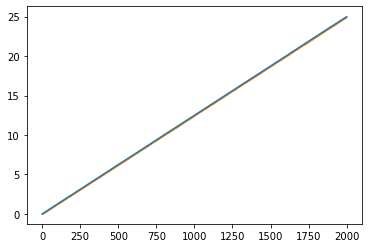

In [18]:
plot_data = np.transpose(np.array(regret_rec))
plot_min = np.transpose(np.array(regret_rec_lw))
plot_max = np.transpose(np.array(regret_rec_upp))
x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1))
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='darkorange')

#plt.legend(['eps = 1'])
#for i in range(4):
    #plt.fill_between(x_axis,plot_min[:,i],plot_max[:,i],color='blue',alpha=0.25)
# plt.plot(np.transpose(np.array(regret_rec_min)))
# plt.plot(np.transpose(np.array(regret_rec_max)))
# plt.legend(['eps = 1','eps = 2','eps = 5','None'])
# plt.title('')
# plt.show()
# plt.subplot(122)
# plt.semilogy(np.mean(regret_sum,0))
# plt.savefig(f'result_10_{repeat_mark}.pdf')
# plt.show()

In [19]:
#Gossip_UCB
import warnings

warnings.filterwarnings("ignore")


def stickyarms(n, K):       # Initializing the set maintained by the agents
    arms = np.zeros((np.int(np.ceil(K/n)+2), n))
    for p in range(n):
        for q in range(np.int(np.ceil(K/n)+2)):
            if (np.mod(p*np.ceil(K/n),K)+q+1 > K):
                arms[q,p] = np.mod(np.mod(p*np.ceil(K/n),K)+q+1-K,K)
            else:
                arms[q,p] = np.mod(p*np.ceil(K/n),K)+q+1
    arms=arms-1
    return arms.astype(np.int64)
# Structure of the set maintained by the agents:
# Columns denote the agents, where each agent has ceil(K/n)+2 arms, thus ceil(K/n)+2 rows.
# The first ceil(K/n) arms maintained by every agent constitute its sticky set,
# which remains fixed at all times.
# The ceil(K/n)+1 th arm is U and ceil(K/n)+2 th arm is L.
# U is updated by choosing the most played arm among U and L in a phase.
# L is the least played arm in previous phase, which will be replaced by the recommendation pulled by the agent
# at the end of a phase.


def ucb(mu, alpha, regret, ucb_score, mu_bar, T, idx, s):   # Subroutine which plays UCB for the chosen arm
    T[idx]=T[idx]+1         # Number of times the arm being played incremented by 1
    if np.random.rand() <= mu[idx]:     # When a reward of 1 is received after playing the arm
        mu_bar[idx]=(((T[idx]-1)*mu_bar[idx])+1)/T[idx]
    else:            # When a reward of 0 is received after playing the arm
        mu_bar[idx]=((T[idx]-1)*mu_bar[idx])/T[idx]
    regret=regret+(mu[-1]-mu[idx])     # Regret incurred 
    ucb_score=mu_bar+np.sqrt(alpha*np.log(s+1)/T);  # Updating UCB score for next time step
    return regret, ucb_score, mu_bar, T

#Note: this getarm function routine takes the adjacency matrix of the graph as input
#and works only for the case when the neighbors of the agent are chosen equally likely.
#For a general gossip matrix P, this getarm function has to be modified
#to pick the agent sampled from P(.,ag) from where ag pulls a recommendation 
def getarm(arms, neighbor, ag, delta_T):
    nb=np.nonzero(neighbor[:,ag])[0] # neighbors of agent ag
    rec_ag=nb[np.random.randint(np.size(nb))] # picking the neighbor whose best arm recommendation will be pulled by ag  
    rec_id=arms[np.argmax(delta_T[arms[:,rec_ag],rec_ag]),rec_ag]  #  estimated best arm of the neighbor picked by ag
    return rec_id        

In [20]:

now = time.time()
config = {}
config['T'] = 2000
config['L'] = 15
config['M'] = 5
config['c'] = 1
config['K'] = 2
config['c1'] = 20
config['h'] = 0.1
config['scale'] = 0.5
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])


n = config['M']         # number of agents
K = config['K']        # number of arms
m = 5         # number of phases
alpha = 4      # UCB parameter
itr=50         # Number of runs over the same instance for generating confidence plots
mu=config['mu']
t = config['T']            # length of time horizon, parametrized by m
rs=np.zeros((t,itr))  # regret for separate single agent playing the same MAB instance over all itr runs
rpa_comp=np.zeros((t,itr))  # regret per agent for complete graph over all itr runs

# adjacency matrix of complete graph
neighbor_comp=np.ones((n,n),int)    
np.fill_diagonal(neighbor_comp, 0)
regret = 0

for l in range(itr):
    j=1     # to keep track of which phase we are in
    ucb_score_single=np.Inf*np.ones(K)  # ucb score of a separate single agent playing the same MAB instance
    T_single=np.zeros(K)    # number of times an arm is played by the separate single agent playing the same MAB instance
    mu_bar_single=np.zeros(K)   # average mean reward of the arms estimated by the separate single agent playing the same MAB instance
    regret_single=np.zeros(t)   # regret incurred by the separate single agent playing the same MAB instance
    mu_bar_comp=np.zeros((K,n)) # average mean reward of the arms estimated by the agents connected by a complete graph
    T_comp=np.zeros((K,n))  # number of times an arm is played by the agents connected by a complete graph
    T_prev_comp=np.zeros((K,n)) # number of times an arm is played by the agents connected by a complete graph till the previous phase
    ucb_score_comp=np.Inf*np.ones((K,n))    # UCB scores of arms for agents connected by a complete graph 
    regret_comp=np.zeros((t,n)) # Regret incurred by agents connected by a complete graph
    arms_comp = stickyarms(n, K)    # Initializing the set maintained by agents connected by a complete graph
        
    for s in range(t):
        # UCB played by the separate single agent playing the same MAB instance
        idx_single=np.argmax(ucb_score_single)  # Selecting the arm with highest UCB score 
        #regret_single[s], ucb_score_single, mu_bar_single, T_single=ucb(mu, alpha, ucb_score_single, mu_bar_single, T_single, idx_single, s+1)
        # playing UCB with the arm chosen above
        
        # Multi-Agent UCB on complete graph
        for ag in range(n):
            idx_comp=arms_comp[np.argmax(ucb_score_comp[arms_comp[:,ag],ag]),ag] # Selecting the arm with highest UCB score among the set of arms maintained
            regret_comp[s,ag], ucb_score_comp[:, ag], mu_bar_comp[:, ag], T_comp[:, ag]=ucb(mu[ag,:], alpha, regret_comp[s-1,ag], ucb_score_comp[:,ag], mu_bar_comp[:,ag], T_comp[:,ag], idx_comp, s+1)
            # playing UCB with the arm chosen above

        # Pulling recommendation at the end of the phase          
        if s==(j**3)-1:
            delta_T_comp=T_comp-T_prev_comp  #  to keep track of how many times an arm is played in previous phase
            for ag in range(n):
                # Checking which arm out of U and L is played the least number of times and swapping them
                if (delta_T_comp[arms_comp[int(np.ceil(K/n)),ag],ag]<delta_T_comp[arms_comp[int(np.ceil(K/n)+1),ag],ag]):
                    tmp=arms_comp[int(np.ceil(K/n)),ag]
                    arms_comp[int(np.ceil(K/n)),ag]=arms_comp[int(np.ceil(K/n)+1),ag]
                    arms_comp[int(np.ceil(K/n)+1),ag]=tmp
                rec_id_comp=getarm(arms_comp,neighbor_comp,ag,delta_T_comp) # Recommendation received after pulling from one of the neighbors 
                if (np.size(np.where(arms_comp[:,ag]==rec_id_comp))==0):    # Checking whether the received recommendation is in the set of the arms maintained by ag or not
                    arms_comp[int(np.ceil(K/n))+1,ag]=rec_id_comp # if not present, replace it with L
            T_prev_comp=np.copy(T_comp) # Stores the number of times an arm was played till the previous phase by all agents
            j=j+1   # updating the phase
    
    #rs[:,l]=np.copy(regret_single)
    rpa_comp[:,l]=np.mean(regret_comp,axis=1)   # per agent regret for lth run

# computing mean and confidences for the regret incurred over time t over itr runs
later = time.time()
difference = int(later - now)
print(difference)


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
7


In [67]:
#newly proposed algorithm
#sub-gaussian 
class Environment:
    def __init__(self, config):
        self.T = config['T']
        self.M = config['M']
        self.c = config['c']

        self.mu = config['mu']
        self.sigma = config['sigma']
        self.h = config['h']
        #self.mu_opt_M = np.sort(self.mu)[-self.M:]
        self.K = config['K']
        logger.info(f"Created environment with M = {self.M}, mu = {self.mu},h= {self.h}, T = {self.T}, K = {self.K}")

    def __str__(self):
        return f"M{self.M}-K{self.K}-mu{str(self.mu)}"

    def update(self, t):
        pass

    def draw(self, arms, sensing=False):
        counts = collections.Counter(arms)
        rewards = np.zeros((self.M,))
        for player in range(self.M):
            #rewards[player] = np.random.normal(self.mu[player,arms[player]], self.sigma[player, arms[player]])
            if np.random.rand() <= self.mu[player,arms[player]]:
                rewards[player]=1
            else:
                rewards[player]=0
            #rewards[player] = np.random.binomial(1, self.mu[player,arms[player]], 1)
        graph = nx.erdos_renyi_graph(self.M,self.c,seed)


        return rewards, graph

class LocalMAB:
    def __init__(self, num_agents, num_arms):
        self.num_arms = num_arms
        #self.true_reward_means = true_reward_means
        self.q_local = np.zeros(num_arms)  # Estimated action values
        self.q_network = np.zeros(num_arms)  # Estimated action values
        self.q_var = np.zeros(num_arms)
        self.counts_local = np.zeros(num_arms)  # Counts of each action taken
        self.counts_network = np.zeros(num_arms)  # Counts of each action taken
        self.total_reward = 0
        self.c1 = 4
        self.c2 = 0
        self.epsilon = 0.1  # Exploration rate
        self.P = np.zeros(num_agents)
        self.P1 = np.zeros(num_agents)
        self.ucb = 0
        self.M = num_agents
        self.comm_reward = {}
        self.comm_counts = {}
        self.comm_reward_network = {}
        self.comm_counts_network = {}
        self.tmp = {}
        self.exp_reward = 0
        self.exp_reward_list = []
        self.regret = 0
        self.regret_list = []


    def choose_action(self, t, flag, c1):
        if flag:  # Corrected condition
            # Explore with probability epsilon
            return np.random.choice(self.num_arms)
        else:
            # Exploit the current estimates
            #self.counts_local[i]
            self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]
            self.ucb = [(self.q_network[i]+ self.q_var[i]) for i in range(len(self.q_network))]
            return np.argmax(self.ucb)

    def update(self, chosen_action, reward, exp_reward):
        # Update action values using sample-average method
        self.counts_local[chosen_action] += 1
        self.q_local[chosen_action] = (reward + self.q_local[chosen_action]*(self.counts_local[chosen_action]-1)) / self.counts_local[chosen_action]  # Corrected action counts
        self.total_reward += reward
        self.exp_reward += exp_reward
        self.exp_reward_list.append(self.exp_reward)
    
    def update_global(self, chosen_action, reward):
        # Update action values using sample-average method
        #self.counts_local[chosen_action] += 1
        a = 0
        for i in range(self.num_arms):  # Corrected loop
            for j in range(self.M):
                if self.P[j] >0:
                    a = max(self.comm_counts[j][i], a)  # Corrected assignment
            self.counts_network[i] = max(a, self.counts_local[i])
        #self.q_local[chosen_action] += (reward - self.q_local[chosen_action]) / self.counts_local[chosen_action]  # Corrected action counts
        for i in range(config['M']):
            d = (1 - np.sum(bandit[i].P1))/config['M']
            for k in range(config['K']):
                bandit[i].q_network[k] = sum([(bandit[i].P1[j] * bandit[i].comm_reward_network[j][k] + d*bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])
def main(M,c,K,h):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = 120
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = 0.25
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    print(config['mu'])
    for k in range(config['K']):
        config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 50
    avg_regret = []
    lw_regret = []
    upp_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([bandit[i].regret_list[j] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        regret_lw = [np.percentile([bandit[i].regret_list[j] for i in range(config['M'])],5) for j in range(len(bandit[1].regret_list))]
     
        regret_upp = [np.percentile([bandit[i].regret_list[j] for i in range(config['M'])],95) for j in range(len(bandit[1].regret_list))]
        lw_regret.append(regret_lw)
        upp_regret.append(regret_upp)
        return avg_regret,lw_regret,upp_regret

avg_regret_list = []
lw_regret_list = []
upp_regret_list = []

tmp_regret, tmp_regret_lw, tmp_regret_upp = main(5,0.9, 2, 0.1)
avg_regret_list.append(tmp_regret)
lw_regret_list.append(tmp_regret_lw)
upp_regret_list.append(tmp_regret_upp)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]


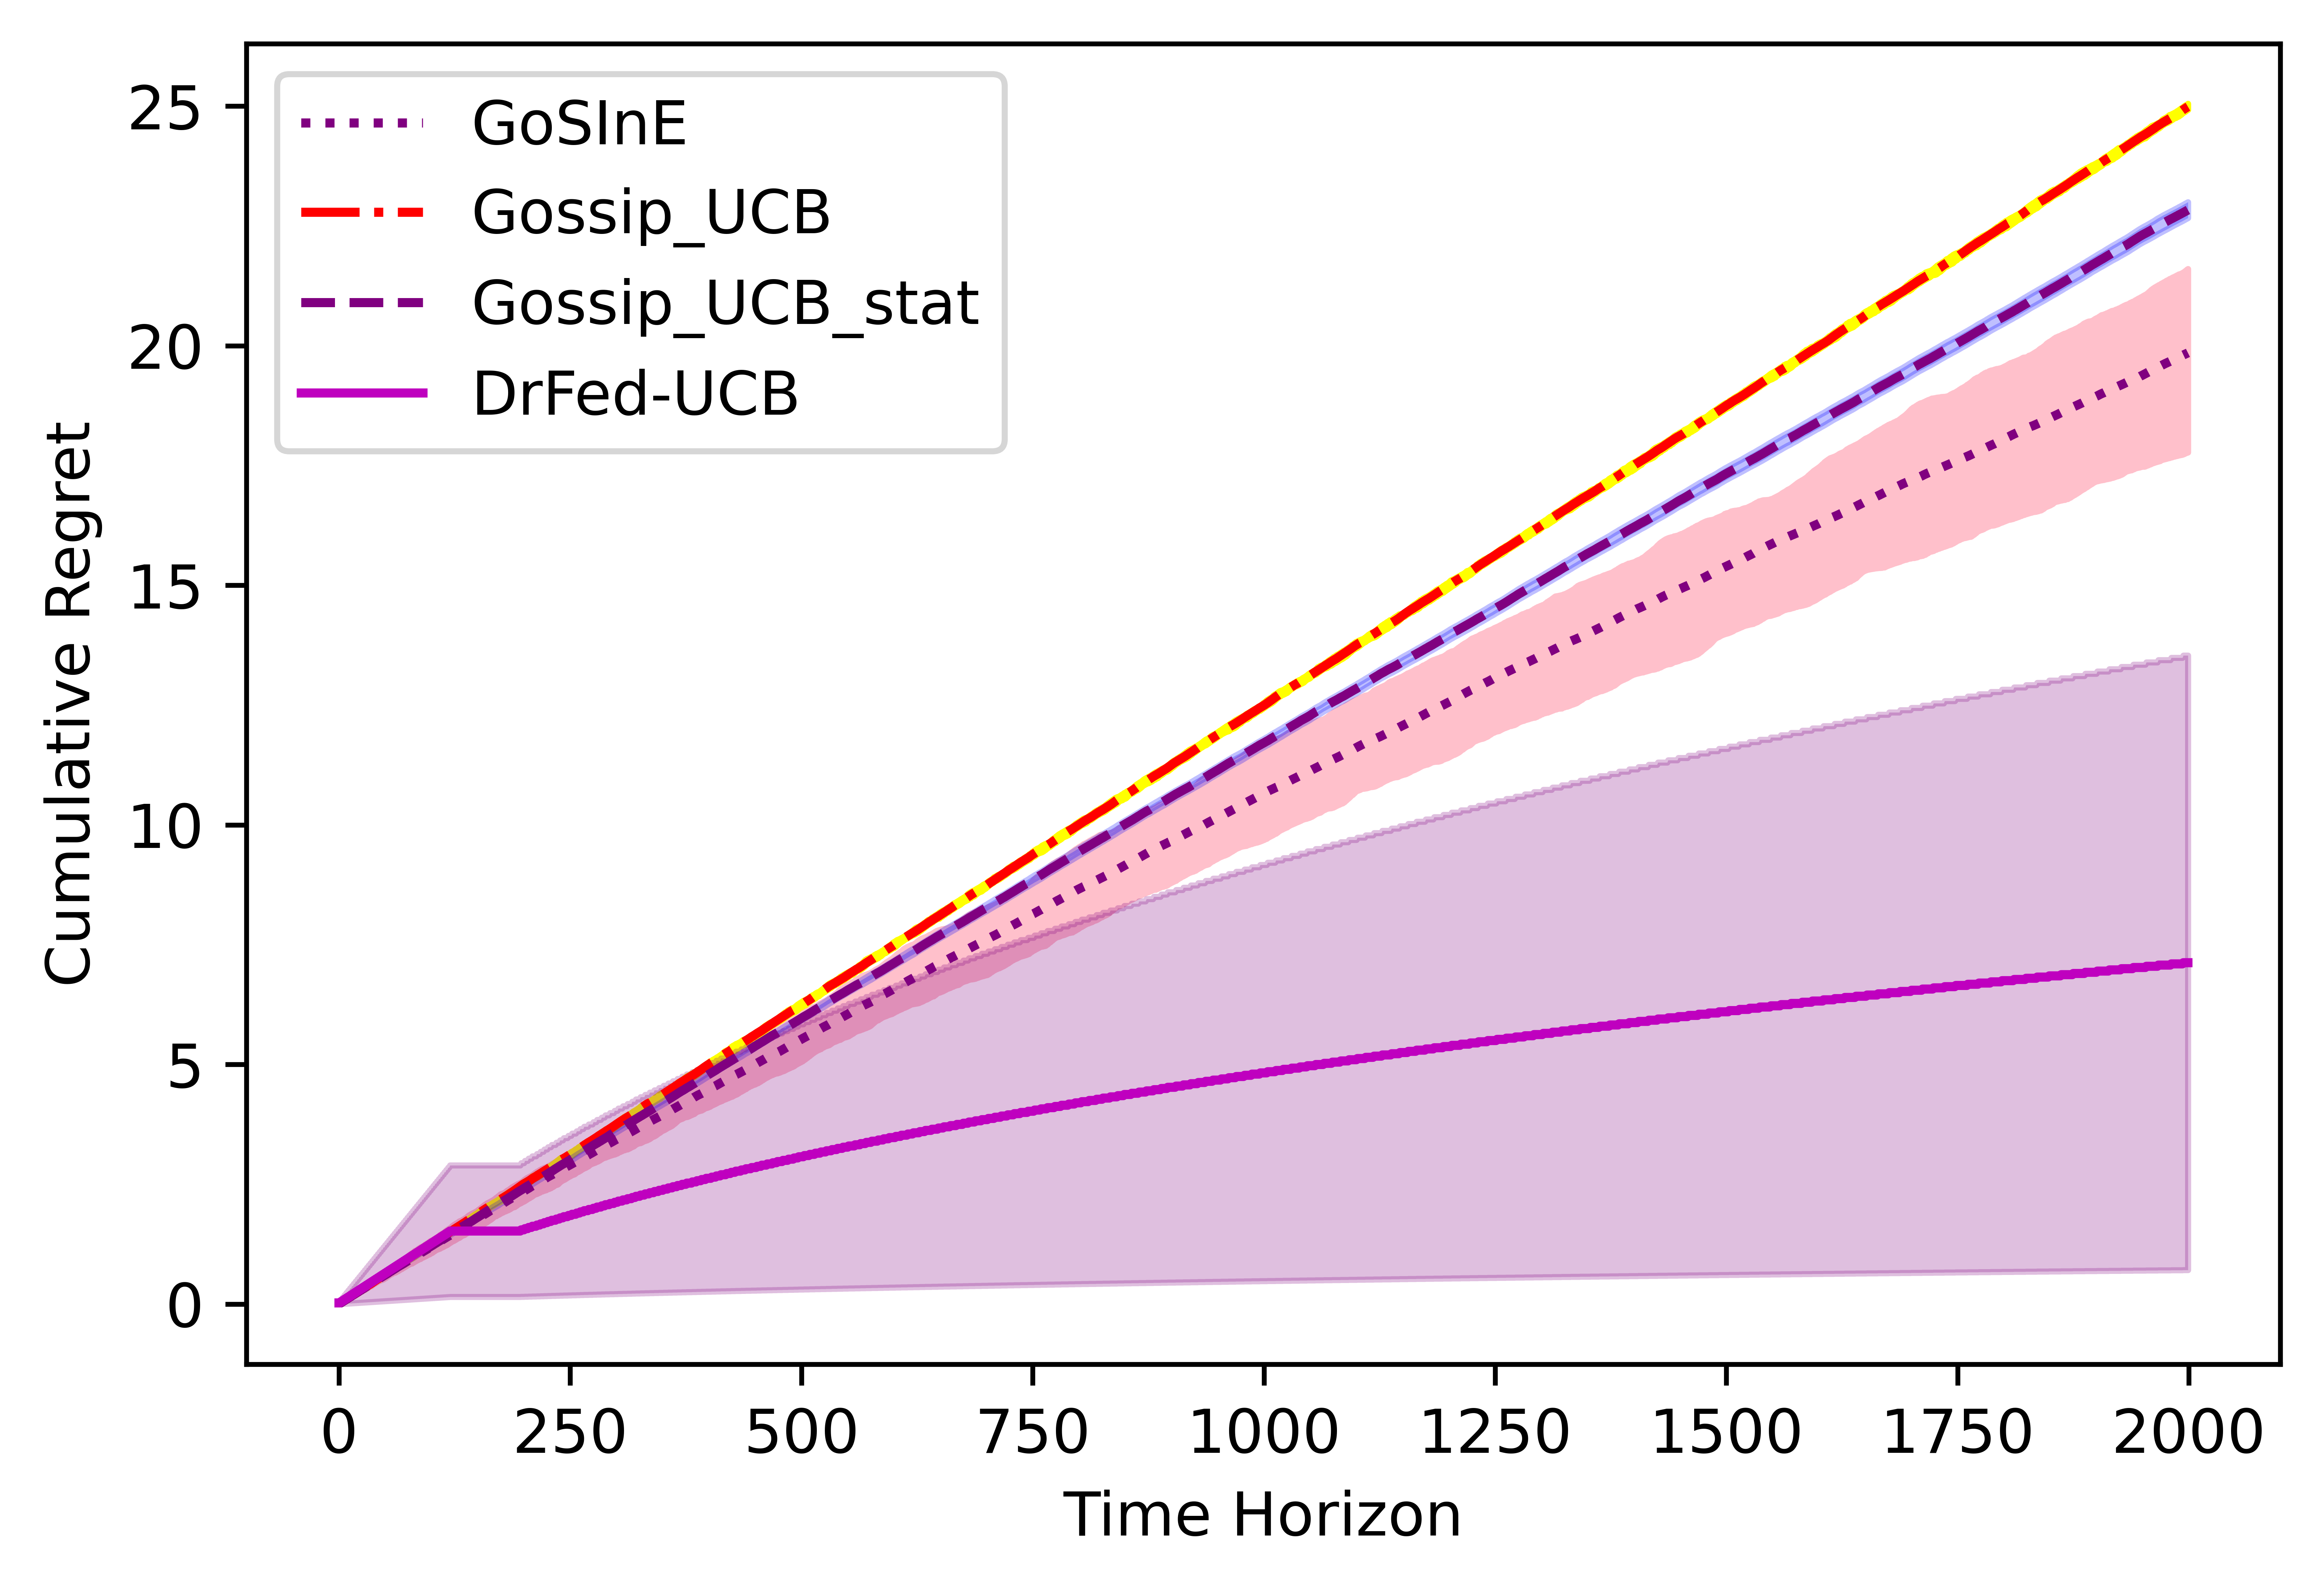

In [43]:
rs_avg=np.mean(rs,axis=1)   
rs_lower=np.percentile(rs,5,axis=1)
rs_upper=np.percentile(rs,95,axis=1)
rpa_comp_avg=np.mean(rpa_comp,axis=1)
rpa_comp_lower=np.percentile(rpa_comp,5,axis=1)
rpa_comp_upper=np.percentile(rpa_comp,95,axis=1)

x=np.arange(t)
plt.figure(dpi=1200)

# Plotting
#plt.plot(x,rs_avg,label='No Communication',color='b')
#plt.fill_between(x,rs_lower,rs_upper,color='b')
plt.plot(x_axis,rpa_comp_avg,label='GoSInE',color='purple', linestyle = ":")
plt.fill_between(x_axis,rpa_comp_lower,rpa_comp_upper,color='pink')

x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1),label='Gossip_UCB',color='red',linestyle = "dashdot")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='yellow')

plt.plot(x_axis,plot_data_s, label='Gossip_UCB_stat',color='purple', linestyle = "dashed")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1'])
#for i in range(4):
plt.fill_between(x_axis,plot_min_s[:,0],plot_max_s[:,0],color='blue',alpha=0.25)

plot_data_o = np.transpose(np.array(avg_regret_list)).reshape((2000,1))
plot_data_o_lw = np.transpose(np.array(lw_regret_list)).reshape((2000,1))
plot_data_o_upp = np.transpose(np.array(upp_regret_list)).reshape((2000,1))
plt.fill_between(x_axis,plot_data_o_lw[:,0],plot_data_o_upp[:,0],color='purple',alpha=0.25)

#x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data_o,  label='DrFed-UCB',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')

plt.legend()
plt.show()

In [44]:
#time complexity 
Gossip_UCB_stat = 46
GoSInE = 7
Gossip_UCB = 32

In [58]:
#time varying graphs

import numpy as np
import matplotlib.pyplot as plt
import time
now = time.time()

#------------ adjustable parameters ----------------
# setting-1
#Simulation
config = {}
config['T'] = 2000
config['L'] = 50
config['M'] = 5
config['c'] = 0.9
config['K'] = 2
config['c1'] = 0.5
config['h'] = 0.1
config['scale'] = 0.2
config['mu'] = np.ones((config['M'], config['K']))
print(config['mu'])
for k in range(config['K']):
    config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
config['sigma'] = config['scale']*np.ones((config['M'], config['K']))

NumAgent = config['M']
NumArms = config['K'] 
Mu = config['mu'] 
c = config['c']
NumTimeSlot = config['T']
epsilon = 10/np.log2(NumTimeSlot)
adj_list = []
for i in range(NumAgent):
    for j in range(NumAgent):
        if i != j:
            adj_list.append([i,j])
Graph = np.array(adj_list)


# # setting-2
# NumAgent = 5
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.5, 0.3,0.4,0.1,0.3,0.4,0.5, 0.2,0.9],[0.1, 0.2, 0.3,0.4,0.6,0.3,0.4,0.2, 0.2,0.9]]) 
# NumTimeSlot = 50000

# Graph = np.array([[1,2],[0,1],[0,2],[0,3],[0,4],[1,3],[1,4]])

# # setting-3
# NumAgent = 10
# NumArms = 10
# # Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.8, 0., 0.,0.4,0.6,0.6, 0., 0.9,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.9,0.3,0.4,0.8, 0.2,0.6]]) 
# Mu = np.array([[0.3, 0.3, 0.3,0.4,0.8, 0.2,0.6,0,0.1,0.9], [0.1, 0., 0.,0.4,0.6,0.6, 0., 0.1,0.4,0.6], [0.1, 0.2, 0.3,0.4,0.1,0.3,0.4,0.8, 0.2,0.9],
# [0.1, 0.2, 0.3,0.4,0.5,0.6, 0.7, 0.1,0.4,0.96], [0.1, 0., 0.5,0.4,0.6,0.6, 0.1, 0.1,0.4,0.61], [0.1, 0.2, 0.,0.4,0.6,0.6, 0.8, 0.1,0.4,0.16],
# [0.1, 0.6, 0.,0.4,0.6,0.6, 0.2, 0.1,0.4,0.69], [0.1, 0.7, 0.1,0.4,0.6,0.6, 0.6, 0.1,0.4,0.99], [0.1, 0., 0.3,0.4,0.6,0.6, 0.2, 0.1,0.4,0.9],
# [0.1, 0.5, 0.,0.4,0.6,0.6, 0.3, 0.1,0.4,0.6]]) 
# NumTimeSlot = 10**5
# epsilon = 10/np.log2(NumTimeSlot)
# Graph = np.array([[1,2],[0,1],[0,2],[0,8],[0,9],[6,2],[3,2],[6,3],[5,6],[5,4],[5,7]])
#---------------------------------------------------
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a])

def Cond(gt,n_min_k,t):
    cond_est = np.sqrt(gt/n_min_k)
    cond_gossip = np.sqrt(NumArms)/t**2 + 8*np.sqrt(NumArms) * np.log(t) / (n_min_k) + np.sqrt(gt/n_min_k)
    return 3*cond_gossip + cond_est

def CondC(n_ikt,t,lambda2,N,epsilon):
    # beta0 = 6/(np.log(1/lambda2)*(1-lambda2**(1/3))) * lambda2**(n_ikt/6)
    # return (1+beta0-2/N)*np.sqrt(2*N/n_ikt*np.log(t)) + lambda2**t
    if epsilon == None:
        return 0.5*np.sqrt(3*np.log(t)/(N*n_ikt)) + 1/(2*t)
    else:
        # return np.sqrt((8*(N**2)*(np.log(NumTimeSlot)*np.log(2*n_ikt))**2/(epsilon**2)/n_ikt+N)*2/n_ikt*np.log(t)) + 2/(N*t**6)
        # return np.sqrt(  2*N * ((128*N * (np.log(NumTimeSlot) * np.log(n_ikt))**2 )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(NumTimeSlot) ) + lambda2**t
        return np.sqrt(  2*N * ((128/4/4*N * (np.log(NumTimeSlot)**2 * np.log(n_ikt) * np.log(t)) )/(n_ikt**2)/(epsilon**2) + 1/n_ikt ) * np.log(t) ) + lambda2**t



def add_privacy_noise(X_sum_ik,x_bin_ik,epsilon,t): # Wrong one
    lbd = np.log2(NumTimeSlot)/epsilon
    idx = t+1
    bin_t = bin(idx)[2:]
    # bin_xlen = bin(len(x_bin_ik))[2:]
    X_sum = X_sum_ik
    if len(bin_t) > len(x_bin_ik):
        x_bin_ik = np.zeros(len(bin_t))
        x_bin_ik[0] = np.random.laplace(scale = lbd)
        return x_bin_ik[0] + X_sum, x_bin_ik
    else:
        for i in range(len(bin_t)):
            if bin_t[i] == '1' and x_bin_ik[i] != 0:
                X_sum += x_bin_ik[i]
            elif bin_t[i] == '1' and x_bin_ik[i] == 0:
                X_sum += np.random.laplace(scale = lbd)
            elif bin_t[i] == '0':
                x_bin_ik[i] = 0
        return X_sum, x_bin_ik



Mu_mean = np.mean(Mu,0)
print(f'Mean of mu is {Mu_mean}')
mu_max = np.max(Mu_mean)
W = np.zeros((NumAgent,NumAgent))
for i in Graph:
    ei = one_hot(i[0], NumAgent)
    ej = one_hot(i[1], NumAgent)
    W += np.eye(NumAgent) - 0.5*(ei-ej)*np.transpose([ei-ej])

W = W/len(Graph)
eigVal, _ = np.linalg.eig(W)
lambda2 = np.sort(eigVal)[-2]
print(f'The second largest eigen value is {lambda2}')
itr = 100


regret_rec = []
regret_rec_var = []
regret_rec_lw = []
regret_rec_upp = []
repeat_mark = 3
# for epsilon in [1/np.log2(NumTimeSlot), 2/np.log2(NumTimeSlot), 5/np.log2(NumTimeSlot), None]:
for epsilon in [None]:
# for epsilon in [5,None]:
    regret_rec_tmp = []
    np.random.seed(repeat_mark)
    for trial in range(itr):
        #print(f'epsilon {epsilon}, trial {trial}')
        RandObservation = np.zeros((NumAgent,NumArms,NumTimeSlot))
        for i in range(NumAgent):
            for k in range(NumArms):
                RandObservation[i,k,:] = np.random.binomial(1,Mu[i,k],NumTimeSlot)
        theta = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # gt = 4*np.log(np.linspace(0,NumTimeSlot,NumTimeSlot)+1)
        n_min_k = np.ones(NumArms)
        n_ik = np.ones((NumAgent,NumArms))
        m = np.ones((NumAgent,NumArms))
        I = np.zeros((NumAgent,NumArms))
        tilde_X = np.zeros((NumAgent,NumArms))
        for i in range(NumAgent):
            for k in range(NumArms):
                tilde_X[i,k] = np.random.binomial(1,Mu[i,k],1)
        X_sum_clean = tilde_X.copy()
        theta[:,:,0] = tilde_X.copy()
        # theta_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_vec = np.zeros((NumAgent,NumArms,NumTimeSlot))
        # X_rec = np.zeros((NumAgent,NumArms))  # for privacy noise
        # X_rec = [([0] * NumArms) for i in range(NumAgent)]
        # X_rec = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        X_rec_bin = [([([]) for j in range(NumArms)]) for i in range(NumAgent)]
        # mse_rec = []
        if epsilon is not None:
            for i in range(NumAgent):
                for j in range(NumArms):
                    # X_rec[i][j].append(tilde_X[i,j]) 
                    X_rec_bin[i][j].append(tilde_X[i,j]+ np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon)) 
        

        regret = np.zeros((NumAgent,NumTimeSlot))
        regret_sum = np.zeros((NumAgent,NumTimeSlot))
        
        for t in range(1,NumTimeSlot):
            G = nx.erdos_renyi_graph(NumAgent,c)
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            adj_pair = []
            for i in range(NumAgent):
                neighbors[i].append(i)
                for j in range(NumAgent):
                    if i != j and j in neighbors[i]:
                        adj_pair.append([i,j])
                    if j in neighbors[i] and i not in neighbors[j]:
                        neighbors[j].append(i)
            Graph = np.array(adj_pair)
            mu_max = np.max(Mu_mean)
            W = np.zeros((NumAgent,NumAgent))
            #max_d = max([len(neighbor[i]) for i in range(NumAgent)])
            for i in range(NumAgent):
                for j in range(NumAgent):
                    if j in neighbors[i]: 
                        W[i,j] = 1/(1+max(len(neighbors[i]),len(neighbors[j])))
                W[i,i] = 1 - sum([W[i,j] for j in range(NumAgent)])

            #W = W/len(Graph)
            eigVal, _ = np.linalg.eig(W)
            lambda2 = np.sort(eigVal)[-2]
            #print(f'The second largest eigen value is {lambda2}')

            Edge = Graph[np.random.choice(range(len(Graph)),1,True)][0]
            #print(Edge)
            # theta_vec_rec = theta_vec.copy()
            for i in range(NumAgent):
                k_sel_break = []
                for k in range(NumArms):
                    # I[k] = theta[i,k,t-1] + Cond(gt[t],n_min_k[k],t)
                    I[i,k] = theta[i,k,t-1] + CondC(n_ik[i,k],t,lambda2,len(neighbors[i]),epsilon)
                    if n_ik[i,k] < m[i,k] - NumArms: # and np.random.uniform(size = 1)[0] > 1-1/NumAgent:
                        k_sel_break += [k]  
                # print(I)
                if k_sel_break:
                    k_sel = np.random.choice(k_sel_break,1,True)[0]
                else:
                    k_sel = np.argmax(I[i,:])
                # k_sel = np.argmax(I)
                regret[i,t] =  Mu[i,-1] - Mu[i,k_sel]
                # regret[i,t] =  (k_sel!=4)
                regret_sum[i,t] = regret_sum[i,t-1] + regret[i,t]
                tilde_X_pre = tilde_X.copy()
                # X_vec_pre = X_vec.copy()
                # X_rec[i][k_sel].append(Mu[i,k_sel] + RandObservation[i,k_sel,t])  # record observations of agent-i arm-k
                # tilde_X[i,k_sel] = add_privacy_noise(X_rec[i][k_sel],epsilon)   # with differential privacy
                X_sum_clean[i,k_sel] +=  RandObservation[i,k_sel,t]
                if epsilon is None:
                    tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  # no privacy
                else:
                    # if np.log2(n_ik[i,k_sel] + 1) == np.round(np.log2(n_ik[i,k_sel] + 1)):    # with privacy
                    # X_rec_bin[i][k_sel] = 
                    tmpx,X_rec_bin[i][k_sel] = add_privacy_noise(X_sum_clean[i,k_sel], X_rec_bin[i][k_sel],epsilon,t)   # with differential privacy, clean, bin record, eps, t
                    tilde_X[i,k_sel] = tmpx/n_ik[i,k_sel]
                    # if np.log2(t) == np.round(np.log2(t)):    # with privacy
                    #     # tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = 1/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + np.random.laplace(scale = np.log2(NumTimeSlot)/epsilon) + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1) 
                    #     # for j in range(NumArms):
                    #     #     tilde_X[i,j] += np.random.laplace(scale = 0.5* np.log2(NumTimeSlot)/epsilon/n_ik[i,j]) 
                    # else:
                    #     tilde_X[i,k_sel] = (tilde_X[i,k_sel]*n_ik[i,k_sel] + Mu[i,k_sel] + RandObservation[i,k_sel,t])/(n_ik[i,k_sel]+1)  

                
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:] * n_ik[i,k_sel]
                # X_vec[i,k_sel,t] = Mu[i,k_sel] + RandObservation[i,k_sel,t]
                # X_vec[i,k_sel,:] = X_vec[i,k_sel,:]/(n_ik[i,k_sel]+1)
                n_ik[i,k_sel] += 1
                for k in range(NumArms):
                    theta[i,k,t] = sum([theta[j,k,t-1]*W[i,j] for j in neighbors[i]]) + tilde_X[i,k] - tilde_X_pre[i,k]
                    m[i,k] = max(max([m[j,k] for j in neighbors[i]]), n_ik[i,k])
                    # theta_vec[i,:,:] = (theta_vec_rec[Edge[0],:,:] + theta_vec_rec[Edge[1],:,:])/2 + X_vec[i,:,:] - X_vec_pre[i,:,:]
                #else:
                    #theta[i,:,t] = theta[i,:,t-1] + tilde_X[i,:] - tilde_X_pre[i,:]
                    # theta_vec[i,:,:] = theta_vec_rec[i,:,:] + X_vec[i,:,:] - X_vec_pre[i,:,:]
            #n_min_k = np.min(n_ik,0)
            # mse_rec += [np.sum(theta_vec**2)*np.min(n_min_k)]
            # print(theta[:,:,t])
        regret_rec_tmp += [np.mean(regret_sum,0)]
    regret_rec_tmp = np.array(regret_rec_tmp)
    regret_rec.append([np.mean(regret_rec_tmp,0)])
    
    regret_rec_upp.append([np.percentile(regret_rec_tmp,95,axis=0)])
    regret_rec_lw.append([np.percentile(regret_rec_tmp,5,axis=0)])
    #regret_rec_lw.append(np.mean(regret_rec_tmp,0) - 1.96*np.sqrt(np.var(regret_rec_tmp,0))/np.sqrt(itr))
    
    #regret_rec_min += [np.min(regret_rec_tmp,0)]
    #regret_rec_max += [np.max(regret_rec_tmp,0)]
    
later = time.time()
difference = int(later - now)
print(difference)
# print(f'Mean of mu is {Mu_mean}')
# print(np.sum(theta_vec<0))
# plt.subplot(121)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
Mean of mu is [0.125 0.15 ]
The second largest eigen value is 0.7500000000000006
66


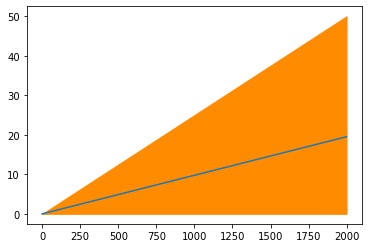

In [59]:
plot_data = np.transpose(np.array(regret_rec))
plot_min = np.transpose(np.array(regret_rec_lw))
plot_max = np.transpose(np.array(regret_rec_upp))
x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1))
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='darkorange')

#plt.legend(['eps = 1'])
#for i in range(4):
    #plt.fill_between(x_axis,plot_min[:,i],plot_max[:,i],color='blue',alpha=0.25)
# plt.plot(np.transpose(np.array(regret_rec_min)))
# plt.plot(np.transpose(np.array(regret_rec_max)))
# plt.legend(['eps = 1','eps = 2','eps = 5','None'])
# plt.title('')
# plt.show()
# plt.subplot(122)
# plt.semilogy(np.mean(regret_sum,0))
# plt.savefig(f'result_10_{repeat_mark}.pdf')
# plt.show()

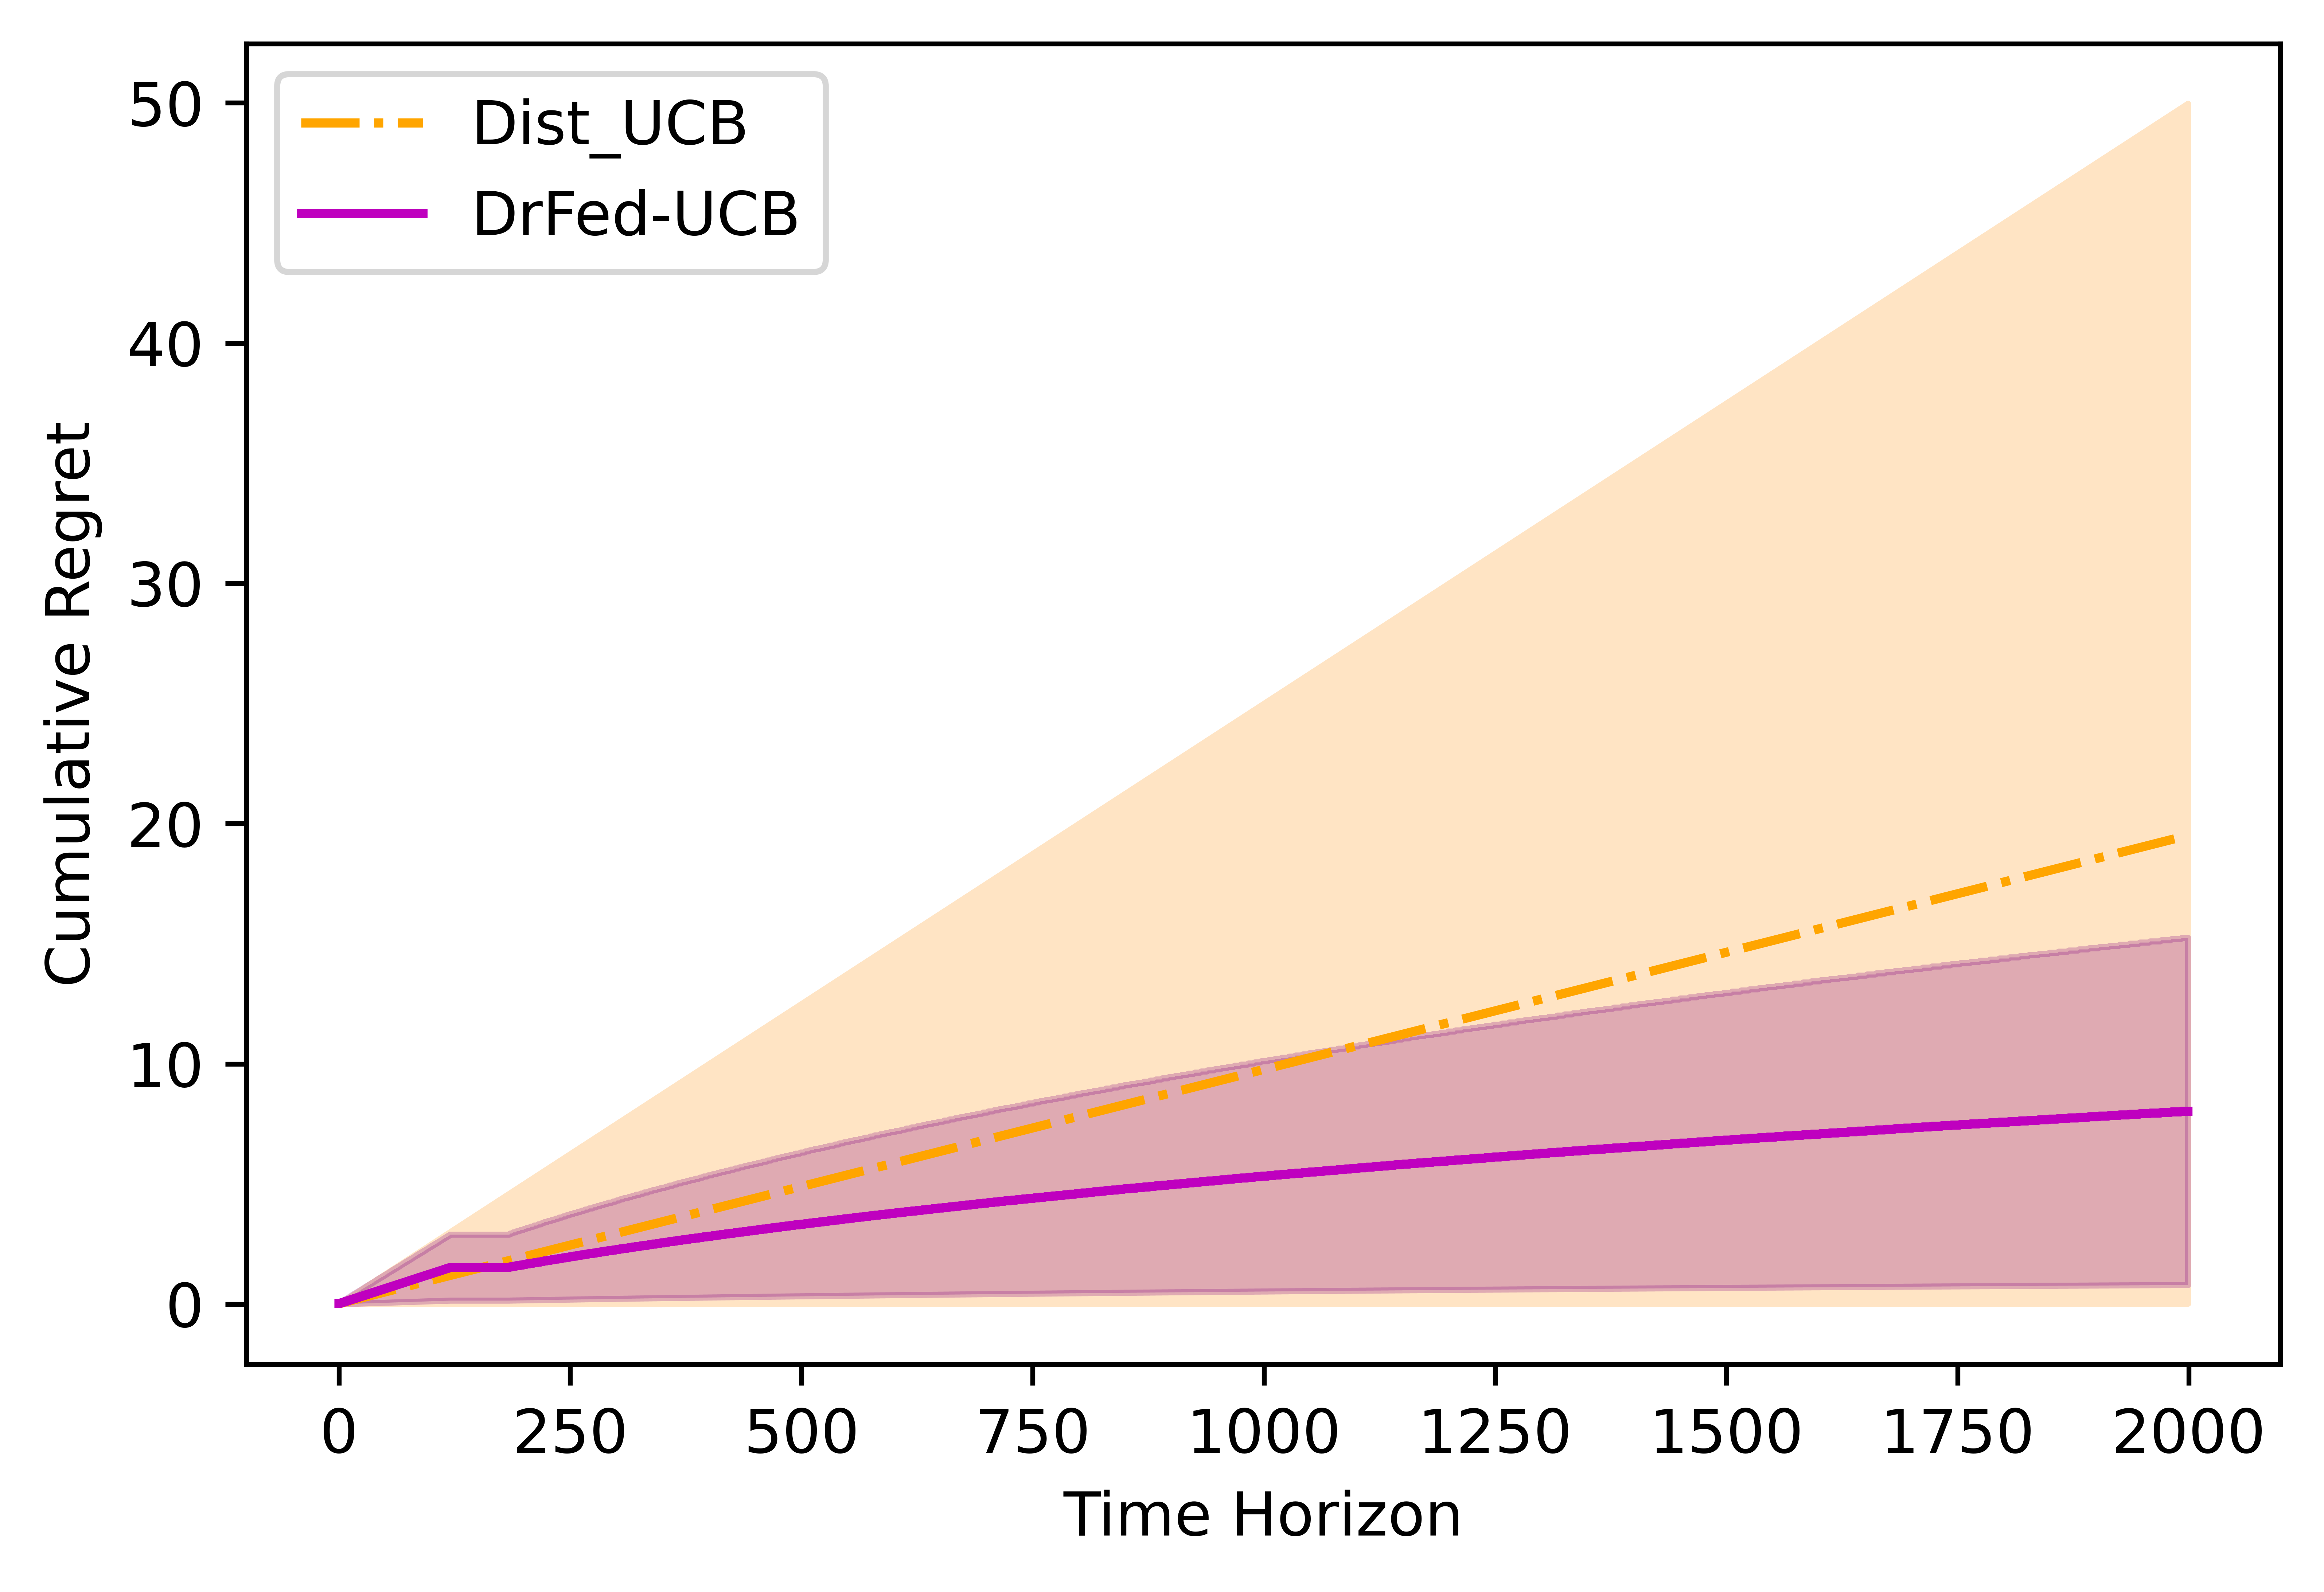

In [68]:
rs_avg=np.mean(rs,axis=1)   
rs_lower=np.percentile(rs,5,axis=1)
rs_upper=np.percentile(rs,95,axis=1)
rpa_comp_avg=np.mean(rpa_comp,axis=1)
rpa_comp_lower=np.percentile(rpa_comp,5,axis=1)
rpa_comp_upper=np.percentile(rpa_comp,95,axis=1)

x=np.arange(t)

x=np.arange(t)
plt.figure(dpi=1200)

# Plotting
#plt.plot(x,rs_avg,label='No Communication',color='b')
#plt.fill_between(x,rs_lower,rs_upper,color='b')
#plt.plot(x_axis,rpa_comp_avg,label='GoSInE',color='purple', linestyle = ":")
#plt.fill_between(x_axis,rpa_comp_lower,rpa_comp_upper,color='pink')

x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1),label='Dist_UCB',color='orange',linestyle = "dashdot")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='bisque')

#plt.plot(x_axis,plot_data_s, label='Gossip_UCB',color='purple', linestyle = "dashed")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1'])
#for i in range(4):
#plt.fill_between(x_axis,plot_min_s[:,0],plot_max_s[:,0],color='blue',alpha=0.25)

plot_data_o = np.transpose(np.array(avg_regret_list)).reshape((2000,1))
plot_data_o_lw = np.transpose(np.array(lw_regret_list)).reshape((2000,1))
plot_data_o_upp = np.transpose(np.array(upp_regret_list)).reshape((2000,1))
plt.fill_between(x_axis,plot_data_o_lw[:,0],plot_data_o_upp[:,0],color='purple',alpha=0.25)

#x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data_o,  label='DrFed-UCB',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')

plt.legend(loc='upper left')
plt.show()

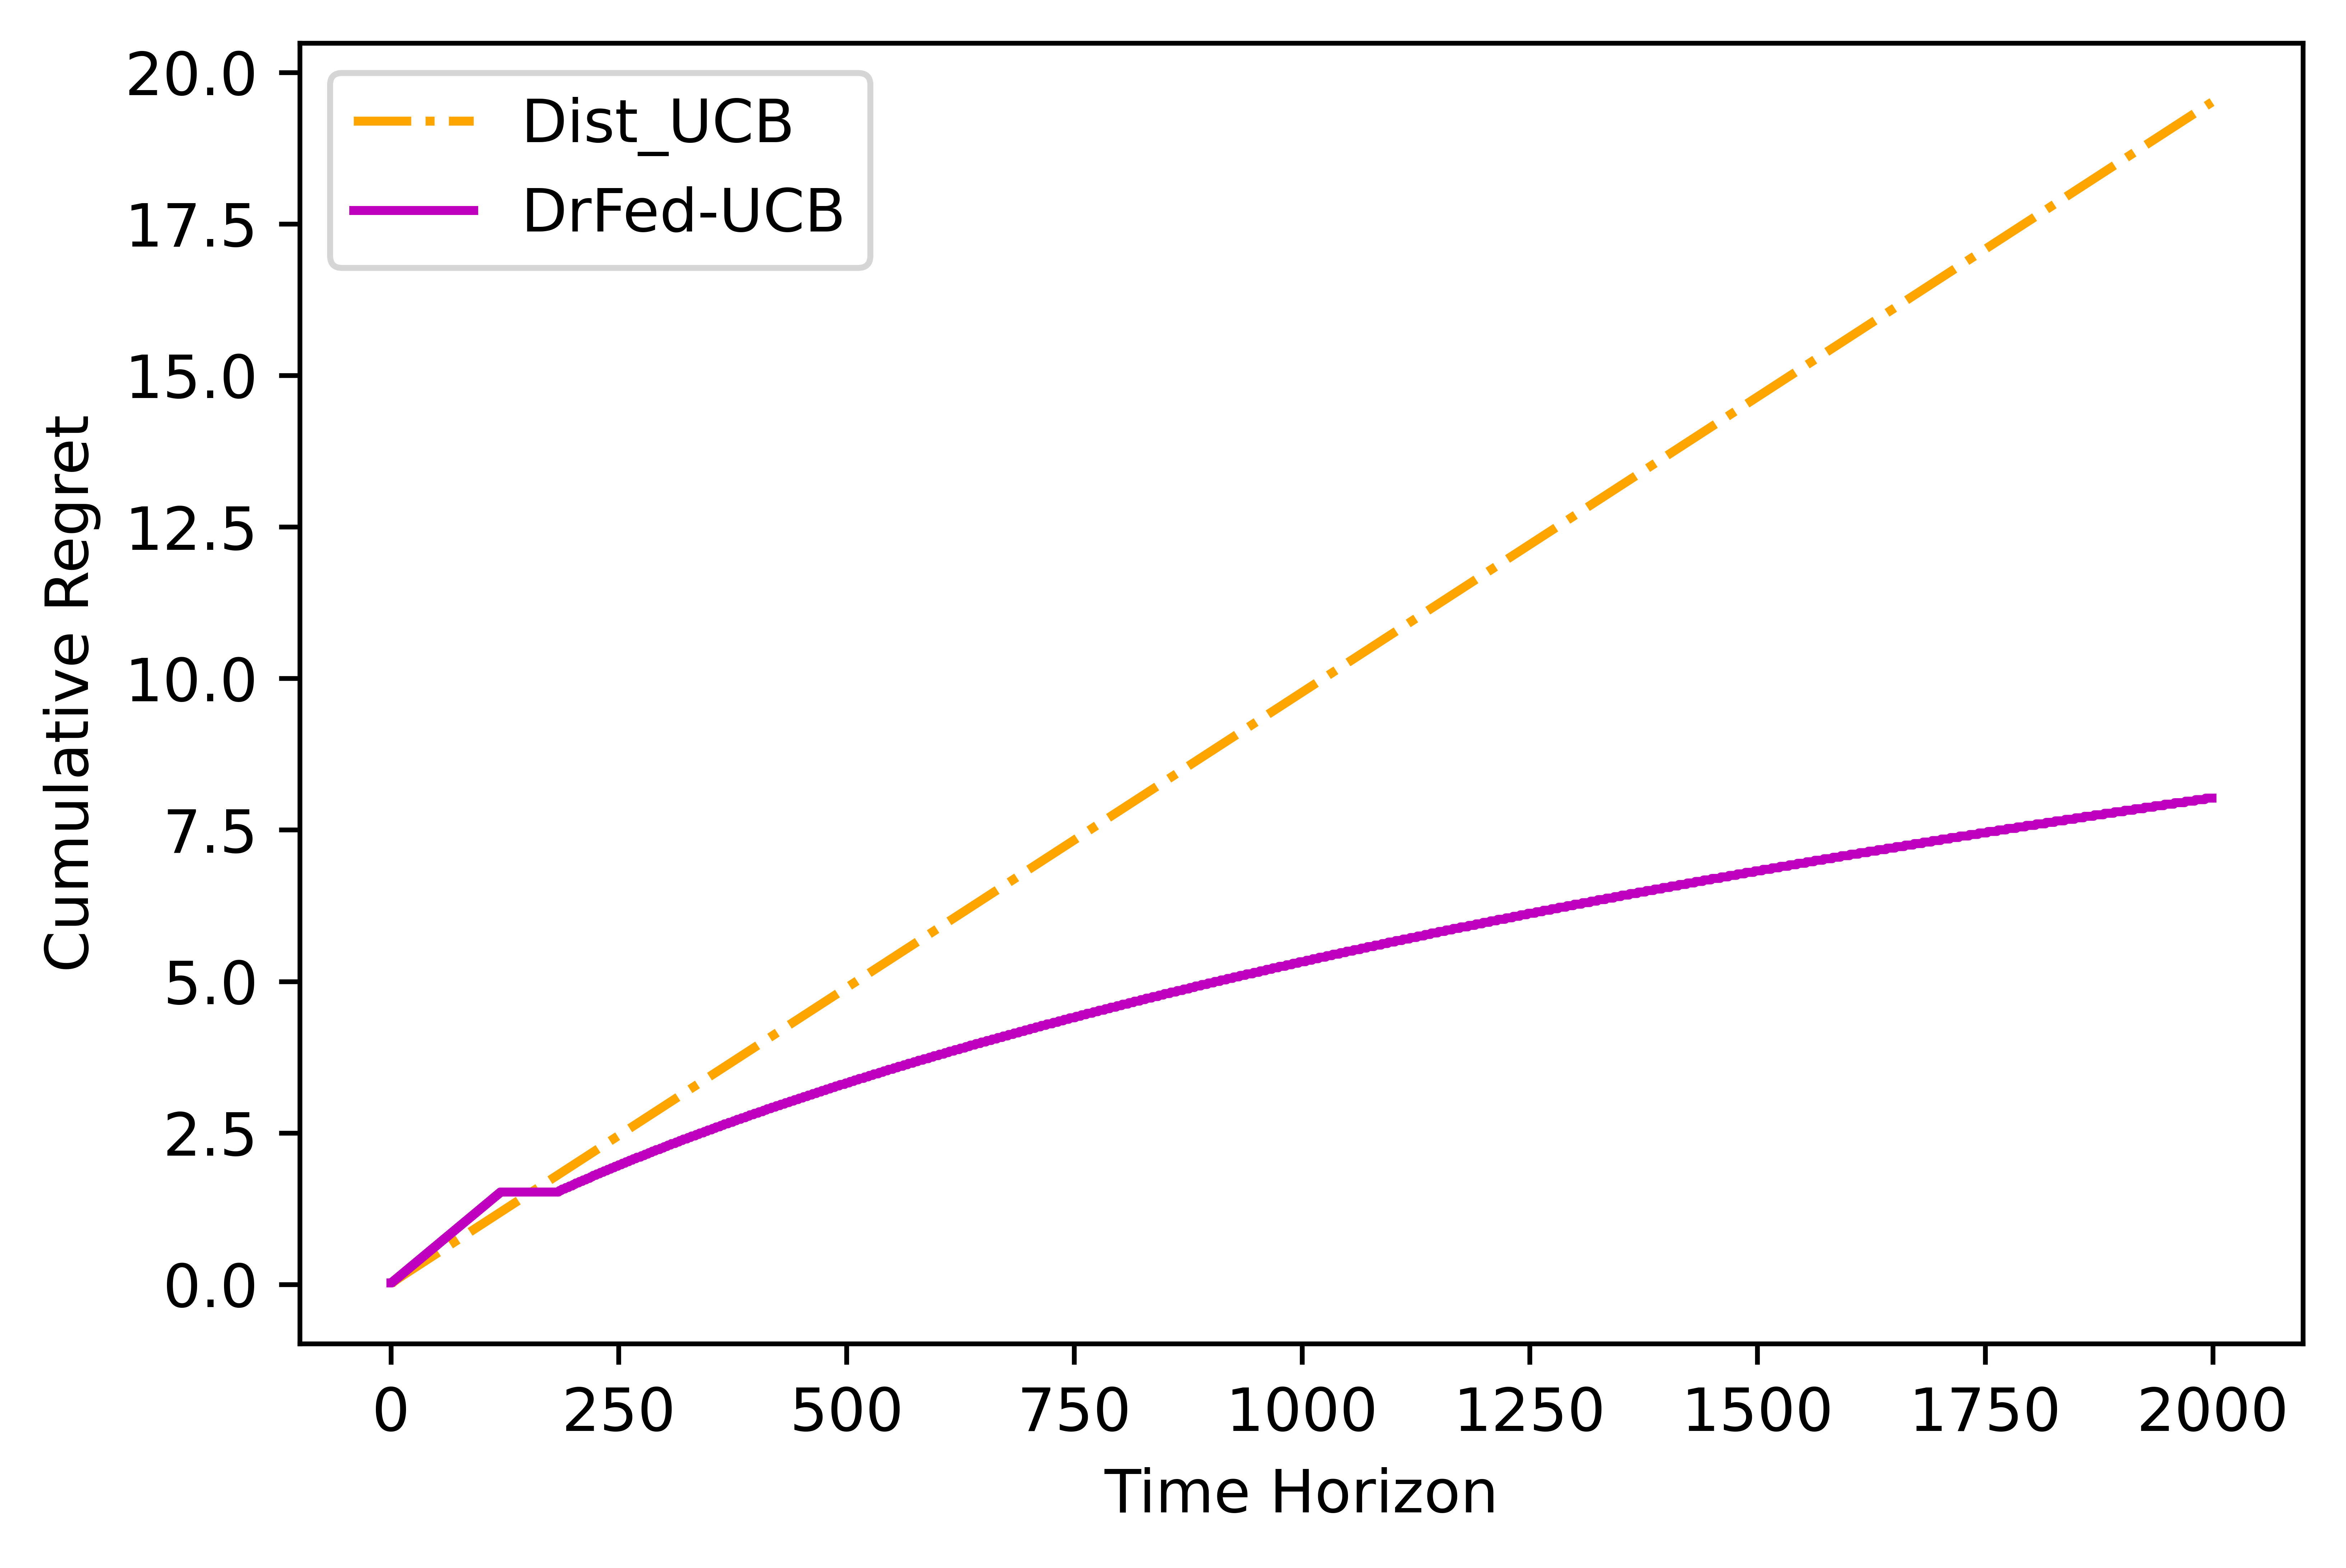

In [69]:
rs_avg=np.mean(rs,axis=1)   
rs_lower=np.percentile(rs,5,axis=1)
rs_upper=np.percentile(rs,95,axis=1)
rpa_comp_avg=np.mean(rpa_comp,axis=1)
rpa_comp_lower=np.percentile(rpa_comp,5,axis=1)
rpa_comp_upper=np.percentile(rpa_comp,95,axis=1)

x=np.arange(t)

x=np.arange(t)
plt.figure(dpi=1200)

# Plotting
#plt.plot(x,rs_avg,label='No Communication',color='b')
#plt.fill_between(x,rs_lower,rs_upper,color='b')
#plt.plot(x_axis,rpa_comp_avg,label='GoSInE',color='purple', linestyle = ":")
#plt.fill_between(x_axis,rpa_comp_lower,rpa_comp_upper,color='pink')

x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1),label='Dist_UCB',color='orange',linestyle = "dashdot")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='bisque')

#plt.plot(x_axis,plot_data_s, label='Gossip_UCB',color='purple', linestyle = "dashed")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1'])
#for i in range(4):
#plt.fill_between(x_axis,plot_min_s[:,0],plot_max_s[:,0],color='blue',alpha=0.25)

plot_data_o = np.transpose(np.array(avg_regret_list)).reshape((2000,1))
plot_data_o_lw = np.transpose(np.array(lw_regret_list)).reshape((2000,1))
plot_data_o_upp = np.transpose(np.array(upp_regret_list)).reshape((2000,1))
#plt.fill_between(x_axis,plot_data_o_lw[:,0],plot_data_o_upp[:,0],color='purple',alpha=0.25)

#x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data_o,  label='DrFed-UCB',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')

plt.legend(loc='upper left')
plt.show()

In [70]:
gosine = sklearn.metrics.auc(x_axis, rpa_comp_avg)
gossip_ucb = sklearn.metrics.auc(x_axis, plot_data_s)
dist_ucb = sklearn.metrics.auc(x_axis, plot_data.reshape(config['T'],1))
drfed_ucb = sklearn.metrics.auc(x_axis, plot_data_o)
print((gosine-drfed_ucb)/drfed_ucb, (gossip_ucb-drfed_ucb)/drfed_ucb, (dist_ucb-drfed_ucb)/drfed_ucb)

1.0945704175887336 1.3370029103066166 0.9658090300068534


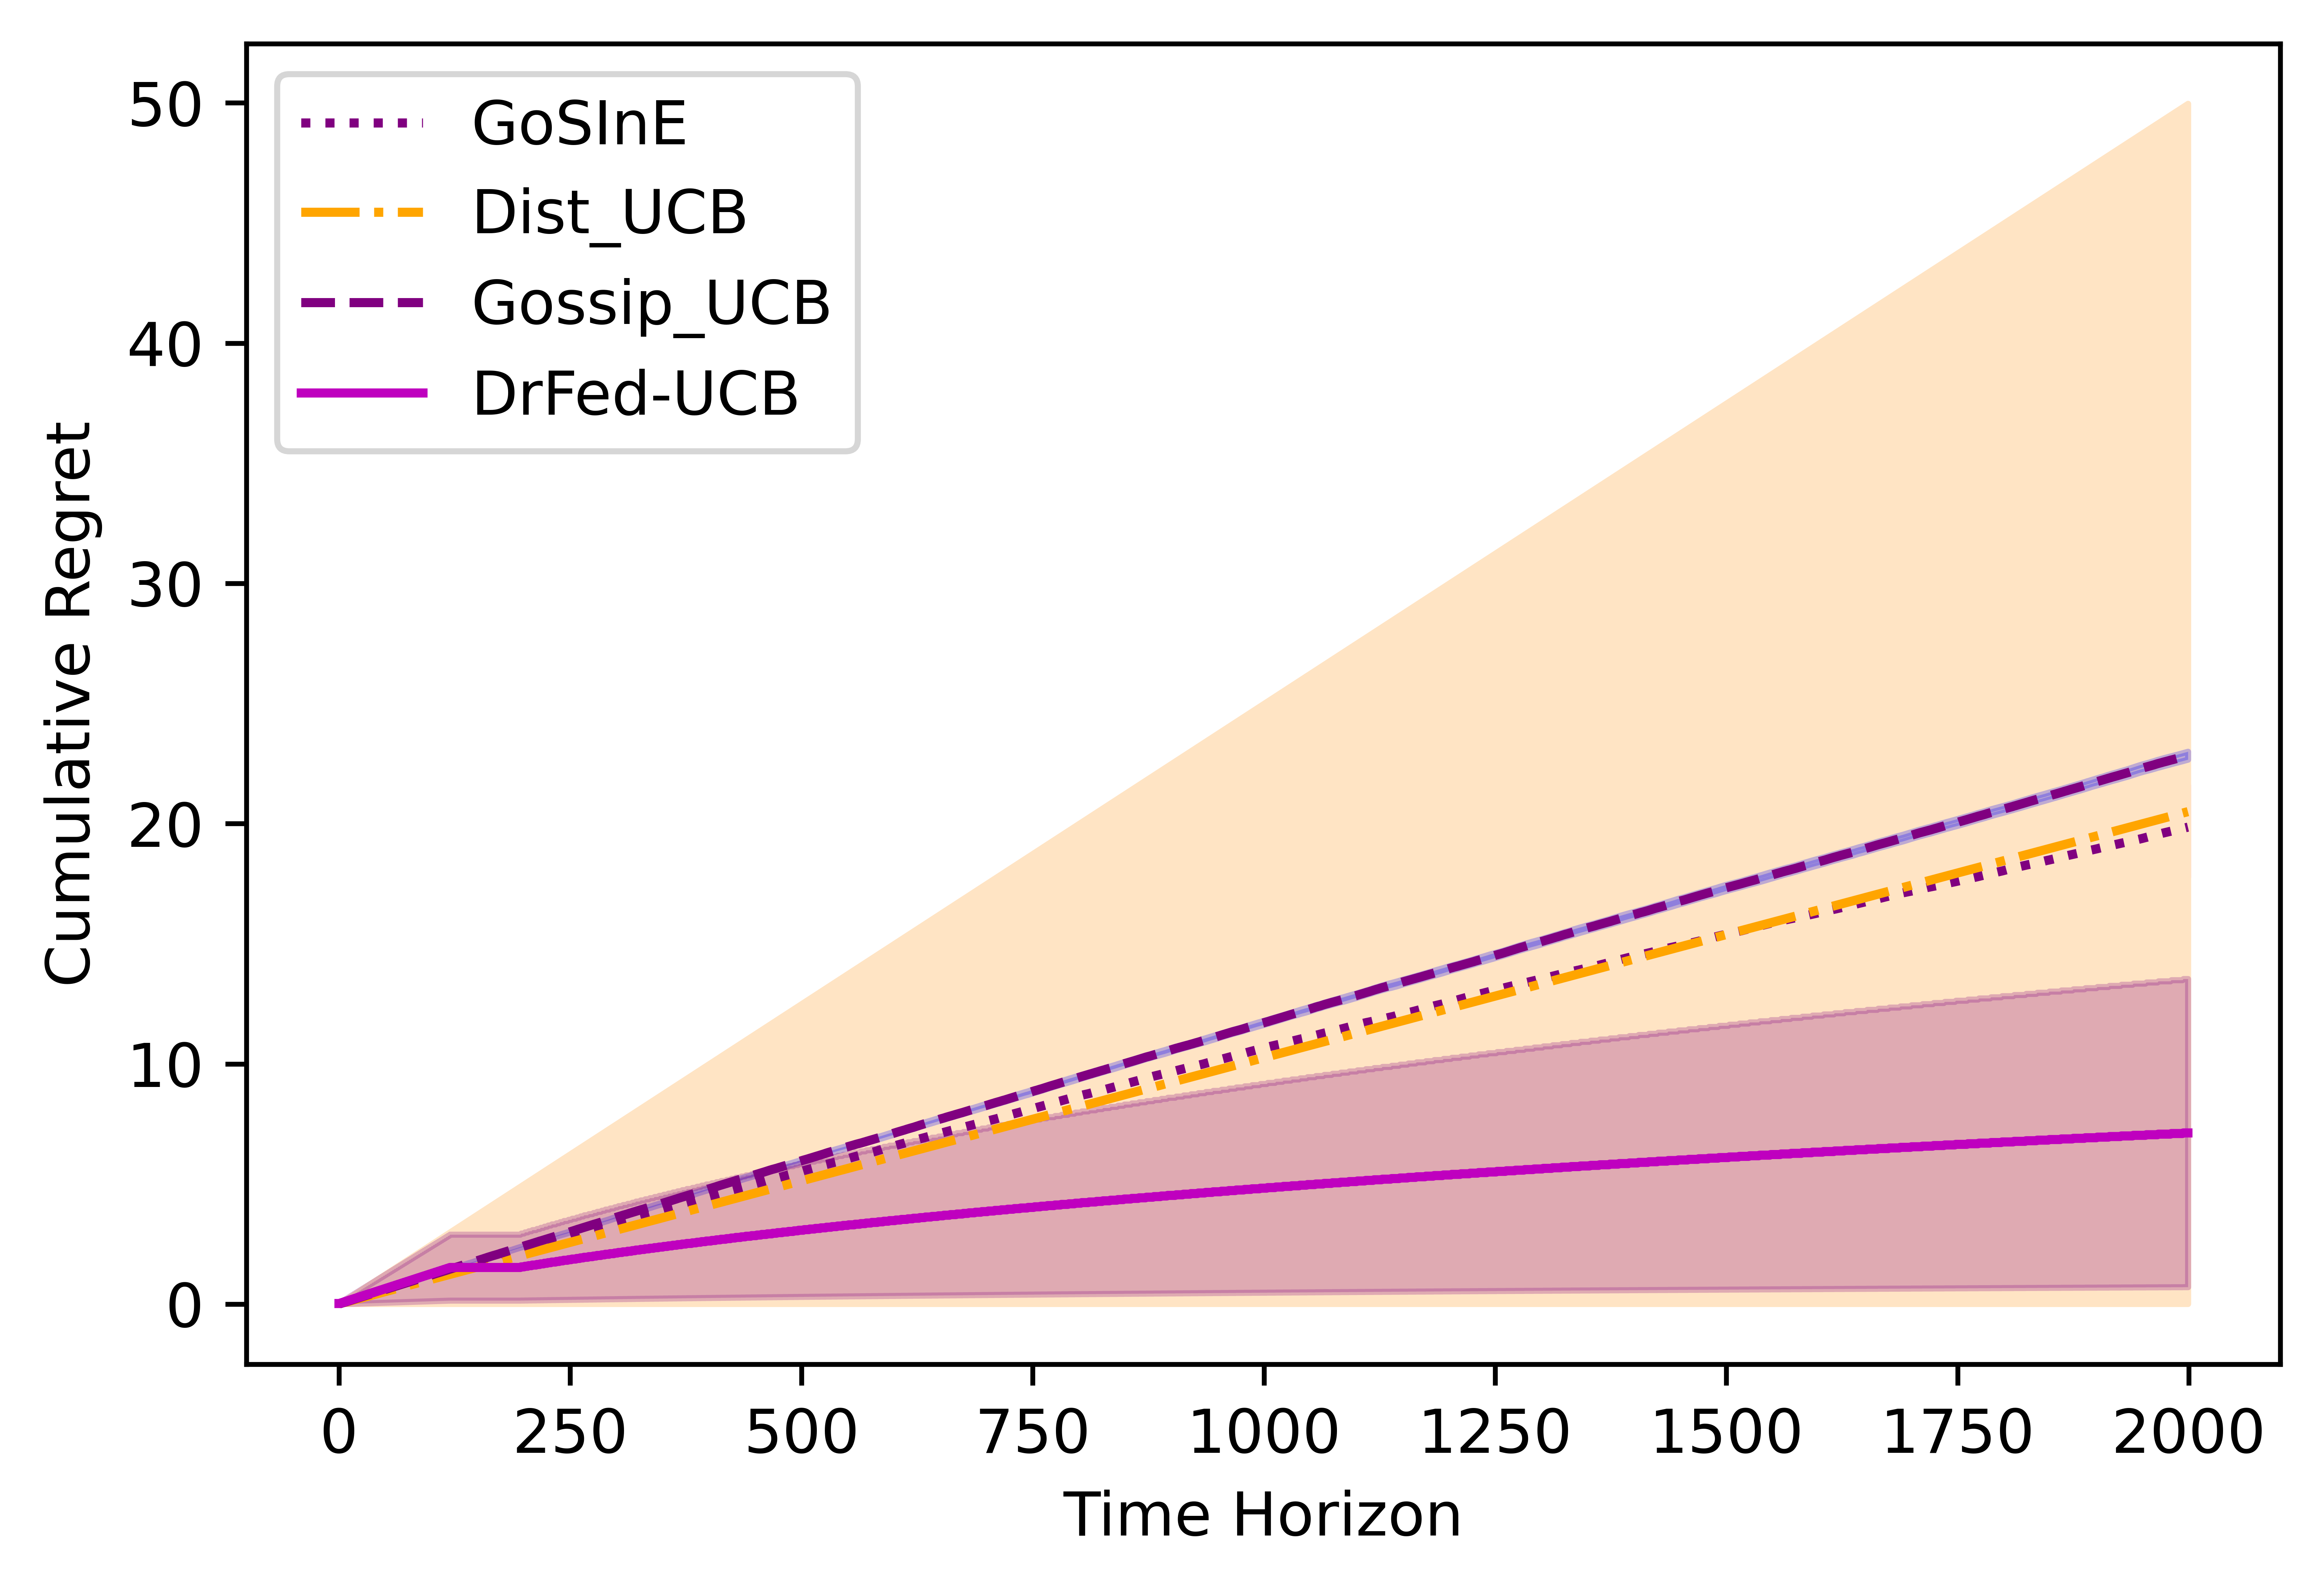

In [48]:
rs_avg=np.mean(rs,axis=1)   
rs_lower=np.percentile(rs,5,axis=1)
rs_upper=np.percentile(rs,95,axis=1)
rpa_comp_avg=np.mean(rpa_comp,axis=1)
rpa_comp_lower=np.percentile(rpa_comp,5,axis=1)
rpa_comp_upper=np.percentile(rpa_comp,95,axis=1)

x=np.arange(t)

x=np.arange(t)
plt.figure(dpi=1200)

# Plotting
#plt.plot(x,rs_avg,label='No Communication',color='b')
#plt.fill_between(x,rs_lower,rs_upper,color='b')
plt.plot(x_axis,rpa_comp_avg,label='GoSInE',color='purple', linestyle = ":")
plt.fill_between(x_axis,rpa_comp_lower,rpa_comp_upper,color='pink')

x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1),label='Dist_UCB',color='orange',linestyle = "dashdot")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='bisque')

plt.plot(x_axis,plot_data_s, label='Gossip_UCB',color='purple', linestyle = "dashed")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1'])
#for i in range(4):
plt.fill_between(x_axis,plot_min_s[:,0],plot_max_s[:,0],color='blue',alpha=0.25)

plot_data_o = np.transpose(np.array(avg_regret_list)).reshape((2000,1))
plot_data_o_lw = np.transpose(np.array(lw_regret_list)).reshape((2000,1))
plot_data_o_upp = np.transpose(np.array(upp_regret_list)).reshape((2000,1))
plt.fill_between(x_axis,plot_data_o_lw[:,0],plot_data_o_upp[:,0],color='purple',alpha=0.25)

#x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data_o,  label='DrFed-UCB',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')

plt.legend(loc='upper left')
plt.show()

In [51]:
import sklearn
from sklearn import metrics

In [53]:
gosine = sklearn.metrics.auc(x_axis, rpa_comp_avg)
gossip_ucb = sklearn.metrics.auc(x_axis, plot_data_s)
dist_ucb = sklearn.metrics.auc(x_axis, plot_data.reshape(config['T'],1))
drfed_ucb = sklearn.metrics.auc(x_axis, plot_data_o)
print((gosine-drfed_ucb)/drfed_ucb, (gossip_ucb-drfed_ucb)/drfed_ucb, (dist_ucb-drfed_ucb)/drfed_ucb)


1.3154611010920851 1.58346021051103 1.2815646269578642


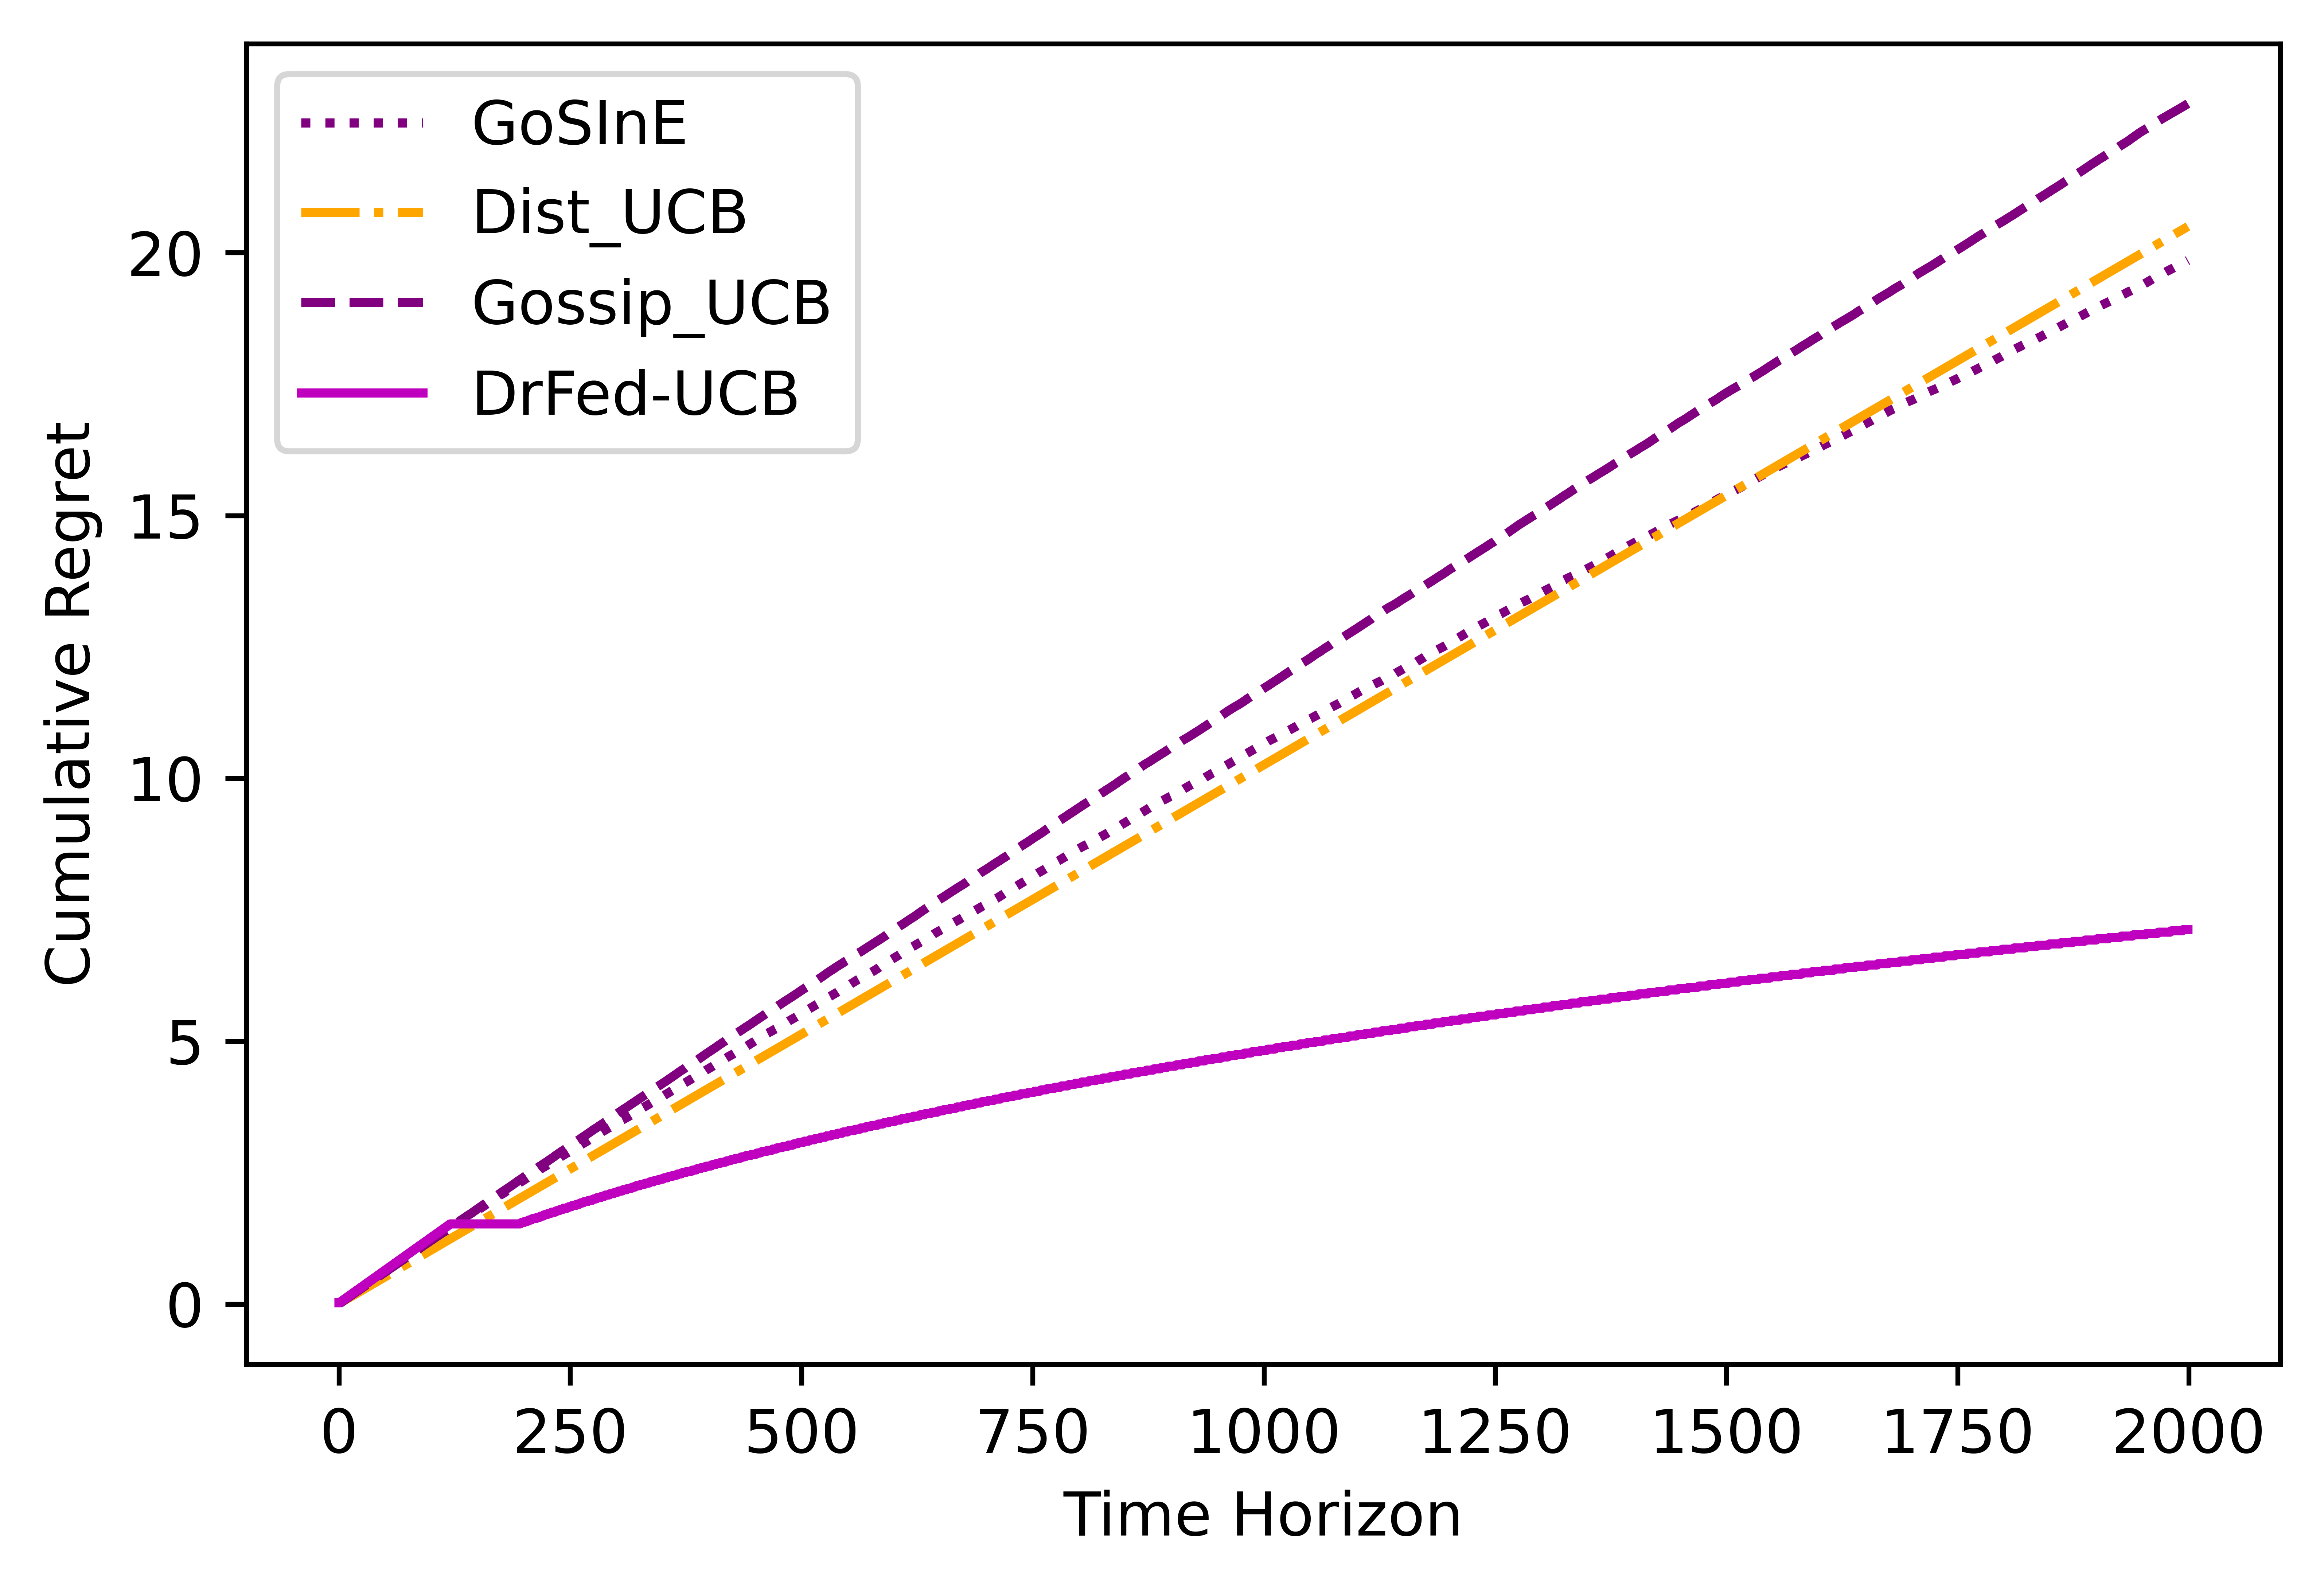

In [56]:
rs_avg=np.mean(rs,axis=1)   
rs_lower=np.percentile(rs,5,axis=1)
rs_upper=np.percentile(rs,95,axis=1)
rpa_comp_avg=np.mean(rpa_comp,axis=1)
rpa_comp_lower=np.percentile(rpa_comp,5,axis=1)
rpa_comp_upper=np.percentile(rpa_comp,95,axis=1)

x=np.arange(t)

x=np.arange(t)
plt.figure(dpi=1200)

# Plotting
#plt.plot(x,rs_avg,label='No Communication',color='b')
#plt.fill_between(x,rs_lower,rs_upper,color='b')
plt.plot(x_axis,rpa_comp_avg,label='GoSInE',color='purple', linestyle = ":")
#plt.fill_between(x_axis,rpa_comp_lower,rpa_comp_upper,color='pink')

x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data.reshape(config['T'],1),label='Dist_UCB',color='orange',linestyle = "dashdot")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.fill_between(x_axis,plot_min.reshape(config['T'],1)[:,0],plot_max.reshape(config['T'],1)[:,0],color='bisque')

plt.plot(x_axis,plot_data_s, label='Gossip_UCB',color='purple', linestyle = "dashed")
#plt.plot(x_axis,plot_min)
#plt.plot(x_axis,plot_max)
#plt.legend(['eps = 1'])
#for i in range(4):
#plt.fill_between(x_axis,plot_min_s[:,0],plot_max_s[:,0],color='blue',alpha=0.25)

plot_data_o = np.transpose(np.array(avg_regret_list)).reshape((2000,1))
plot_data_o_lw = np.transpose(np.array(lw_regret_list)).reshape((2000,1))
plot_data_o_upp = np.transpose(np.array(upp_regret_list)).reshape((2000,1))
#plt.fill_between(x_axis,plot_data_o_lw[:,0],plot_data_o_upp[:,0],color='purple',alpha=0.25)

#x_axis = np.arange(len(plot_data))
plt.plot(x_axis,plot_data_o,  label='DrFed-UCB',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')

plt.legend(loc='upper left')
plt.show()

In [279]:
#sub-gaussian 
class Environment:
    def __init__(self, config):
        self.T = config['T']
        self.M = config['M']
        self.c = config['c']

        self.mu = config['mu']
        self.sigma = config['sigma']
        self.h = config['h']
        #self.mu_opt_M = np.sort(self.mu)[-self.M:]
        self.K = config['K']
        logger.info(f"Created environment with M = {self.M}, mu = {self.mu},h= {self.h}, T = {self.T}, K = {self.K}")

    def __str__(self):
        return f"M{self.M}-K{self.K}-mu{str(self.mu)}"

    def update(self, t):
        pass

    def draw(self, arms, sensing=False):
        counts = collections.Counter(arms)
        rewards = np.zeros((self.M,))
        for player in range(self.M):
            #rewards[player] = np.random.normal(self.mu[player,arms[player]], self.sigma[player, arms[player]])
            if np.random.rand() <= self.mu[player,arms[player]]:
                rewards[player]=1
            else:
                rewards[player]=0
            #rewards[player] = np.random.binomial(1, self.mu[player,arms[player]], 1)
        graph = nx.erdos_renyi_graph(self.M,self.c,seed)


        return rewards, graph

class LocalMAB:
    def __init__(self, num_agents, num_arms):
        self.num_arms = num_arms
        #self.true_reward_means = true_reward_means
        self.q_local = np.zeros(num_arms)  # Estimated action values
        self.q_network = np.zeros(num_arms)  # Estimated action values
        self.q_var = np.zeros(num_arms)
        self.counts_local = np.zeros(num_arms)  # Counts of each action taken
        self.counts_network = np.zeros(num_arms)  # Counts of each action taken
        self.total_reward = 0
        self.c1 = 4
        self.c2 = 0
        self.epsilon = 0.1  # Exploration rate
        self.P = np.zeros(num_agents)
        self.P1 = np.zeros(num_agents)
        self.ucb = 0
        self.M = num_agents
        self.comm_reward = {}
        self.comm_counts = {}
        self.comm_reward_network = {}
        self.comm_counts_network = {}
        self.tmp = {}
        self.exp_reward = 0
        self.exp_reward_list = []
        self.regret = 0
        self.regret_list = []


    def choose_action(self, t, flag, c1):
        if flag:  # Corrected condition
            # Explore with probability epsilon
            return np.random.choice(self.num_arms)
        else:
            # Exploit the current estimates
            #self.counts_local[i]
            self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]
            self.ucb = [(self.q_network[i]+ self.q_var[i]) for i in range(len(self.q_network))]
            return np.argmax(self.ucb)

    def update(self, chosen_action, reward, exp_reward):
        # Update action values using sample-average method
        self.counts_local[chosen_action] += 1
        self.q_local[chosen_action] = (reward + self.q_local[chosen_action]*(self.counts_local[chosen_action]-1)) / self.counts_local[chosen_action]  # Corrected action counts
        self.total_reward += reward
        self.exp_reward += exp_reward
        self.exp_reward_list.append(self.exp_reward)
    
    def update_global(self, chosen_action, reward):
        # Update action values using sample-average method
        #self.counts_local[chosen_action] += 1
        a = 0
        for i in range(self.num_arms):  # Corrected loop
            for j in range(self.M):
                if self.P[j] >0:
                    a = max(self.comm_counts[j][i], a)  # Corrected assignment
            self.counts_network[i] = max(a, self.counts_local[i])
        #self.q_local[chosen_action] += (reward - self.q_local[chosen_action]) / self.counts_local[chosen_action]  # Corrected action counts
        for i in range(config['M']):
            d = (1 - np.sum(bandit[i].P1))/config['M']
            for k in range(config['K']):
                bandit[i].q_network[k] = sum([(bandit[i].P1[j] * bandit[i].comm_reward_network[j][k] + d*bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])


In [539]:
#characterizing the dependencies on the parameters
#homogeneous settings 
def main_p(M,c,K,h,c1,L):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = L
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = c1
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    print(config['mu'])
    for k in range(config['K']):
        config['mu'][:,k] = [config['h']+(k+1)*config['h']/config['K']]*config['M']
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 50
    avg_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([bandit[i].regret_list[j] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        
        return avg_regret




### Dependency on M

whether the regret bound should depend on M and heteorogenity is also different 
#20*(M+1)/(M**(3))
#### homogeneous
1) larger M leads to smaller regret since the expected number of edges is proportional to M (only for homogeneous settings) \
2) larger M leads to larger regret since it brings more uncertainties as well 


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]
 [0.15 0.2 ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


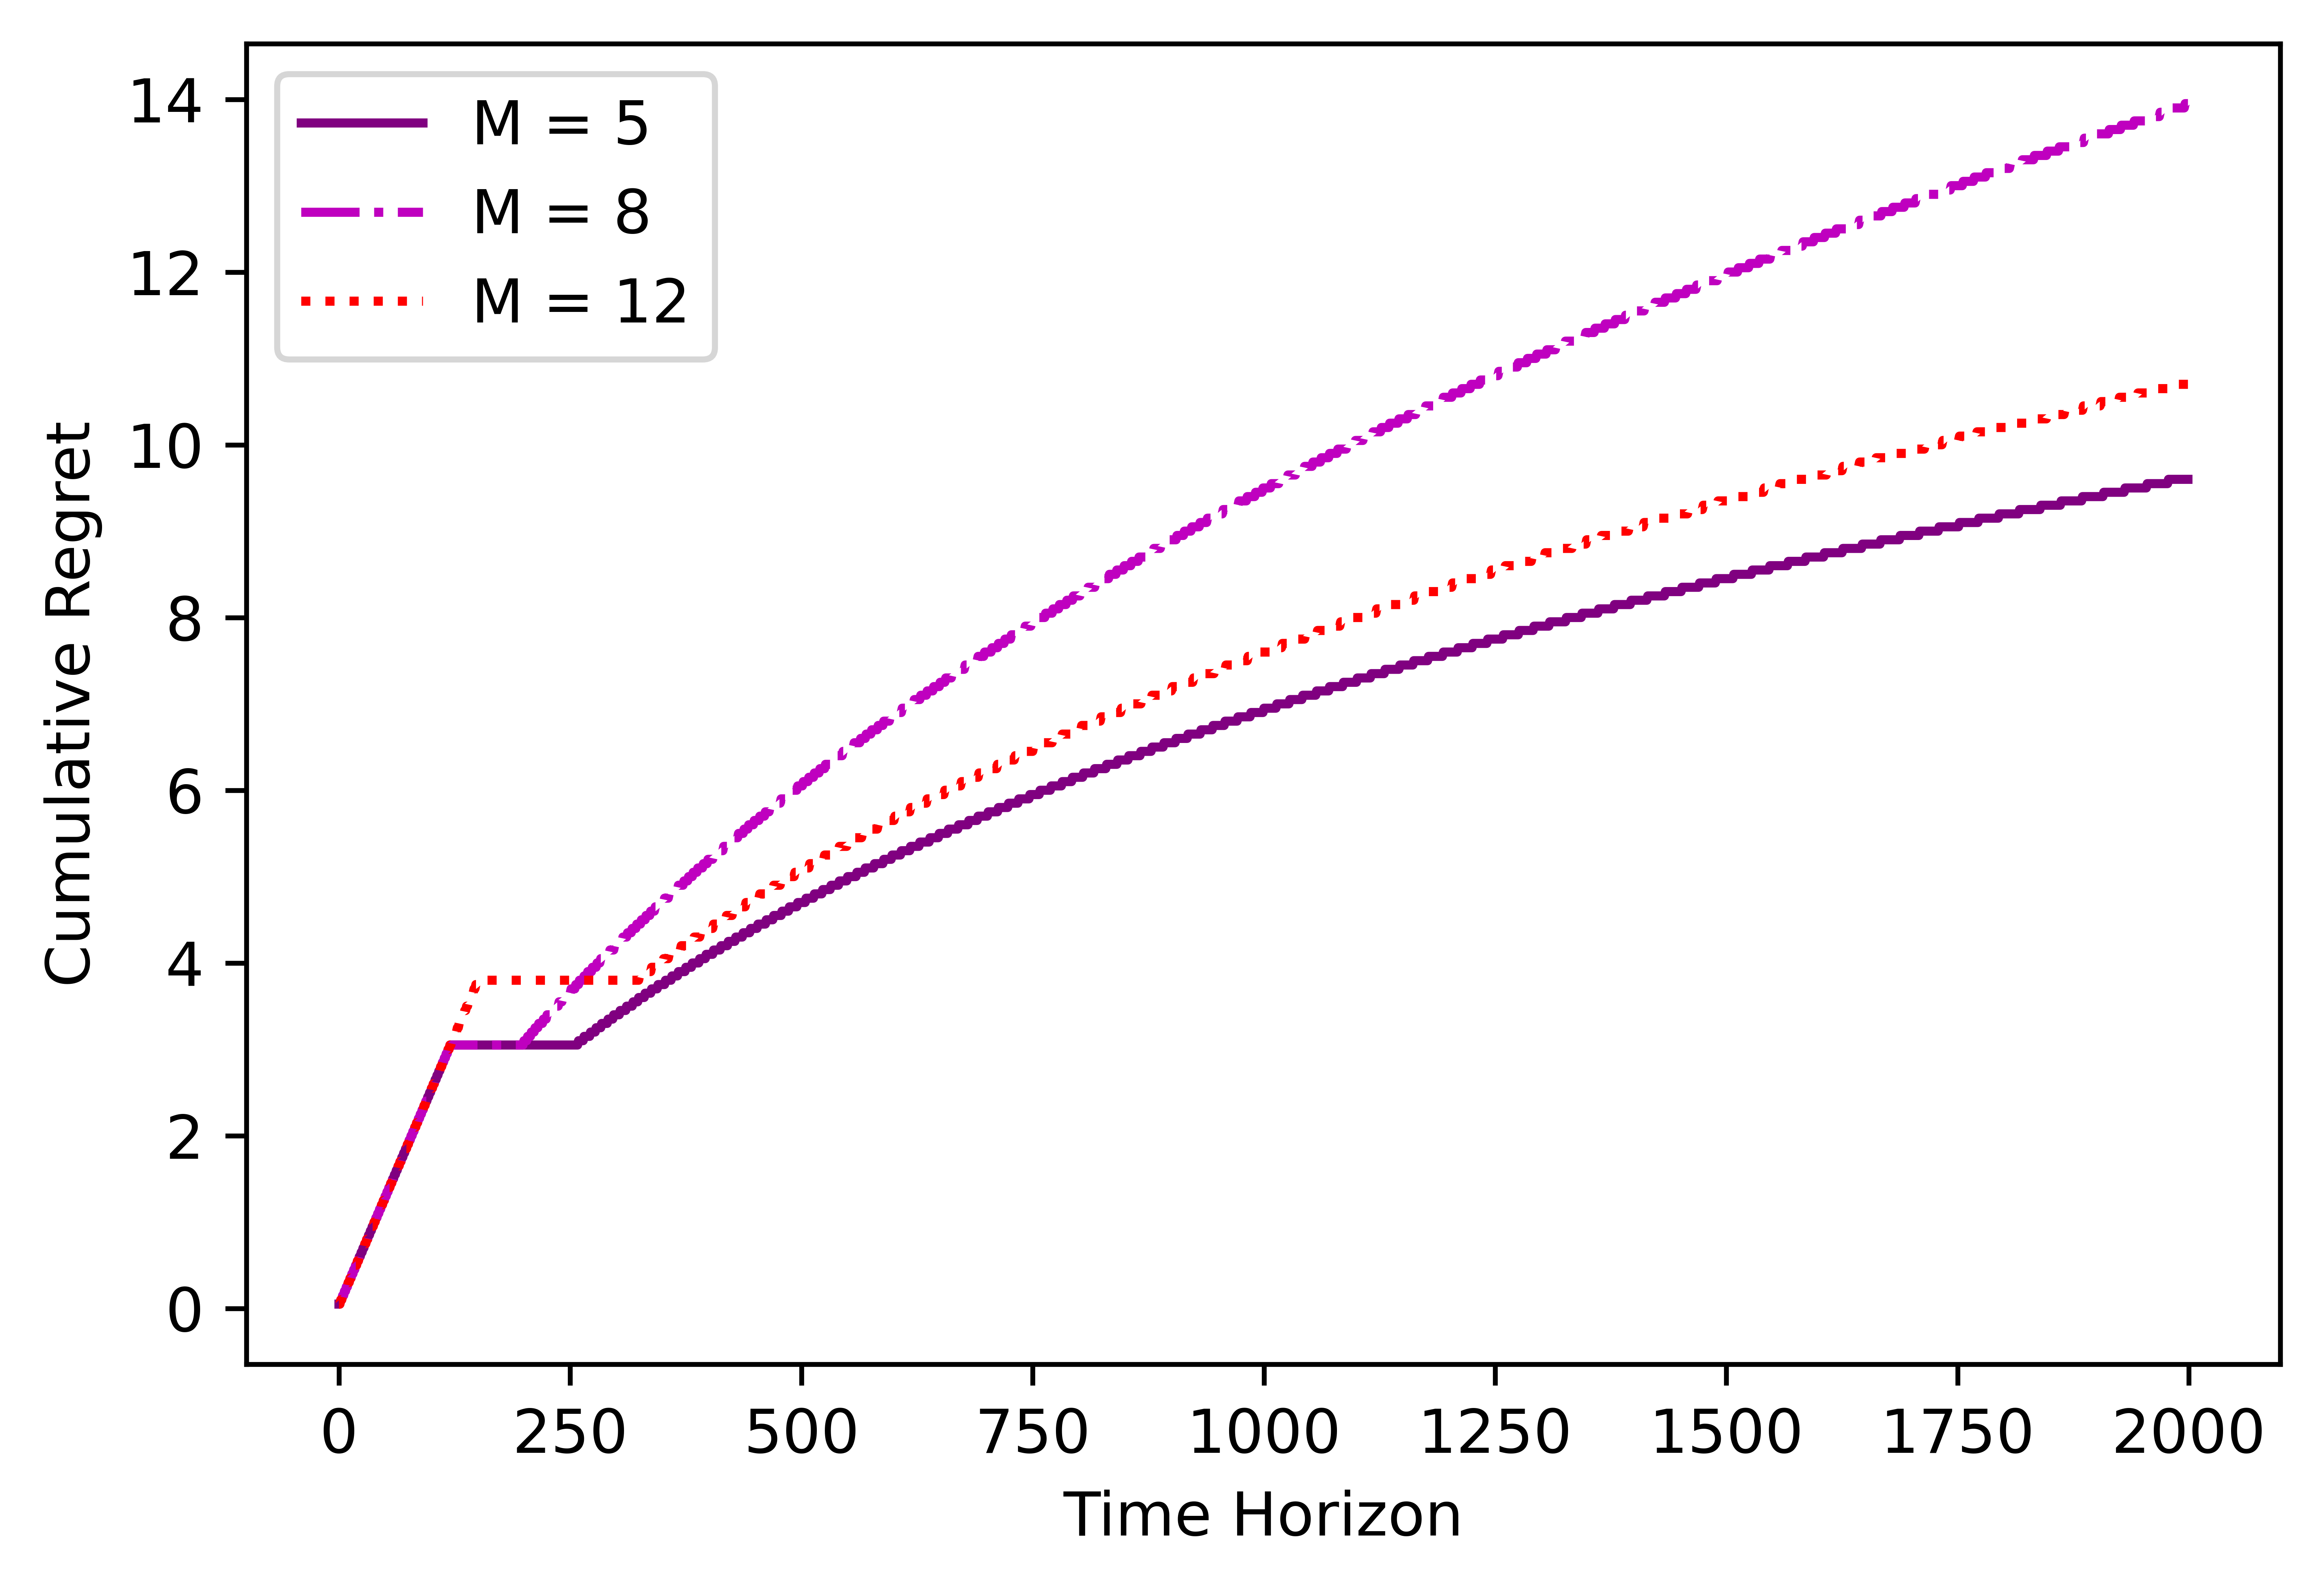

In [545]:

M_set = [5, 8,12]
avg_regret_list = []
c1 = [0.2,0.1,0.15]
L = [120, 120, 150]
for i in range(len(M_set)):
    tmp_regret = main_p(M_set[i],0.95, 2, 0.1,c1[i], L[i])
    avg_regret_list.append(tmp_regret)
    
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['M = 5','M = 8','M = 12'])




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


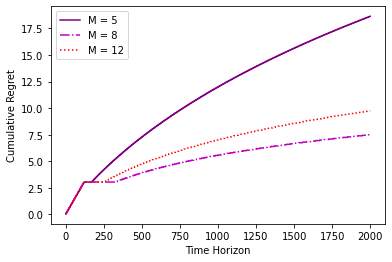

In [317]:
plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['M = 5','M = 8','M = 12'])

### Dependency on M

whether the regret bound should depend on M and heteorogenity is also different 
#20*(M+1)/(M**(3))
#### Heterogeneous
1) larger M leads to larger regret since a client needs to collect all the information of other clients 


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.1375     0.15833333]
 [0.175      0.21666667]
 [0.2125     0.275     ]
 [0.25       0.33333333]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.14285714 0.16190476]
 [0.18571429 0.22380952]
 [0.22857143 0.28571429]
 [0.27142857 0.34761905]
 [0.31428571 0.40952381]
 [0.35714286 0.47142857]
 [0.4        0.53333333]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.14545455 0.16363636]
 [0.19090909 0.22727273]
 [0.23636364 0.29090909]
 [0.28181818 0.35454545]
 [0.32727273 0.41818182]
 [0.37272727 0.48181818]
 [0.41818182 0.54545455]
 [0.46363636 0.60909091]
 [0.50909091 0.67272727]
 [0.55454545 0.73636364]
 [0.6        0.8       ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


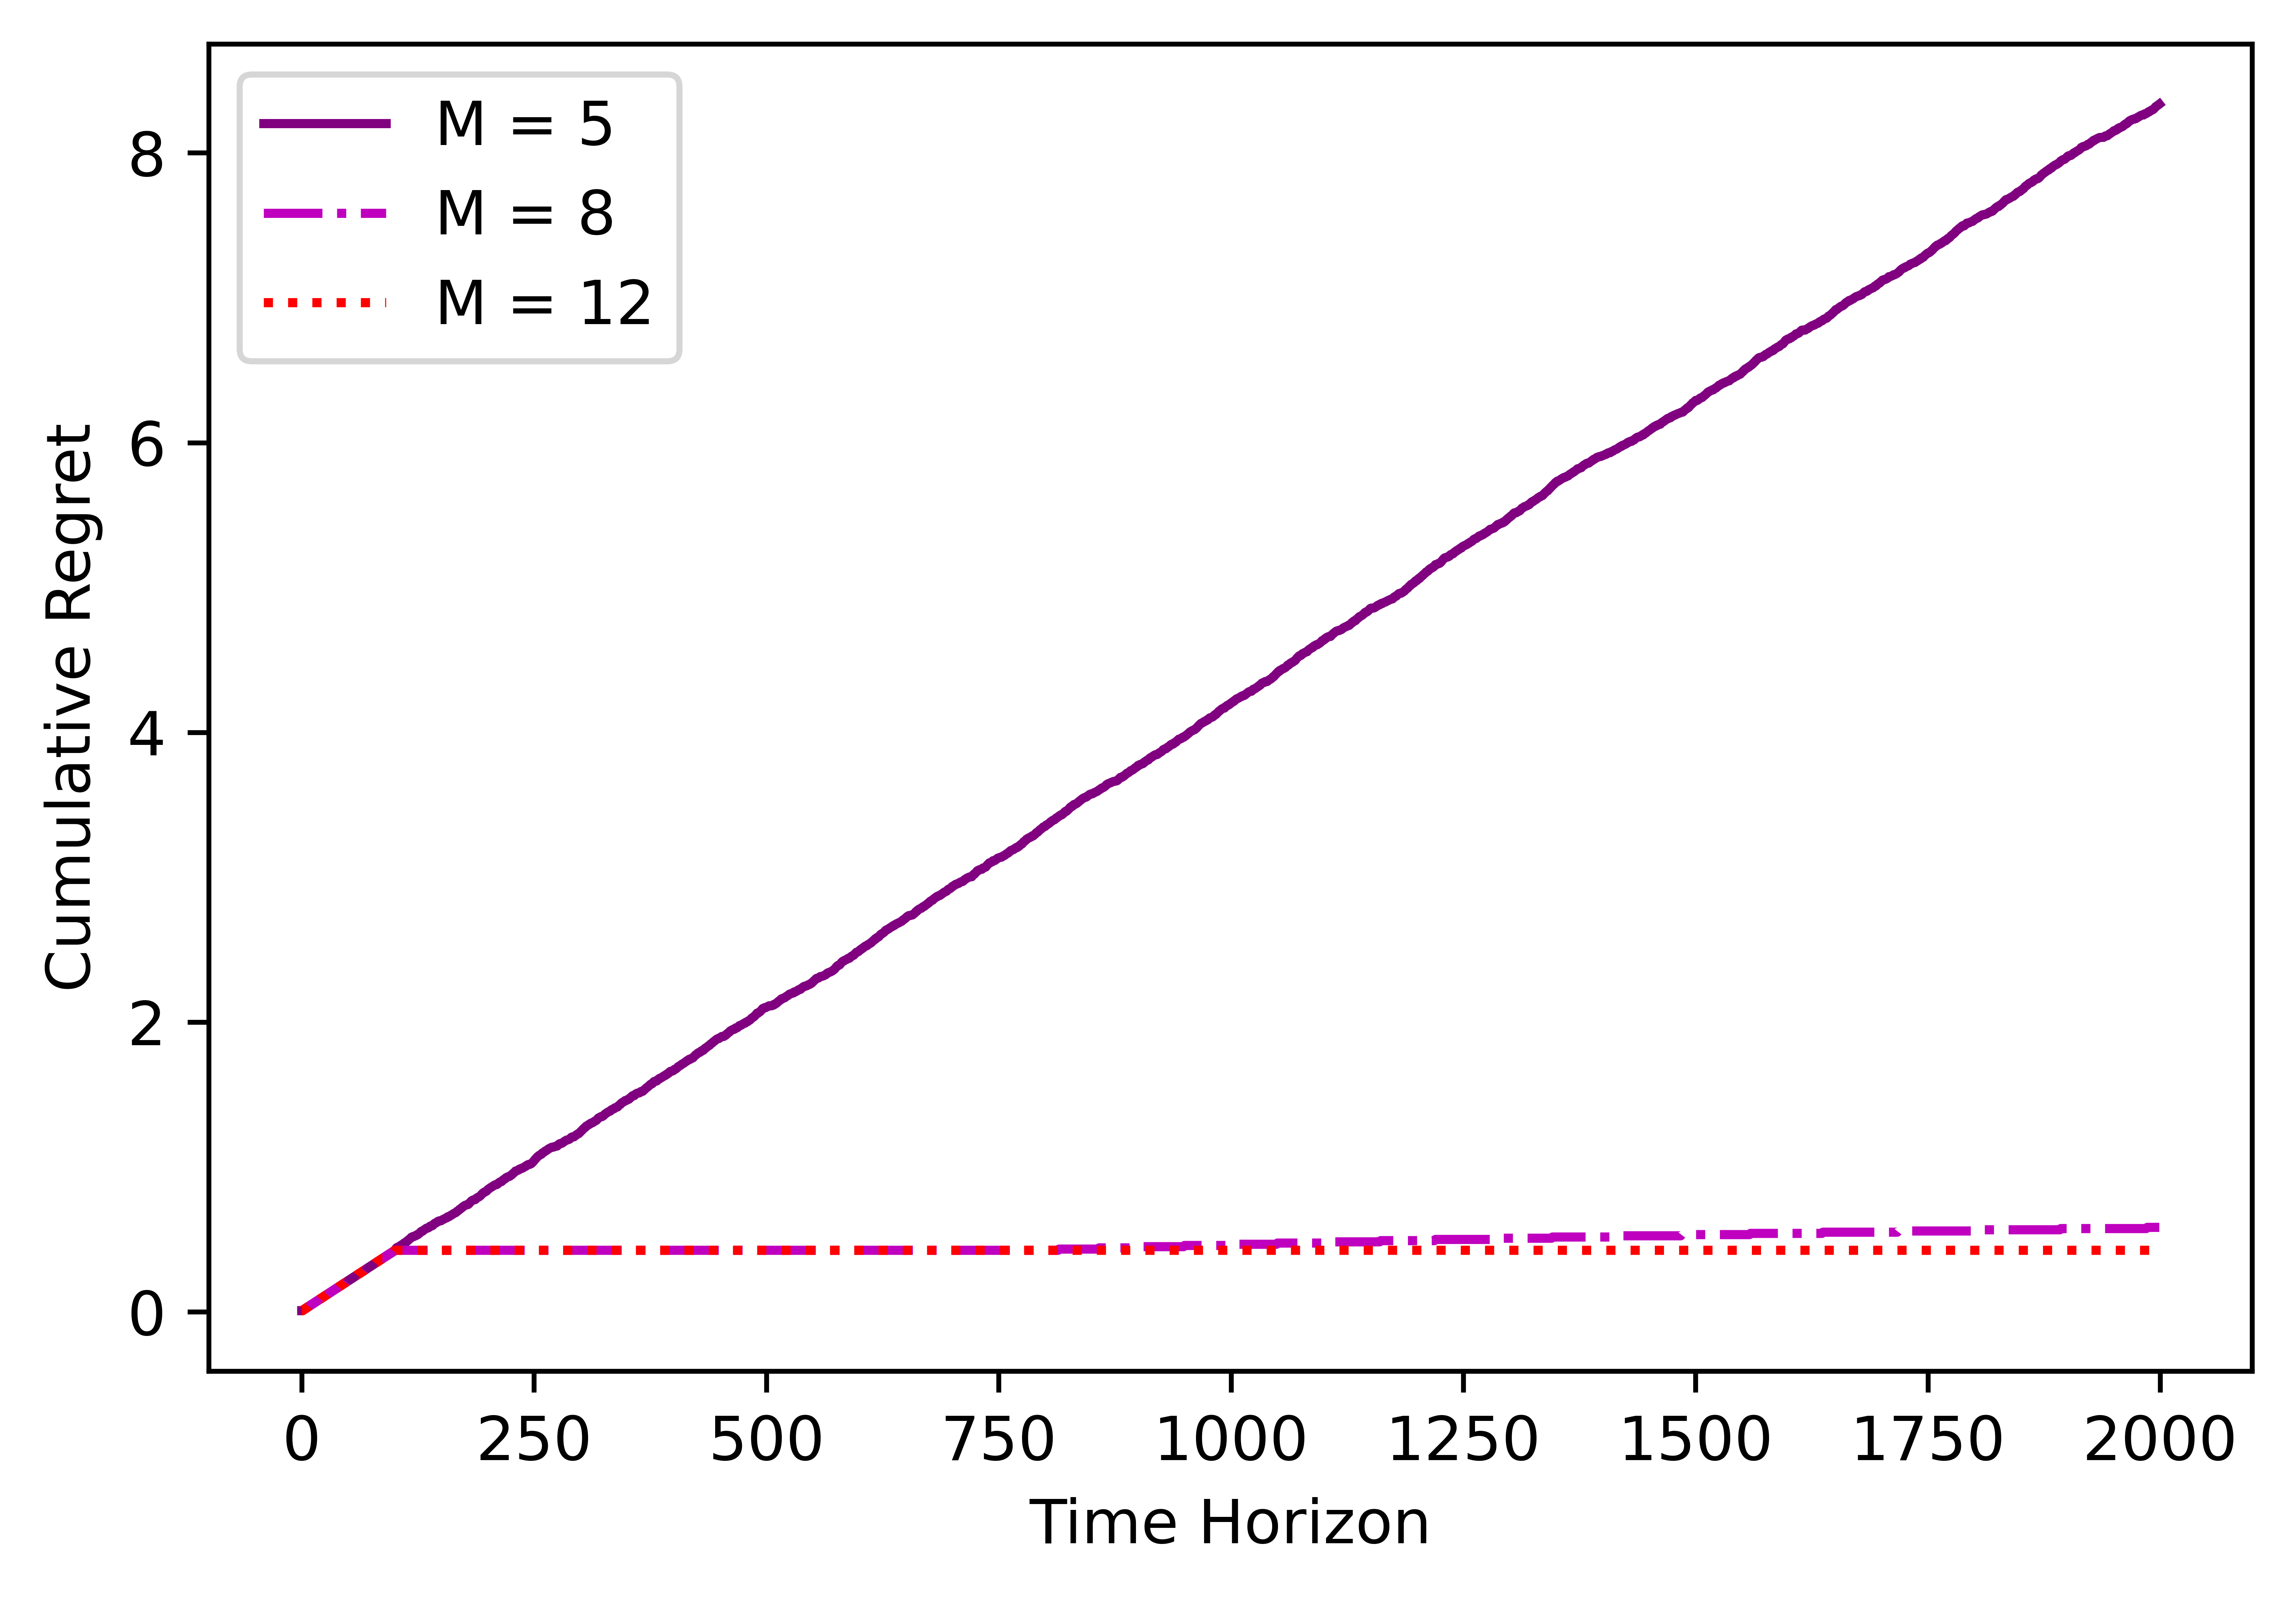

In [354]:
#characterizing the dependencies on the parameters
#heterogeneous settings 
def main_p(M,c,K,h,c1,L):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = L
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = c1
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    print(config['mu'])
    for k in range(config['K']):
        config['mu'][:,k] = np.linspace(0.1,(config['M']*(config['h']+(k+1)*config['h']/config['K']))/3,config['M'])
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 50
    avg_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([(bandit[i].regret_list[j])/config['M'] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        
        return avg_regret


M_set = [5, 8,12]
avg_regret_list = []
c1 = [0.15,0.1,0.1]
L = [100, 100, 100]
for i in range(len(M_set)):
    tmp_regret = main_p(M_set[i],0.95, 2, 0.1,c1[i], L[i])
    avg_regret_list.append(tmp_regret)
    
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['M = 5','M = 8','M = 12'])





[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.1375     0.15833333]
 [0.175      0.21666667]
 [0.2125     0.275     ]
 [0.25       0.33333333]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0.1        0.1        0.1       ]
 [0.13055556 0.14444444 0.15833333]
 [0.16111111 0.18888889 0.21666667]
 [0.19166667 0.23333333 0.275     ]
 [0.22222222 0.27777778 0.33333333]]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[0.1        0.1        0.1        0.1       ]
 [0.12708333 0.1375     0.14791667 0.15833333]
 [0.15416667 0.175      0.19583333 0.21666667]
 [0.18125    0.2125     0.24375    0.275     ]
 [0.20833333 0.25       0.29166667 0.33333333]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


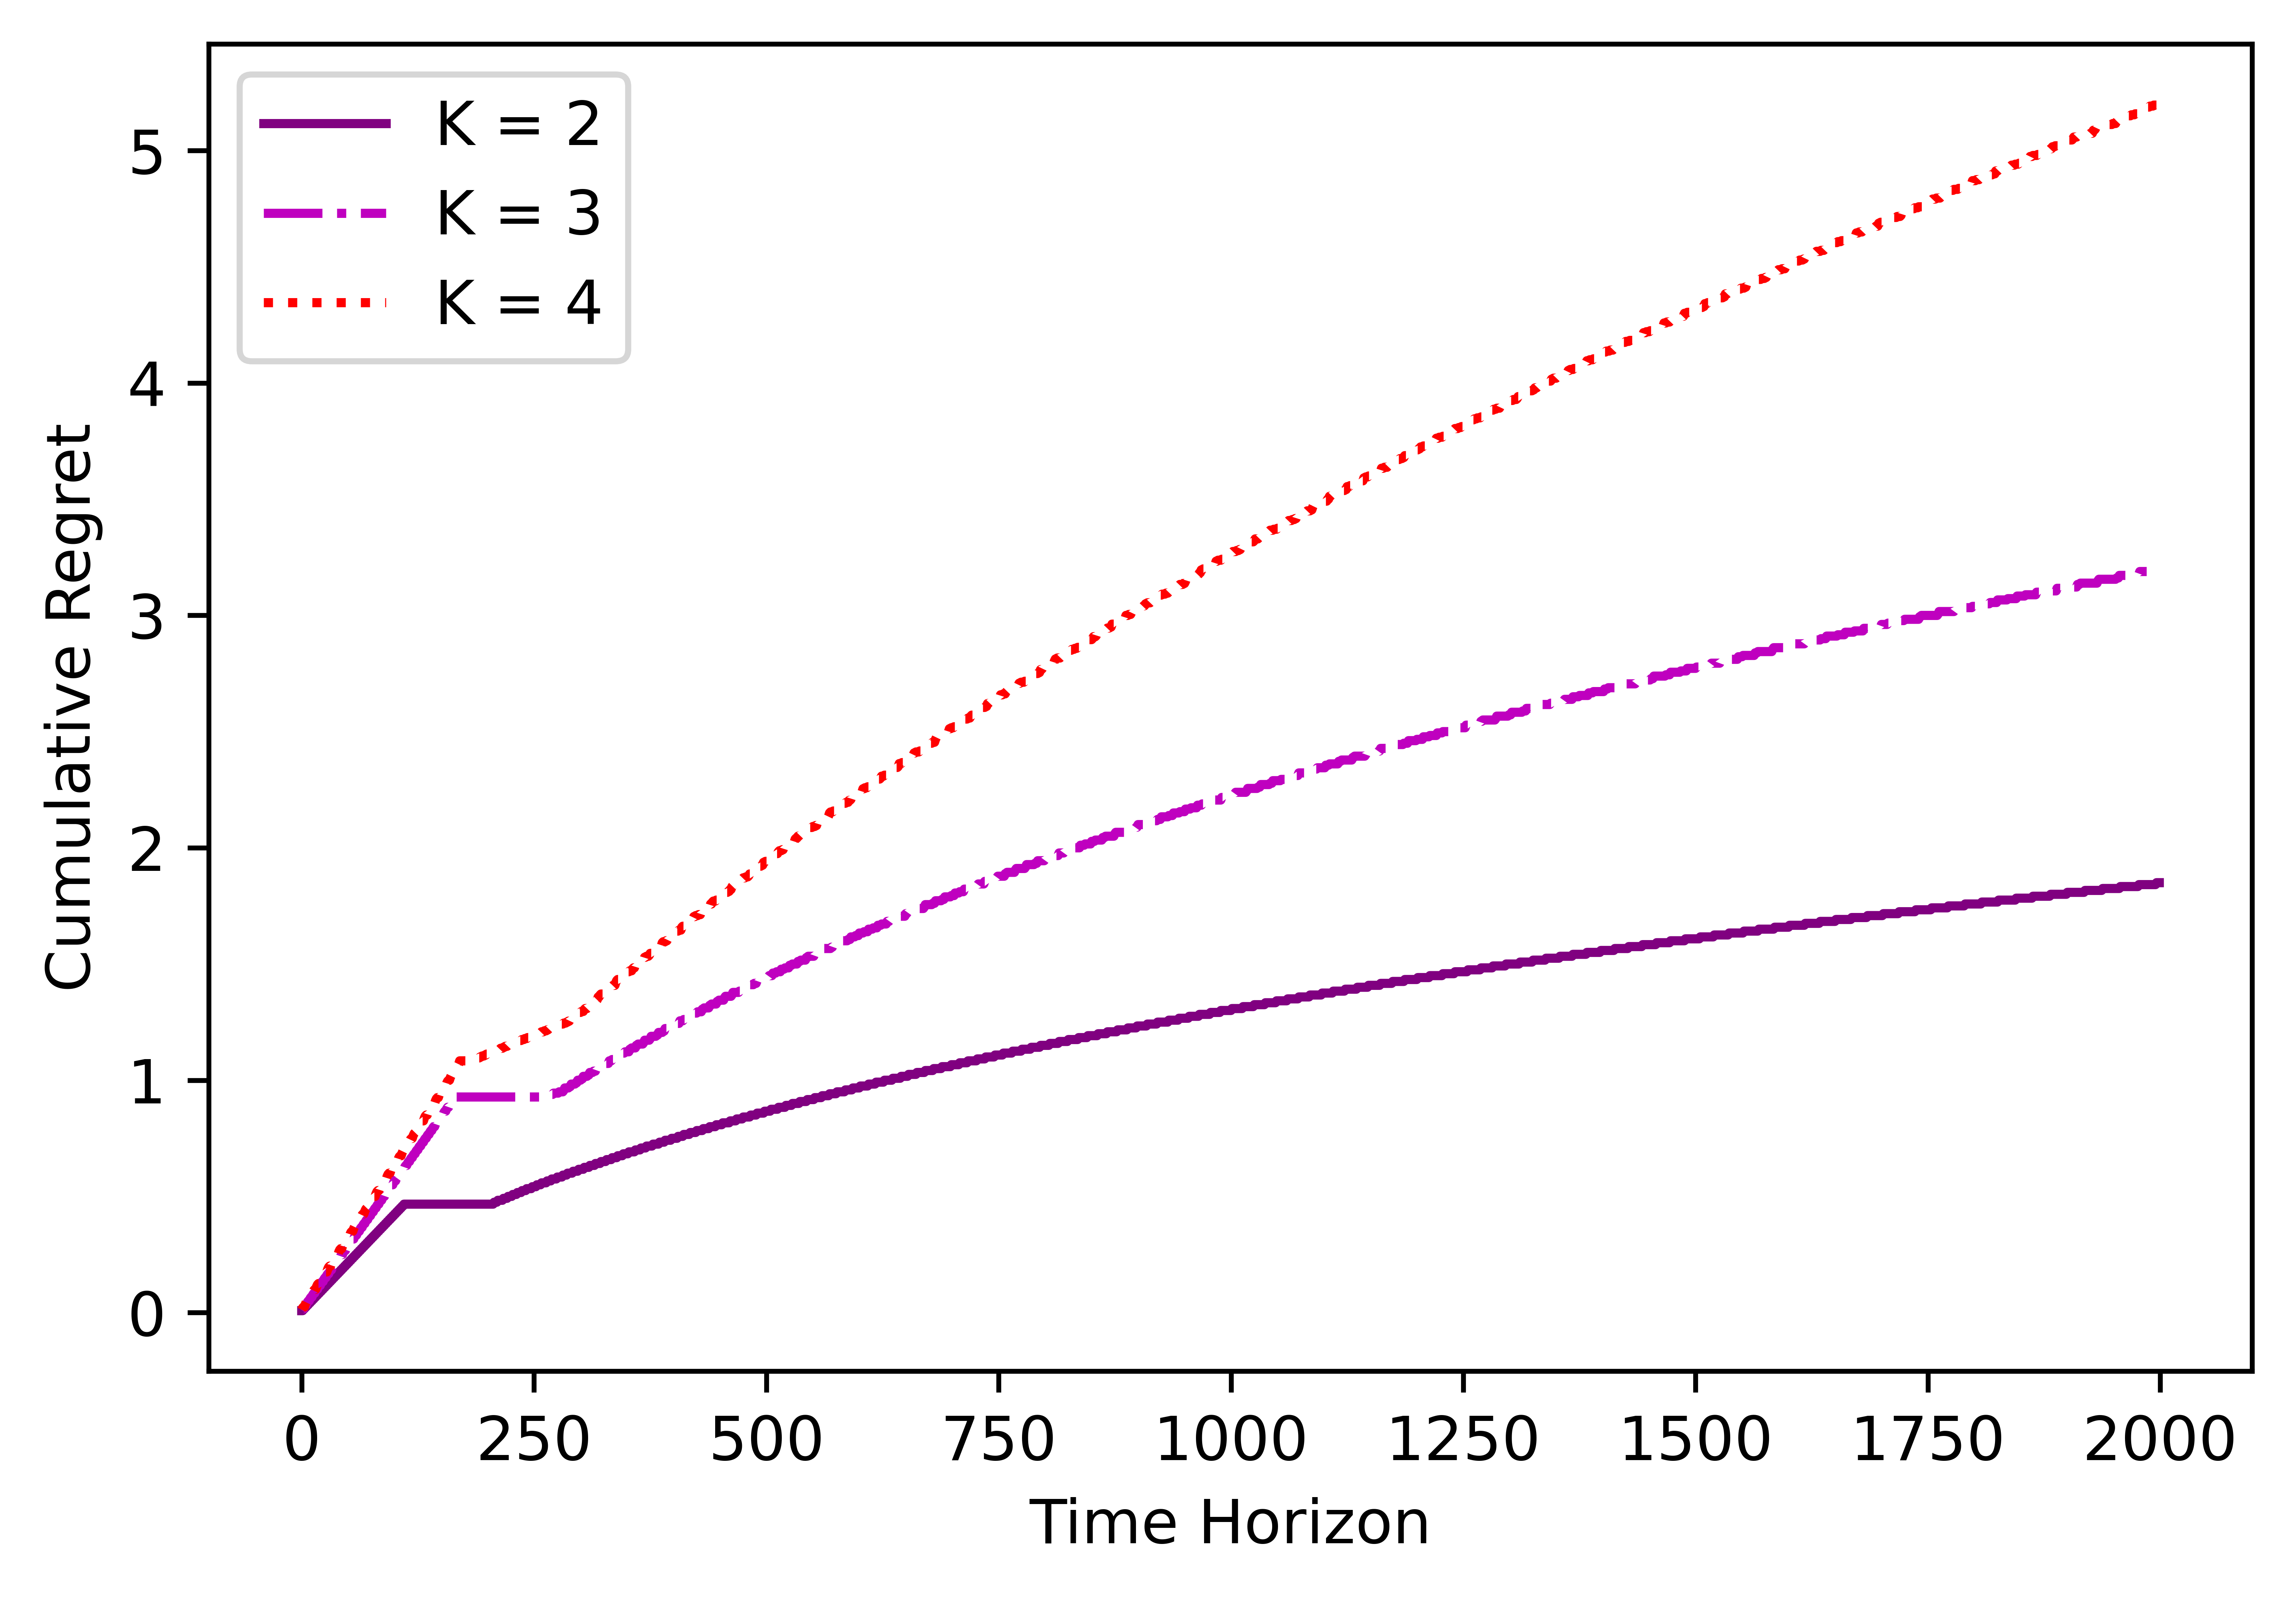

In [399]:
#number of arms 
K_set_1 = [2, 3]
avg_regret_list = []
for k in K_set_1:
    tmp_regret = main_p(5,0.9, k, 0.1, 0.18+(k-2)*0.01, k*55)
    avg_regret_list.append(tmp_regret)

K_set_2 = [4]
for k in K_set_2:
    tmp_regret = main_p(5,0.9, k, 0.1, 0.19, 170)
    avg_regret_list.append(tmp_regret)
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]

x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['K = 2','K = 3','K = 4'])

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1625 0.225 ]
 [0.225  0.35  ]
 [0.2875 0.475 ]
 [0.35   0.6   ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1875 0.25  ]
 [0.275  0.4   ]
 [0.3625 0.55  ]
 [0.45   0.7   ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.2125 0.275 ]
 [0.325  0.45  ]
 [0.4375 0.625 ]
 [0.55   0.8   ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


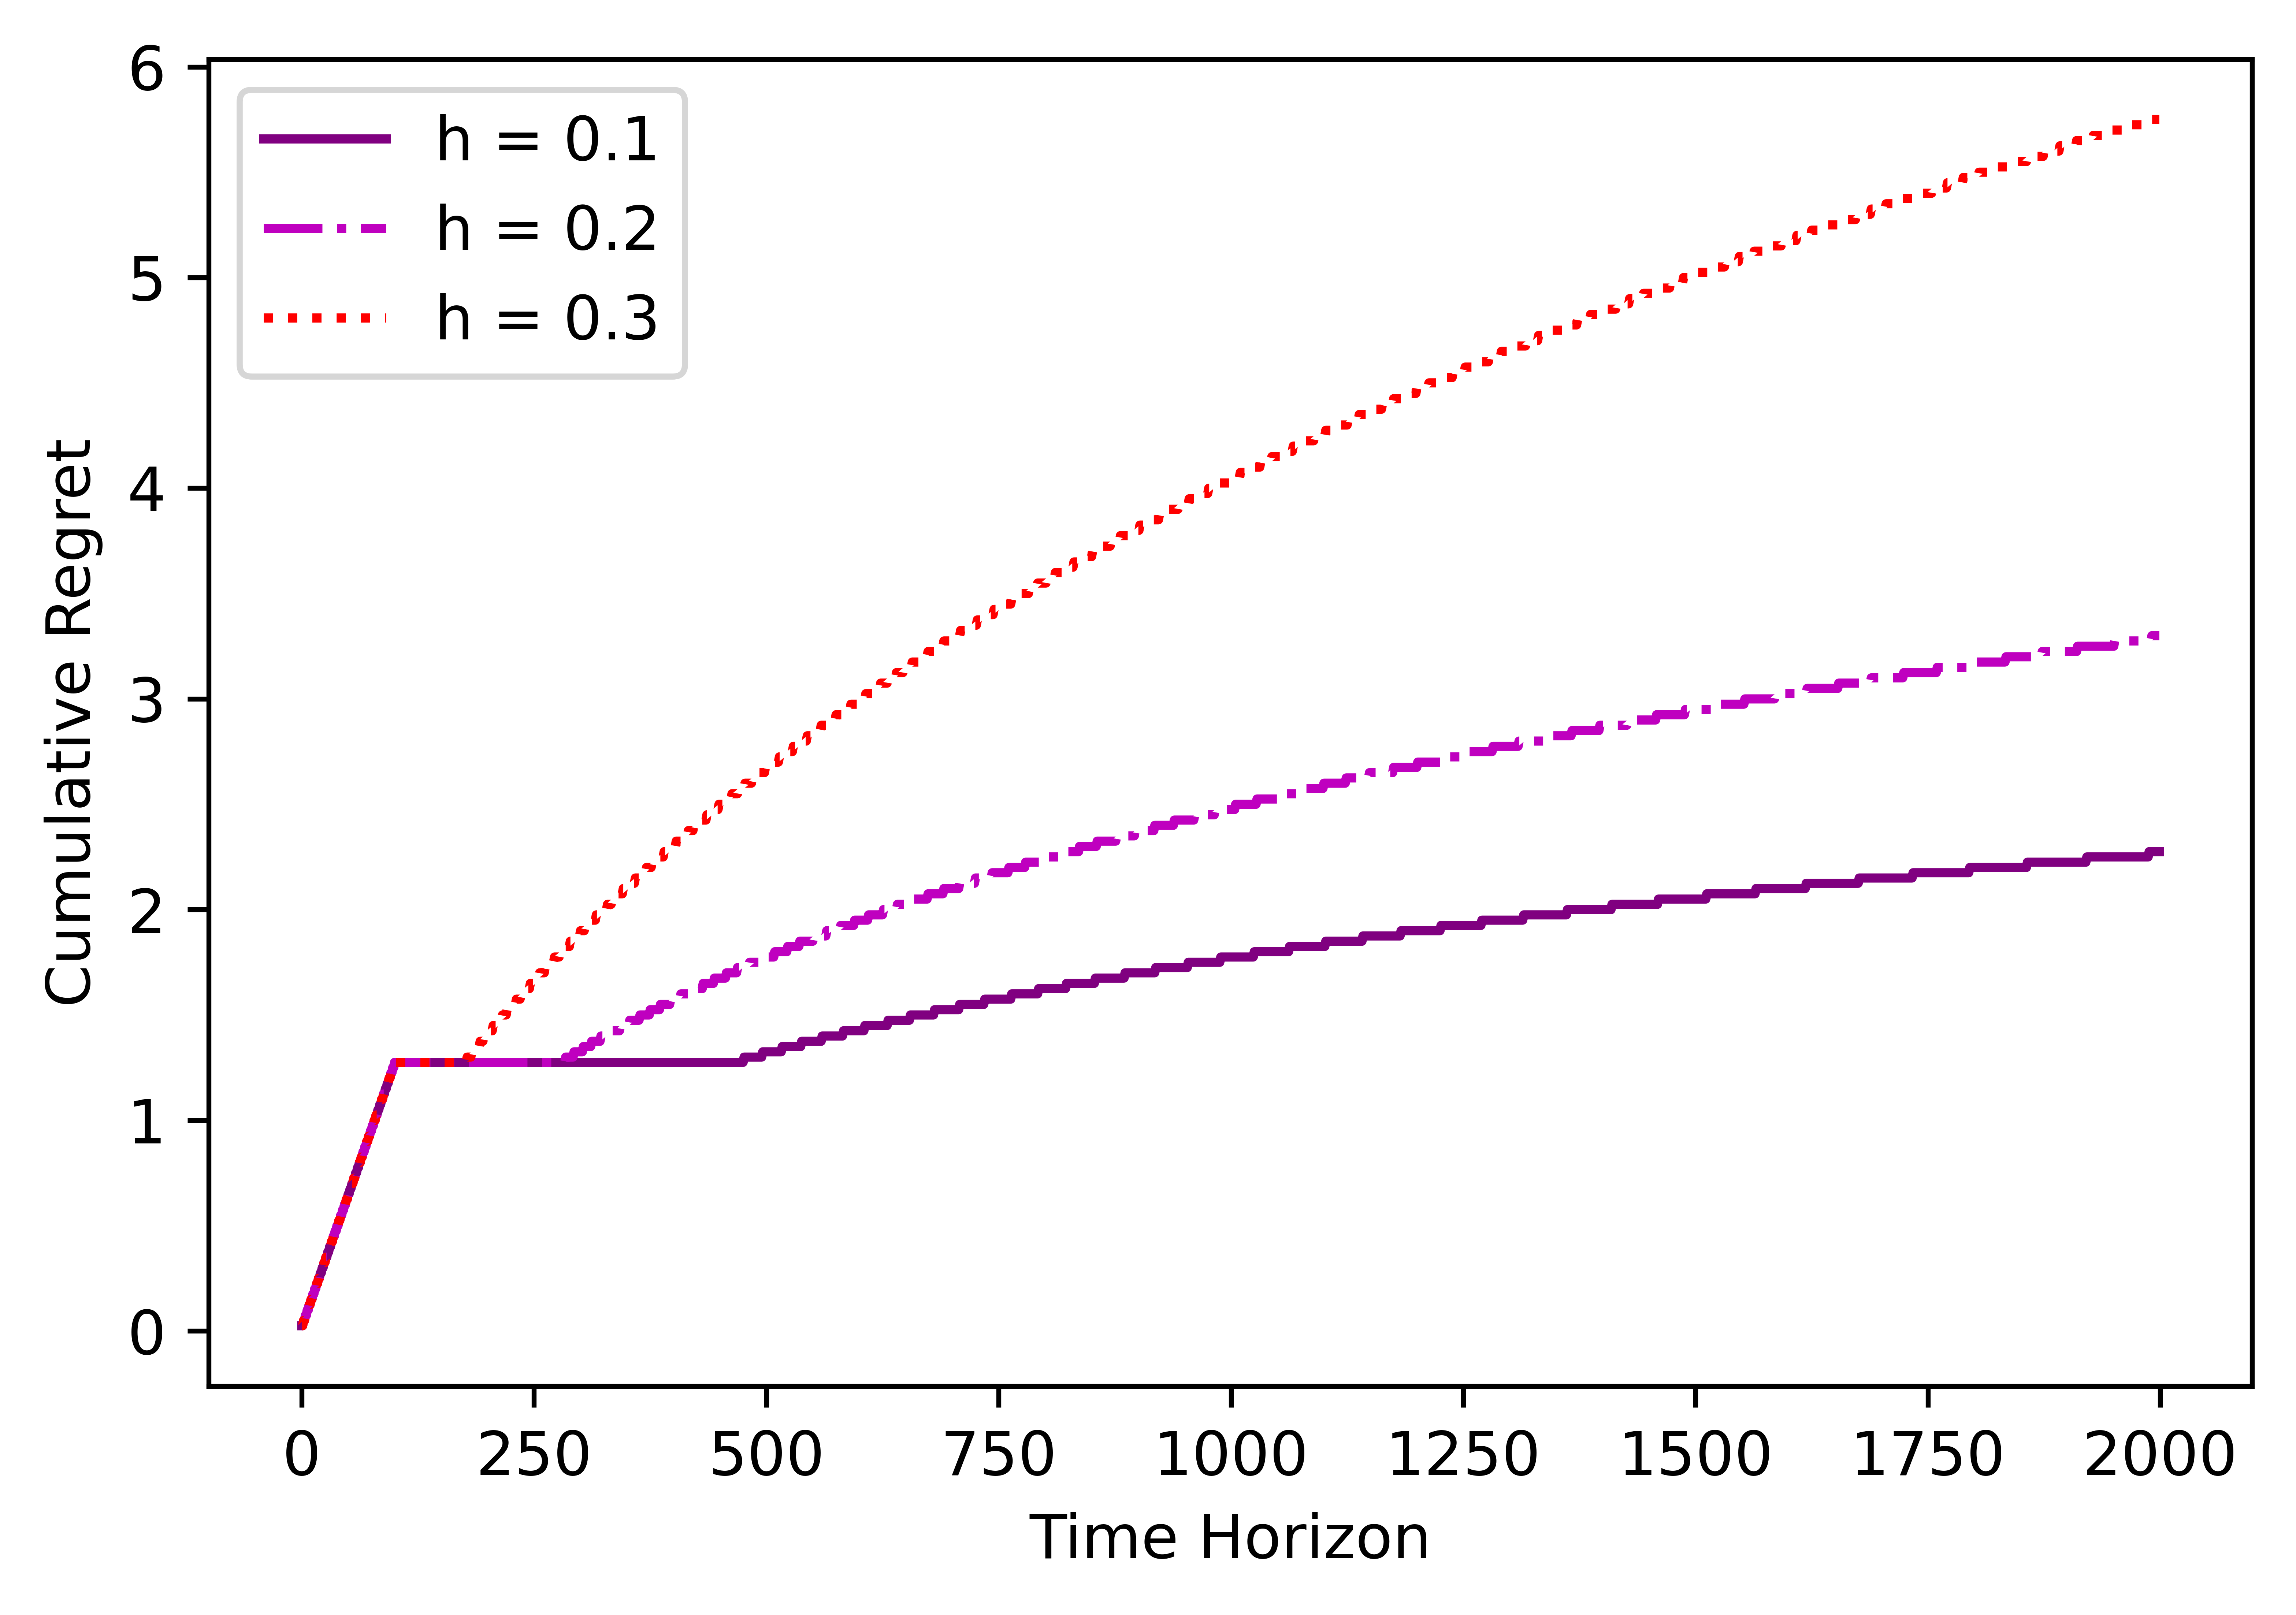

In [432]:
#characterizing the dependencies on the parameters
#heterogeneous settings 
def main_p(M,c,K,h,c1,L):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = L
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = c1
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    print(config['mu'])
    for k in range(config['K']):
        config['mu'][:,k] = np.linspace(0.1,config['h']+0.5*(k+1)/config['K'],config['M'])
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 50
    avg_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([(bandit[i].regret_list[j])/config['M'] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        
        return avg_regret






# the levels of heterogeneity 
h_set = [0.1,0.2,0.3]
avg_regret_list = []
for h in h_set:
    tmp_regret = main_p(5,0.9, 2, h, 0.5+h, 100)
    avg_regret_list.append(tmp_regret)

x=np.arange(2000)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])

plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['h = 0.1','h = 0.2','h = 0.3'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


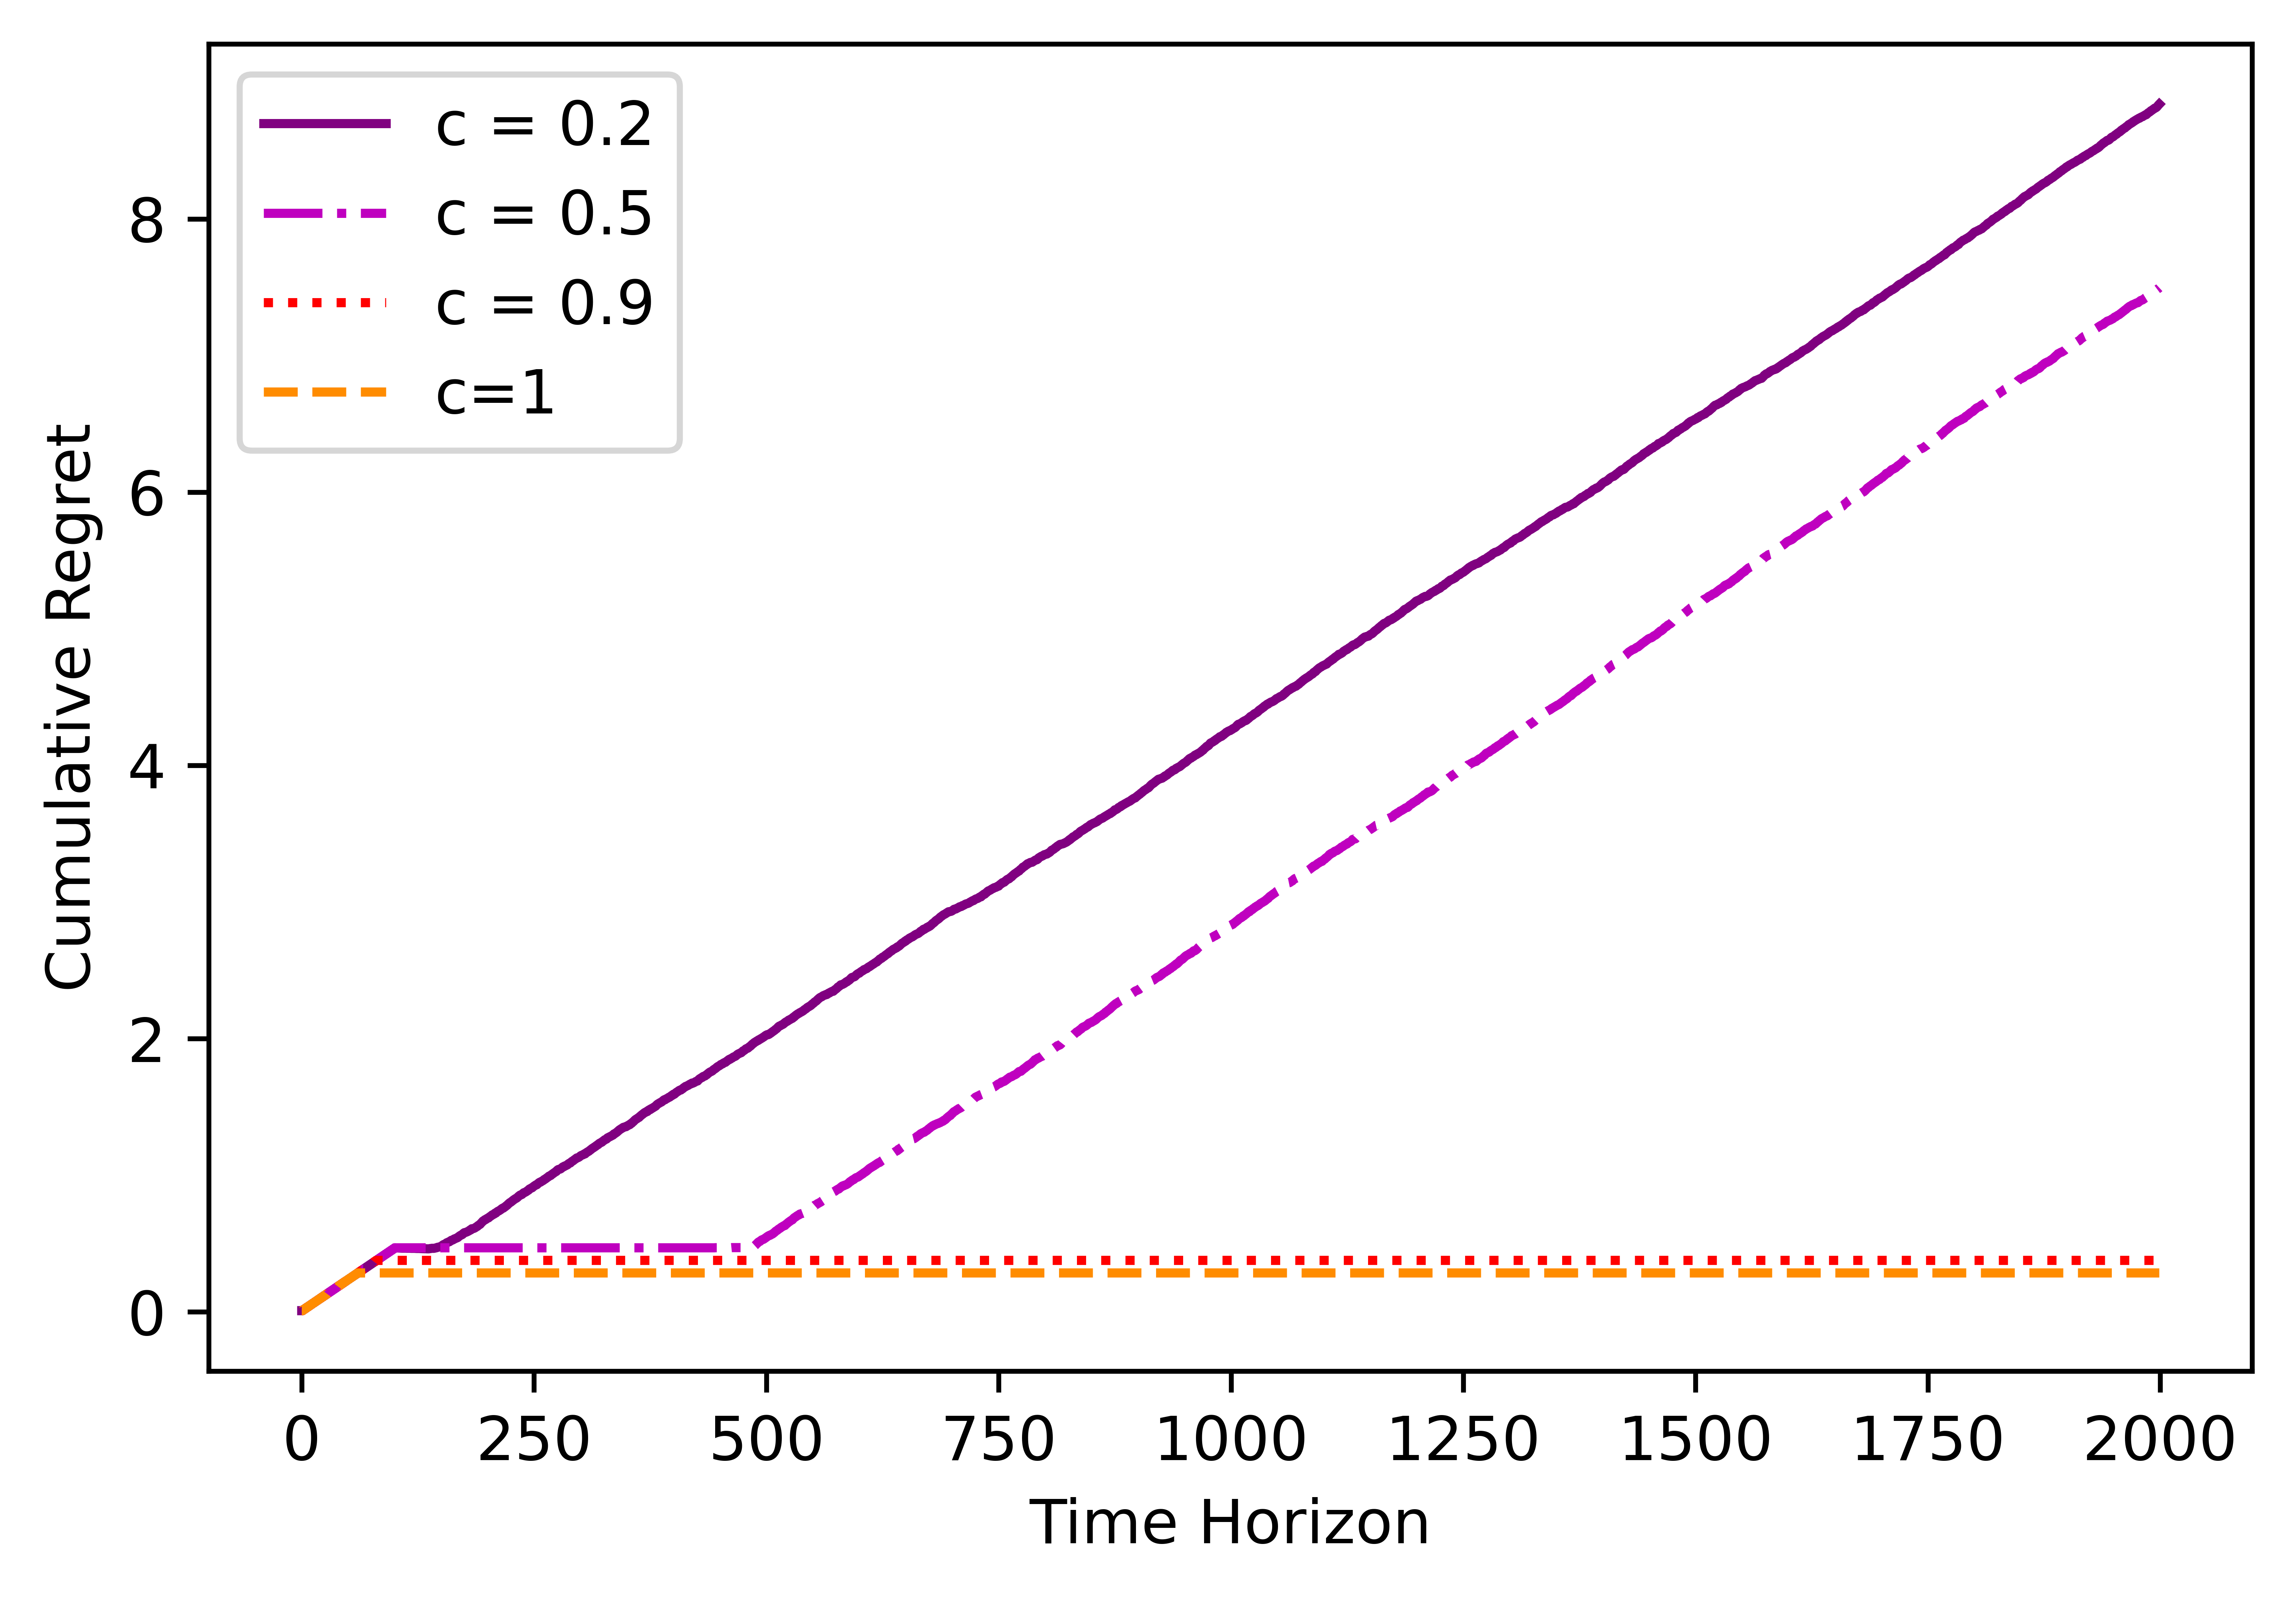

In [527]:
#characterizing the dependencies on the parameters
#dependency on c
def main_p(M,c,K,h,c1,L):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = L
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = c1
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    #print(config['mu'])
    for k in range(config['K']):
        config['mu'][1:,k] = np.linspace(0.1,config['h']+0.5*(k+1)/config['K'],config['M']-1)
    config['mu'][1,:] = np.linspace(0.15,0.1,config['K'])
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    #print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 50
    avg_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([(bandit[i].regret_list[j])/config['M'] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        
        return avg_regret






# the levels of heterogeneity 
c_set = [0.2,0.5,0.9, 1]
avg_regret_list = []
c1 = [0.1,0.1,0.01, 0.01]
L = [100, 100, 80,60]
for i in range(len(c_set)):
    tmp_regret = main_p(12,c_set[i], 2,0.1, c1[i], L[i])
    avg_regret_list.append(tmp_regret)

x=np.arange(2000)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,4))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])

plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['c = 0.2','c = 0.5','c = 0.9', 'c=1'])

In [451]:
np.sqrt(1-(0.9*10e-4)**0.2)

0.8683599780131876

In [ ]:
#sub-exponential 
#different graph complexities ()
class Environment:
    def __init__(self, config):
        self.T = config['T']
        self.M = config['M']
        self.c = config['c']

        self.mu = config['mu']
        self.sigma = config['sigma']
        self.h = config['h']
        #self.mu_opt_M = np.sort(self.mu)[-self.M:]
        self.K = config['K']
        logger.info(f"Created environment with M = {self.M}, mu = {self.mu},h= {self.h}, T = {self.T}, K = {self.K}")

    def __str__(self):
        return f"M{self.M}-K{self.K}-mu{str(self.mu)}"

    def update(self, t):
        pass

    def draw(self, arms, sensing=False):
        counts = collections.Counter(arms)
        rewards = np.zeros((self.M,))
        for player in range(self.M):
            #rewards[player] = np.random.normal(self.mu[player,arms[player]], self.sigma[player, arms[player]])
            if np.random.rand() <= self.mu[player,arms[player]]:
                rewards[player]=1
            else:
                rewards[player]=0
            #rewards[player] = np.random.binomial(1, self.mu[player,arms[player]], 1)
        graph = nx.erdos_renyi_graph(self.M,self.c,seed)


        return rewards, graph

class LocalMAB:
    def __init__(self, num_agents, num_arms):
        self.num_arms = num_arms
        #self.true_reward_means = true_reward_means
        self.q_local = np.zeros(num_arms)  # Estimated action values
        self.q_network = np.zeros(num_arms)  # Estimated action values
        self.q_var = np.zeros(num_arms)
        self.counts_local = np.zeros(num_arms)  # Counts of each action taken
        self.counts_network = np.zeros(num_arms)  # Counts of each action taken
        self.total_reward = 0
        self.c1 = 4
        self.c2 = 0
        self.epsilon = 0.1  # Exploration rate
        self.P = np.zeros(num_agents)
        self.P1 = np.zeros(num_agents)
        self.ucb = 0
        self.M = num_agents
        self.comm_reward = {}
        self.comm_counts = {}
        self.comm_reward_network = {}
        self.comm_counts_network = {}
        self.tmp = {}
        self.exp_reward = 0
        self.exp_reward_list = []
        self.regret = 0
        self.regret_list = []


    def choose_action(self, t, flag, c1):
        if flag:  # Corrected condition
            # Explore with probability epsilon
            return np.random.choice(self.num_arms)
        else:
            # Exploit the current estimates
            #self.counts_local[i]
            self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]
            self.ucb = [(self.q_network[i]+ self.q_var[i]) for i in range(len(self.q_network))]
            return np.argmax(self.ucb)

    def update(self, chosen_action, reward, exp_reward):
        # Update action values using sample-average method
        self.counts_local[chosen_action] += 1
        self.q_local[chosen_action] = (reward + self.q_local[chosen_action]*(self.counts_local[chosen_action]-1)) / self.counts_local[chosen_action]  # Corrected action counts
        self.total_reward += reward
        self.exp_reward += exp_reward
        self.exp_reward_list.append(self.exp_reward)
    
    def update_global(self, chosen_action, reward):
        # Update action values using sample-average method
        #self.counts_local[chosen_action] += 1
        a = 0
        for i in range(self.num_arms):  # Corrected loop
            for j in range(self.M):
                if self.P[j] >0:
                    a = max(self.comm_counts[j][i], a)  # Corrected assignment
            self.counts_network[i] = max(a, self.counts_local[i])
        #self.q_local[chosen_action] += (reward - self.q_local[chosen_action]) / self.counts_local[chosen_action]  # Corrected action counts
        for i in range(config['M']):
            d = (1 - np.sum(bandit[i].P1))/config['M']
            for k in range(config['K']):
                bandit[i].q_network[k] = sum([(bandit[i].P1[j] * bandit[i].comm_reward_network[j][k] + d*bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])
